In [27]:
import lcdb
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.model_selection
from sklearn import metrics
import pandas as pd
import scipy
from tqdm import tqdm
from functools import reduce
import random
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import concurrent.futures
from directencoder import DirectEncoder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import ast


encoder = DirectEncoder(2)
outer_seed = 0
inner_seed_index = 0
num_seeds = 5
outer_seeds = list(range(0,5))
inner_seeds = list(range(num_seeds * inner_seed_index, num_seeds * (inner_seed_index + 1)))

In [2]:
def calc_slopes_by_train(anchors, openml_id, learner_name, outer_seeds, inner_seeds, plotting=False):
    X, y = lcdb.get_dataset(openml_id)
    slopes = []
    n = len(anchors)
    
    # Code from LCDB paper
    learner_params = {}
    if learner_name == "SVC_linear":
        learner_name = "sklearn.svm.LinearSVC"
    elif learner_name == "SVC_poly":
        learner_name = "sklearn.svm.SVC"
        learner_params = {"kernel": "poly"}
    elif learner_name == "SVC_rbf":
        learner_name = "sklearn.svm.SVC"
        learner_params = {"kernel": "rbf"}
    elif learner_name == "SVC_sigmoid":
        learner_name = "sklearn.svm.SVC"
        learner_params = {"kernel": "sigmoid"}
    
    
    for idx,anchor in enumerate(anchors):
        points = range(anchor-10, anchor+11)
        max_anch = np.max(anchors)
        for idx,p in enumerate(points):
            if p > max_anch:
                points = range(max_anch - 20, max_anch)
                break
            elif p < 0:
                points = range(1, 22)
                break
        points = np.array(points).reshape(-1,1)
        err_lin_reg = []
        err_lin_points = []
        slp = []
        for outer_seed in outer_seeds:
            for inner_seed in inner_seeds:
                measurements = []
                for anch in points:
                    info = lcdb.get_entry(learner_name, {}, X,y, anch[0], outer_seed, inner_seed)
                    y_pred = encoder.decode_label_vector(info['y_hat_train'])
                    y_true = encoder.decode_label_vector(info['y_train'])
                    err = 1 - metrics.accuracy_score(y_true, y_pred)
                    measurements.append(err)
                    err_lin_points.append(anch)
                lin_reg = LinearRegression()
                lin_reg.fit(points, measurements)
                slp.append(lin_reg.coef_[0])
        slopes.append(np.mean(slp))

    return slopes

@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UserWarning)
@ignore_warnings(category=RuntimeWarning)
def calc_monotonicity_one_lc(openml_id, learner_name):
    curve = lcdb.get_curve(openml_id, learner_name)
    errors = [[1-y for y in x] for x in curve[1]] # Transform accuracy in error rate
    slopes_curr = calc_slopes_by_train(curve[0], openml_id, learner_name, outer_seeds, inner_seeds)
    
    for j in range(0, len(slopes_curr) - 1):
        if slopes_curr[j] > 0 and slopes_curr[j+1] > 0:
            return slopes_curr, True
    
    if slopes_curr[(len(slopes_curr) - 1)]:
        return slopes_curr, True
    
    return slopes_curr, False

In [58]:
to_consider = ['sklearn.discriminant_analysis.LinearDiscriminantAnalysis', 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis', 'sklearn.linear_model.SGDClassifier']
exp_df = lcdb.get_all_curves('accuracy')
exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]

lda = exp_df[exp_df['learner'] == to_consider[0]]
# lda['traintime'].describe()


rows = []


for el in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    q25 = lda['traintime'].quantile(0.25)
    lda = lda[lda['traintime'] < q25]
    for idx, row in tqdm(lda.iterrows()):
        try:
            slopes, flag = calc_monotonicity_one_lc(row['openmlid'], row['learner'])
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}")
            rows.append([row['learner'], row['openmlid'], slopes, flag])
        except Exception as e:
            print(e)

1it [00:17, 17.88s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 11 is non-monotonic: True


2it [01:08, 37.37s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 18 is non-monotonic: True


3it [02:05, 45.99s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 21 is non-monotonic: True


4it [02:30, 37.76s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 54 is non-monotonic: True


5it [02:40, 27.88s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 55 is non-monotonic: True


6it [02:50, 21.68s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 61 is non-monotonic: True


7it [03:32, 28.38s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 181 is non-monotonic: True


8it [04:16, 33.30s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 185 is non-monotonic: True


9it [04:22, 24.93s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 346 is non-monotonic: True


10it [04:30, 19.74s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 380 is non-monotonic: True


11it [04:43, 17.55s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 446 is non-monotonic: False


12it [05:06, 19.22s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 679 is non-monotonic: True


13it [05:37, 22.74s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 715 is non-monotonic: True


14it [06:08, 25.40s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 723 is non-monotonic: True


15it [07:04, 34.53s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 728 is non-monotonic: True


16it [07:54, 39.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 737 is non-monotonic: True


17it [08:18, 34.68s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 740 is non-monotonic: True


18it [08:45, 32.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 741 is non-monotonic: True


19it [09:09, 29.90s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 743 is non-monotonic: True


20it [09:33, 28.04s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 751 is non-monotonic: True


21it [10:07, 29.73s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 772 is non-monotonic: True


22it [10:32, 28.46s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 799 is non-monotonic: True


23it [10:56, 27.03s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 813 is non-monotonic: True


24it [11:19, 25.81s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 845 is non-monotonic: True


25it [11:51, 27.66s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 849 is non-monotonic: True


26it [12:43, 34.90s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 871 is non-monotonic: True


27it [13:14, 33.77s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 903 is non-monotonic: True


28it [13:39, 31.31s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 910 is non-monotonic: True


29it [14:05, 29.78s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 912 is non-monotonic: True


30it [14:28, 27.53s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 913 is non-monotonic: True


31it [14:58, 28.45s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 914 is non-monotonic: True


32it [15:30, 29.39s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 917 is non-monotonic: True


33it [16:13, 33.42s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 966 is non-monotonic: True


34it [16:58, 36.98s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 991 is non-monotonic: True


35it [17:13, 30.49s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1448 is non-monotonic: True


36it [17:24, 24.58s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1450 is non-monotonic: True


37it [17:35, 20.49s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1465 is non-monotonic: True


38it [17:48, 18.27s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1488 is non-monotonic: True


39it [19:01, 34.75s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1489 is non-monotonic: True


40it [19:15, 28.29s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1499 is non-monotonic: True


41it [19:16, 20.34s/it]

The number of samples must be more than the number of classes.


42it [20:06, 29.24s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40975 is non-monotonic: True


43it [20:36, 28.76s/it]


sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40981 is non-monotonic: True


1it [00:01,  1.66s/it]

y has only 1 sample in class B, covariance is ill defined.


2it [00:03,  1.57s/it]

y has only 1 sample in class 3, covariance is ill defined.


3it [00:05,  1.93s/it]

y has only 1 sample in class 2, covariance is ill defined.


4it [00:07,  1.82s/it]

y has only 1 sample in class bus, covariance is ill defined.


5it [00:08,  1.75s/it]

y has only 1 sample in class DIE, covariance is ill defined.


6it [00:10,  1.67s/it]

y has only 1 sample in class Iris-setosa, covariance is ill defined.


7it [00:11,  1.59s/it]

y has only 1 sample in class EXC, covariance is ill defined.


8it [00:13,  1.59s/it]

y has only 1 sample in class 1, covariance is ill defined.


9it [00:20,  3.35s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 346 is non-monotonic: True


10it [00:22,  2.83s/it]

The number of classes has to be greater than one; got 1 class


11it [00:35,  5.89s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 446 is non-monotonic: True


12it [00:36,  4.64s/it]

y has only 1 sample in class 3, covariance is ill defined.


13it [01:11, 13.84s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 715 is non-monotonic: True


14it [01:14, 10.52s/it]

y has only 1 sample in class P, covariance is ill defined.


15it [01:48, 17.53s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 723 is non-monotonic: True


16it [01:50, 12.73s/it]

y has only 1 sample in class P, covariance is ill defined.


17it [01:51,  9.46s/it]

y has only 1 sample in class N, covariance is ill defined.


18it [02:15, 13.80s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 740 is non-monotonic: True


19it [02:40, 17.19s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 741 is non-monotonic: True


20it [03:07, 19.95s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 743 is non-monotonic: True


21it [03:30, 20.96s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 751 is non-monotonic: True


22it [03:32, 15.16s/it]

y has only 1 sample in class P, covariance is ill defined.


23it [03:33, 11.14s/it]

y has only 1 sample in class N, covariance is ill defined.


24it [03:36,  8.52s/it]

y has only 1 sample in class P, covariance is ill defined.


25it [03:37,  6.41s/it]

y has only 1 sample in class P, covariance is ill defined.


26it [04:01, 11.51s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 845 is non-monotonic: True


27it [04:33, 17.78s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 849 is non-monotonic: True


28it [04:35, 13.03s/it]

y has only 1 sample in class N, covariance is ill defined.


29it [04:37,  9.63s/it]

y has only 1 sample in class P, covariance is ill defined.


30it [05:02, 14.33s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 910 is non-monotonic: True


31it [05:27, 17.61s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 912 is non-monotonic: True


32it [05:29, 12.90s/it]

y has only 1 sample in class N, covariance is ill defined.


33it [05:31,  9.57s/it]

y has only 1 sample in class P, covariance is ill defined.


34it [06:06, 17.11s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 917 is non-monotonic: True


35it [06:10, 13.11s/it]

y has only 1 sample in class P, covariance is ill defined.


36it [06:12,  9.92s/it]

The number of classes has to be greater than one; got 1 class


37it [06:14,  7.48s/it]

y has only 1 sample in class N, covariance is ill defined.


38it [06:16,  5.75s/it]

y has only 1 sample in class N, covariance is ill defined.


39it [06:18,  4.74s/it]

y has only 1 sample in class N, covariance is ill defined.


40it [06:20,  3.95s/it]

y has only 1 sample in class True, covariance is ill defined.


41it [06:23,  3.51s/it]

The number of classes has to be greater than one; got 1 class


42it [06:30,  4.67s/it]

y has only 1 sample in class Y, covariance is ill defined.


43it [06:32,  3.77s/it]

The number of classes has to be greater than one; got 1 class


44it [06:33,  3.16s/it]

y has only 1 sample in class Y, covariance is ill defined.


45it [06:36,  2.88s/it]

The number of classes has to be greater than one; got 1 class


46it [06:37,  2.49s/it]

y has only 1 sample in class 4, covariance is ill defined.


47it [06:39,  2.21s/it]

The number of classes has to be greater than one; got 1 class


48it [06:40,  2.05s/it]

The number of classes has to be greater than one; got 1 class


49it [06:42,  1.93s/it]

y has only 1 sample in class 1, covariance is ill defined.


50it [06:44,  1.81s/it]

y has only 1 sample in class 0, covariance is ill defined.


51it [06:46,  2.13s/it]

The number of classes has to be greater than one; got 1 class


52it [06:51,  7.92s/it]


y has only 1 sample in class 0, covariance is ill defined.


1it [00:42, 42.02s/it]

'NoneType' object is not subscriptable


2it [01:03, 29.70s/it]

sklearn.linear_model.SGDClassifier on 11 is non-monotonic: True


3it [01:05, 17.25s/it]

The number of classes has to be greater than one; got 1 class


4it [01:07, 11.22s/it]

The number of classes has to be greater than one; got 1 class


5it [02:17, 32.47s/it]

'NoneType' object is not subscriptable


6it [02:47, 31.62s/it]

sklearn.linear_model.SGDClassifier on 31 is non-monotonic: True


7it [02:49, 21.81s/it]

The number of classes has to be greater than one; got 1 class


8it [03:00, 18.59s/it]

sklearn.linear_model.SGDClassifier on 61 is non-monotonic: True


9it [03:03, 13.46s/it]

The number of classes has to be greater than one; got 1 class


10it [03:09, 11.19s/it]

sklearn.linear_model.SGDClassifier on 346 is non-monotonic: True


11it [03:10,  8.20s/it]

The number of classes has to be greater than one; got 1 class


12it [03:21,  8.89s/it]

sklearn.linear_model.SGDClassifier on 446 is non-monotonic: True


13it [03:45, 13.66s/it]

sklearn.linear_model.SGDClassifier on 715 is non-monotonic: True


14it [04:11, 17.45s/it]

sklearn.linear_model.SGDClassifier on 723 is non-monotonic: True


15it [04:33, 18.70s/it]

sklearn.linear_model.SGDClassifier on 740 is non-monotonic: True


16it [04:55, 19.77s/it]

sklearn.linear_model.SGDClassifier on 741 is non-monotonic: True


17it [05:16, 20.04s/it]

sklearn.linear_model.SGDClassifier on 743 is non-monotonic: True


18it [05:39, 20.96s/it]

sklearn.linear_model.SGDClassifier on 751 is non-monotonic: True


19it [06:10, 23.88s/it]

'NoneType' object is not subscriptable


20it [06:35, 24.24s/it]

sklearn.linear_model.SGDClassifier on 799 is non-monotonic: True


21it [07:09, 27.09s/it]

sklearn.linear_model.SGDClassifier on 806 is non-monotonic: True


22it [07:32, 26.00s/it]

sklearn.linear_model.SGDClassifier on 813 is non-monotonic: True


23it [07:58, 26.05s/it]

sklearn.linear_model.SGDClassifier on 845 is non-monotonic: True


24it [08:25, 26.26s/it]

sklearn.linear_model.SGDClassifier on 849 is non-monotonic: True


25it [08:56, 27.57s/it]

sklearn.linear_model.SGDClassifier on 866 is non-monotonic: True


26it [09:22, 27.25s/it]

sklearn.linear_model.SGDClassifier on 897 is non-monotonic: True


27it [09:50, 27.57s/it]

sklearn.linear_model.SGDClassifier on 903 is non-monotonic: True


28it [10:18, 27.65s/it]

sklearn.linear_model.SGDClassifier on 904 is non-monotonic: True


29it [10:42, 26.50s/it]

sklearn.linear_model.SGDClassifier on 910 is non-monotonic: True


30it [11:04, 25.20s/it]

sklearn.linear_model.SGDClassifier on 912 is non-monotonic: True


31it [11:29, 25.11s/it]

sklearn.linear_model.SGDClassifier on 913 is non-monotonic: True


32it [11:55, 25.46s/it]

'NoneType' object is not subscriptable


33it [12:21, 25.65s/it]

sklearn.linear_model.SGDClassifier on 917 is non-monotonic: True


34it [12:24, 18.75s/it]

The number of classes has to be greater than one; got 1 class


35it [12:27, 13.85s/it]

The number of classes has to be greater than one; got 1 class


36it [13:52, 35.29s/it]

'NoneType' object is not subscriptable


37it [13:53, 25.19s/it]

The number of classes has to be greater than one; got 1 class


38it [13:56, 18.25s/it]

The number of classes has to be greater than one; got 1 class


39it [13:59, 13.73s/it]

The number of classes has to be greater than one; got 1 class


40it [14:27, 18.24s/it]

'NoneType' object is not subscriptable


41it [14:31, 13.69s/it]

The number of classes has to be greater than one; got 1 class


42it [14:33, 10.36s/it]

The number of classes has to be greater than one; got 1 class


43it [14:35,  7.81s/it]

The number of classes has to be greater than one; got 1 class


44it [14:37,  6.13s/it]

The number of classes has to be greater than one; got 1 class


45it [14:39,  4.96s/it]

The number of classes has to be greater than one; got 1 class


46it [14:42,  4.35s/it]

The number of classes has to be greater than one; got 1 class


47it [14:45,  3.77s/it]

The number of classes has to be greater than one; got 1 class


48it [14:47,  3.22s/it]

The number of classes has to be greater than one; got 1 class


49it [14:48,  2.75s/it]

The number of classes has to be greater than one; got 1 class


50it [14:51,  2.61s/it]

The number of classes has to be greater than one; got 1 class


51it [14:52,  2.38s/it]

The number of classes has to be greater than one; got 1 class


52it [14:54,  2.19s/it]

The number of classes has to be greater than one; got 1 class


53it [15:02,  4.01s/it]

sklearn.linear_model.SGDClassifier on 1450 is non-monotonic: True


54it [15:04,  3.32s/it]

The number of classes has to be greater than one; got 1 class


55it [15:19,  6.78s/it]

sklearn.linear_model.SGDClassifier on 1465 is non-monotonic: True


56it [15:22,  5.55s/it]

The number of classes has to be greater than one; got 1 class


57it [15:23,  4.39s/it]

The number of classes has to be greater than one; got 1 class


58it [15:26,  3.84s/it]

The number of classes has to be greater than one; got 1 class


59it [15:42,  7.55s/it]

sklearn.linear_model.SGDClassifier on 1499 is non-monotonic: True


60it [16:12, 14.16s/it]

sklearn.linear_model.SGDClassifier on 1566 is non-monotonic: True


61it [16:35, 16.99s/it]

sklearn.linear_model.SGDClassifier on 40981 is non-monotonic: True


62it [16:37, 16.09s/it]

The number of classes has to be greater than one; got 1 class


0it [00:00, ?it/s]

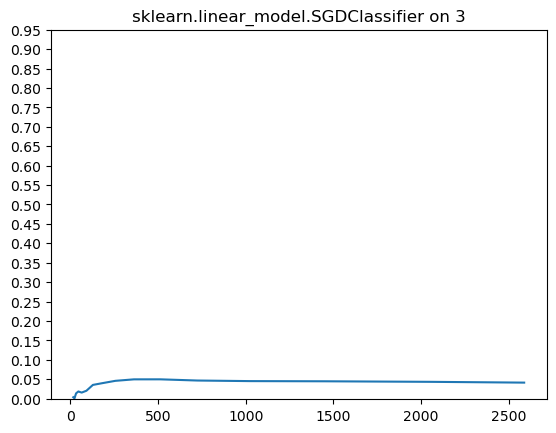

1it [00:01,  1.80s/it]

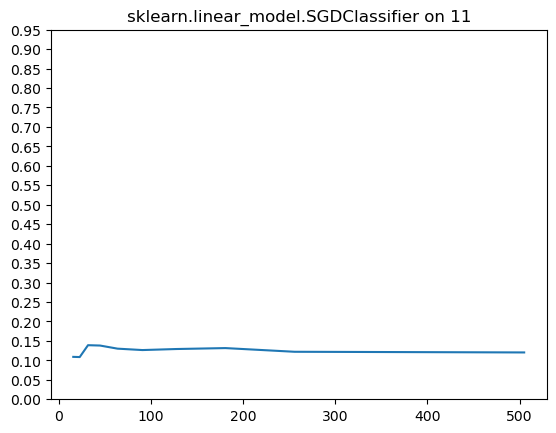

2it [00:03,  1.83s/it]

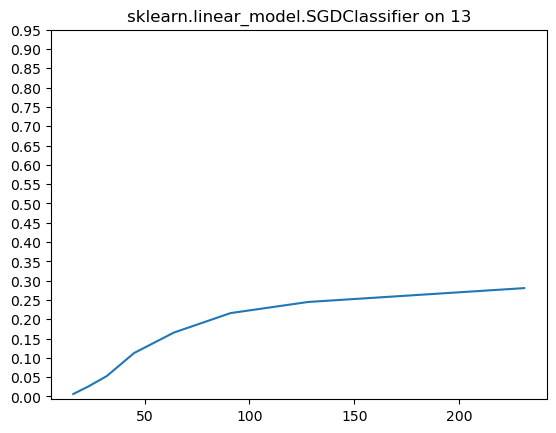

3it [00:05,  1.86s/it]

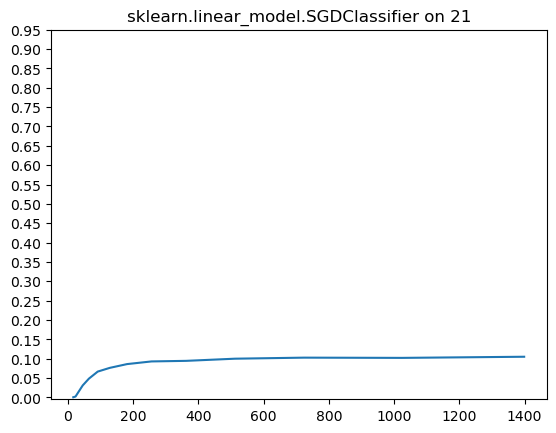

4it [00:07,  1.87s/it]

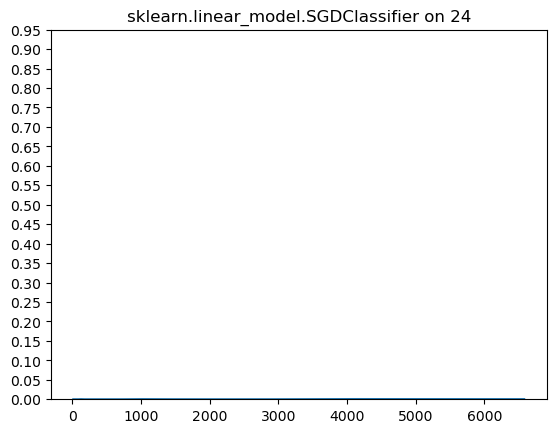

5it [00:09,  1.81s/it]

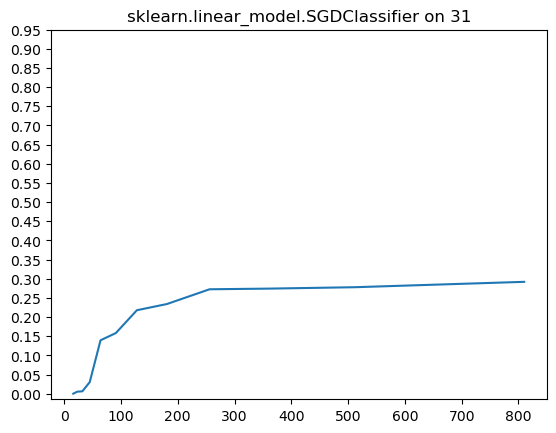

6it [00:10,  1.75s/it]

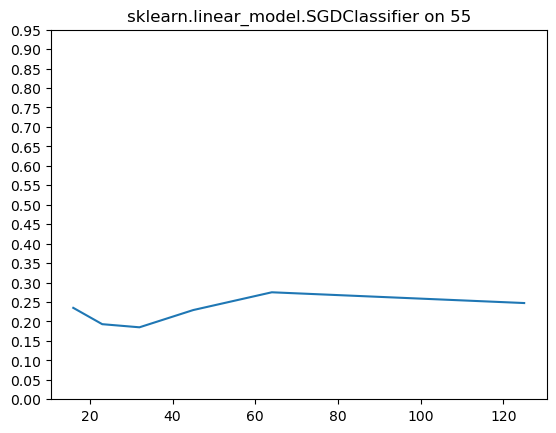

7it [00:12,  1.77s/it]

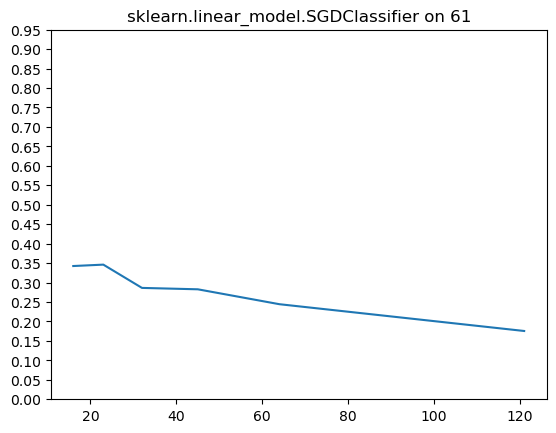

8it [00:14,  1.79s/it]

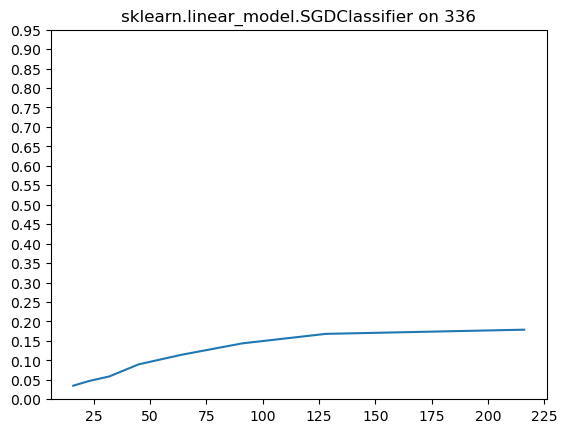

9it [00:16,  1.78s/it]

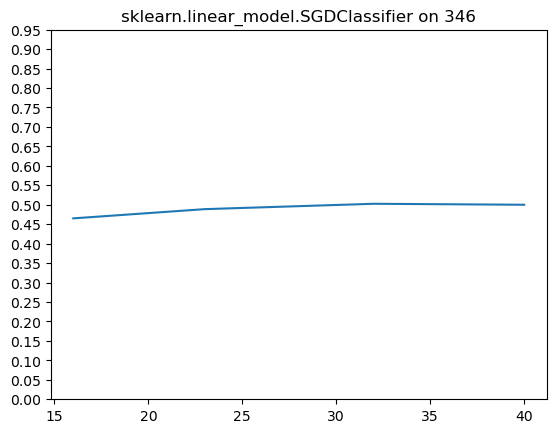

10it [00:17,  1.79s/it]

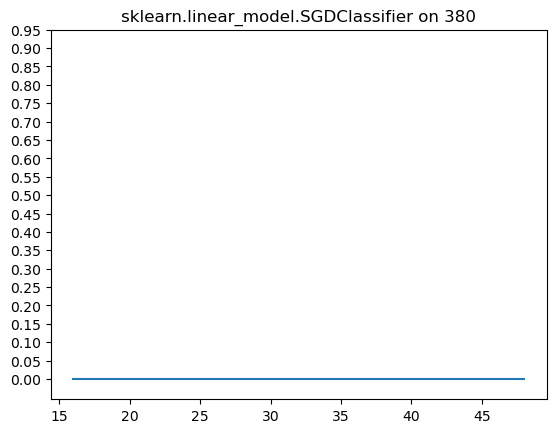

11it [00:19,  1.80s/it]

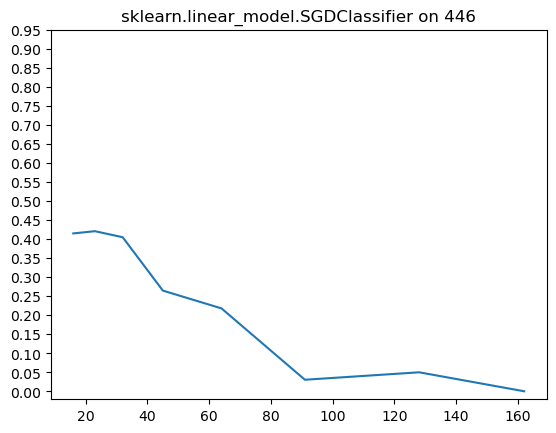

12it [00:21,  1.86s/it]

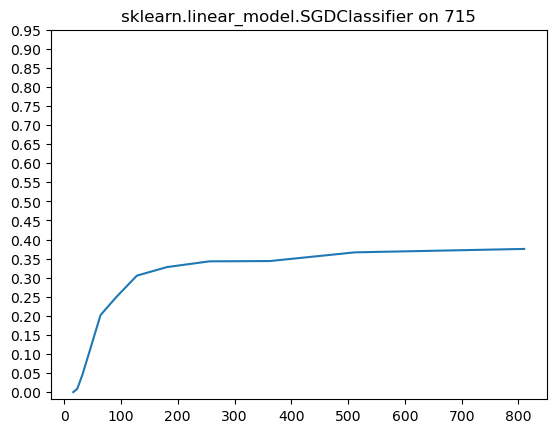

13it [00:23,  1.84s/it]

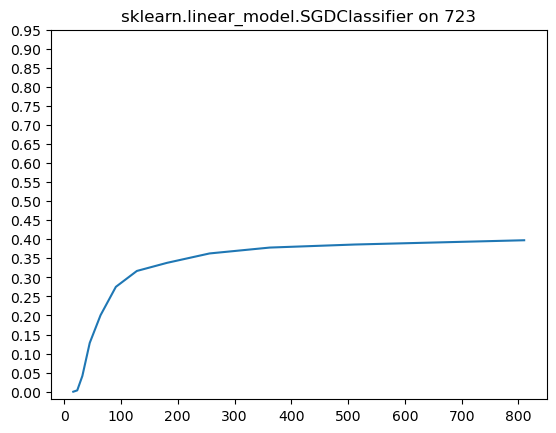

14it [00:25,  1.84s/it]

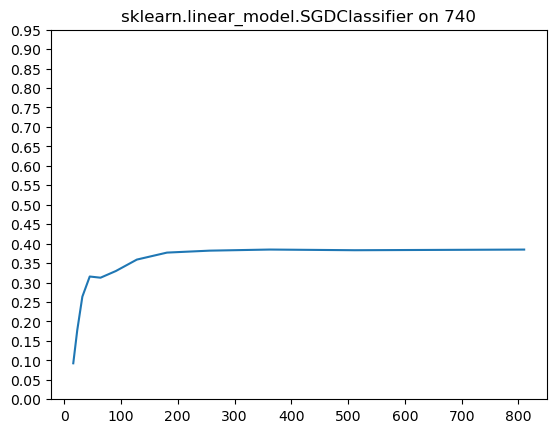

15it [00:27,  1.86s/it]

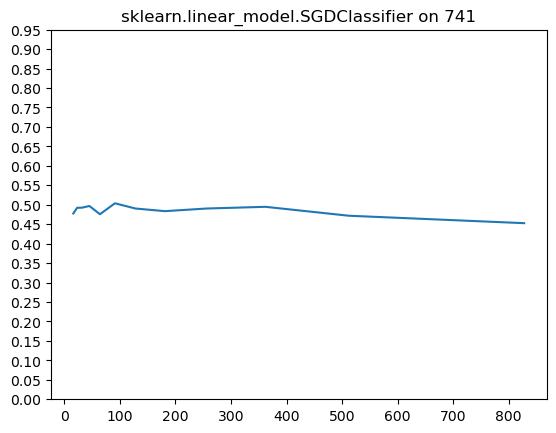

16it [00:29,  1.87s/it]

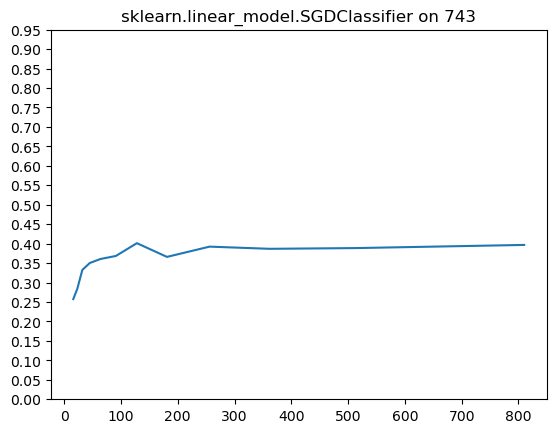

17it [00:31,  1.86s/it]

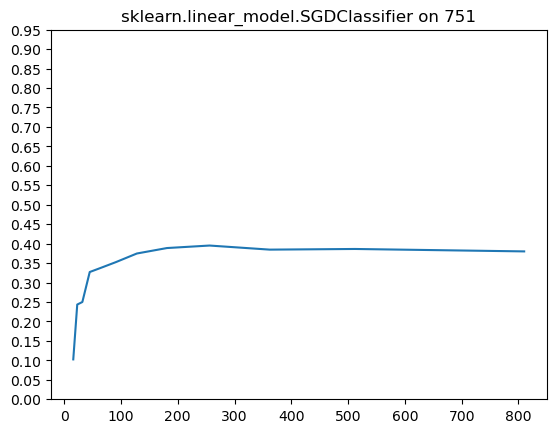

18it [00:32,  1.86s/it]

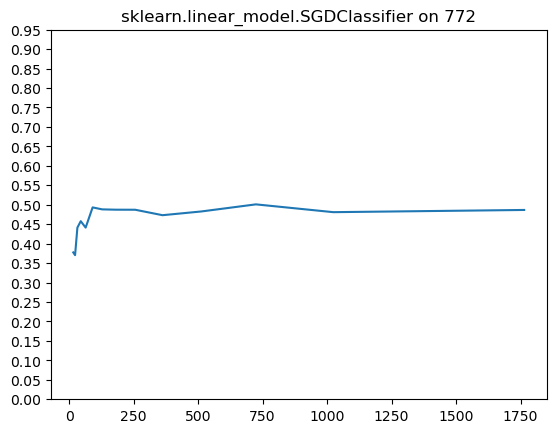

19it [00:34,  1.85s/it]

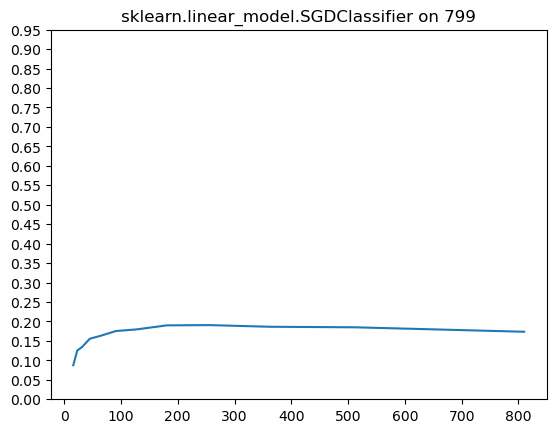

20it [00:36,  1.81s/it]

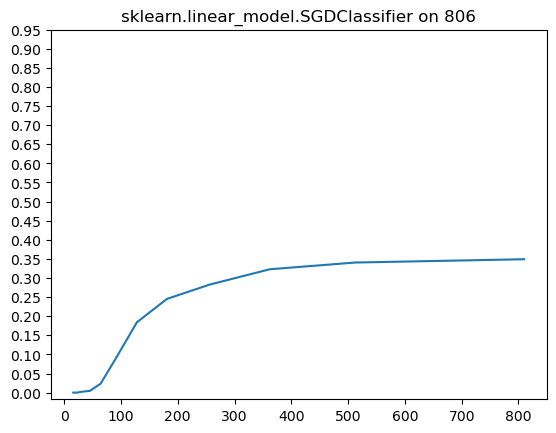

21it [00:38,  1.82s/it]

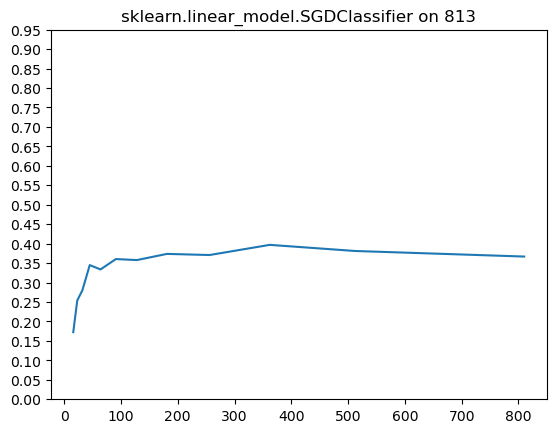

22it [00:40,  1.80s/it]

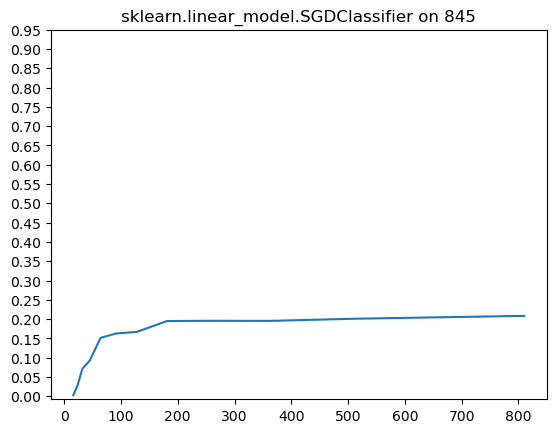

23it [00:41,  1.79s/it]

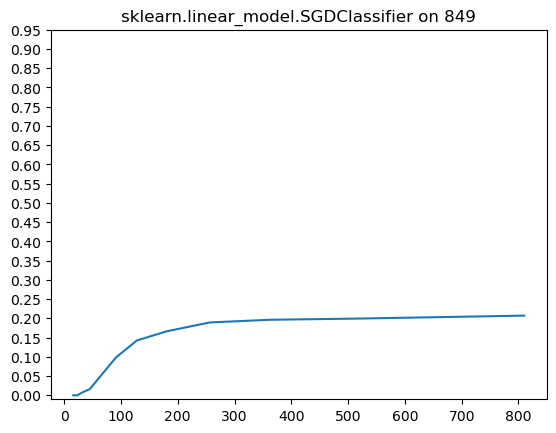

24it [00:43,  1.80s/it]

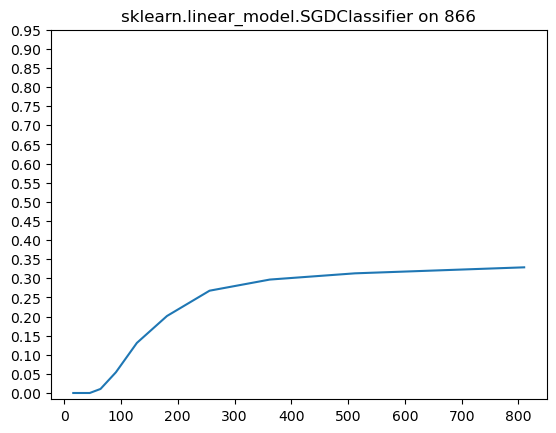

25it [00:45,  1.80s/it]

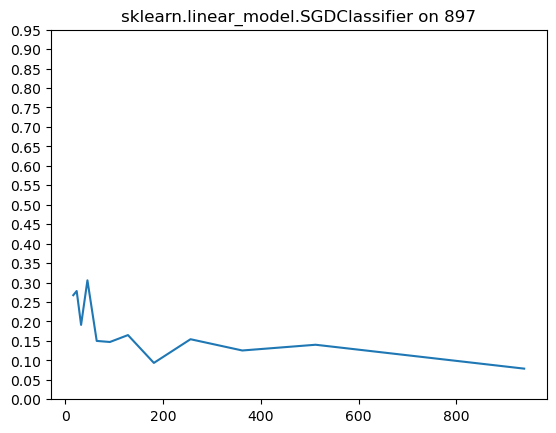

26it [00:47,  1.81s/it]

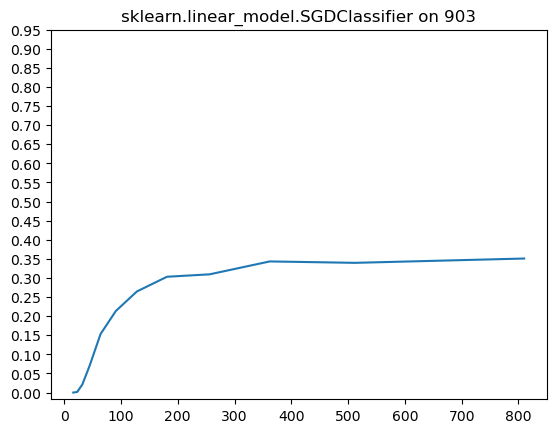

27it [00:49,  1.78s/it]

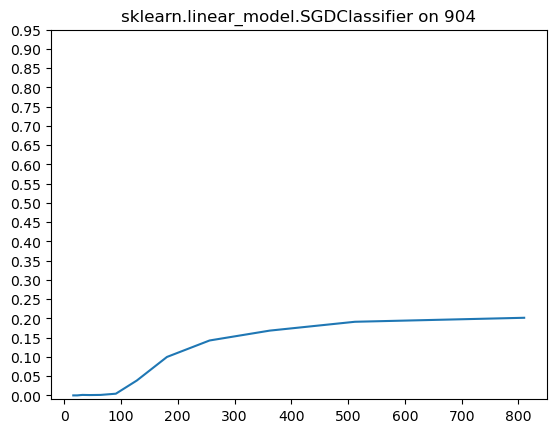

28it [00:50,  1.79s/it]

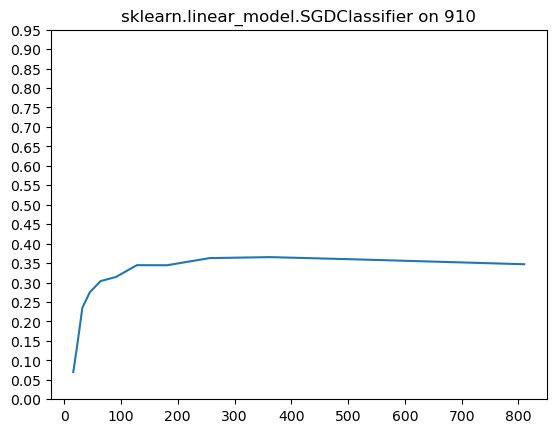

29it [00:52,  1.84s/it]

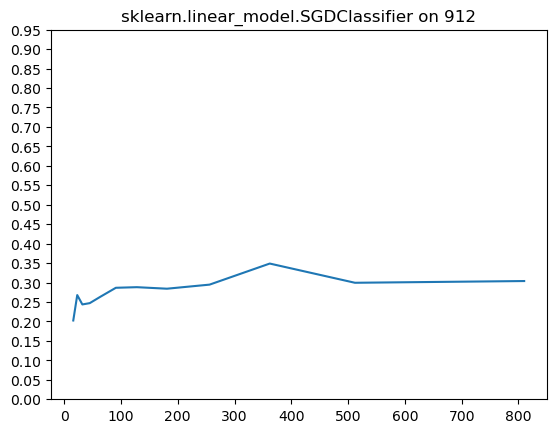

30it [00:54,  1.82s/it]

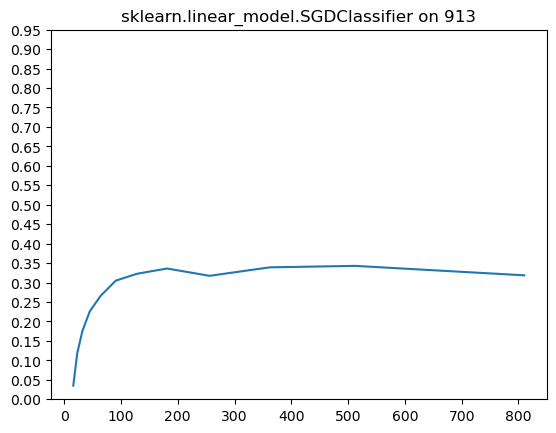

31it [00:56,  1.84s/it]

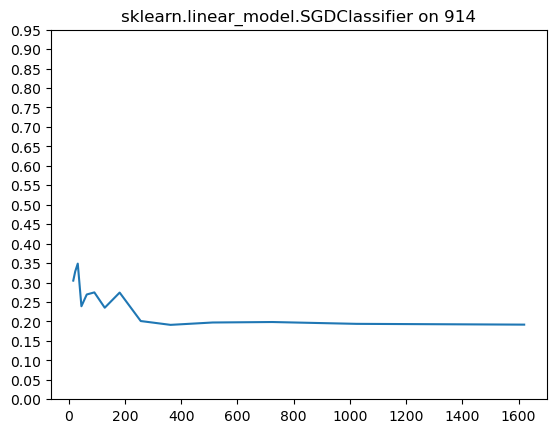

32it [00:58,  1.79s/it]

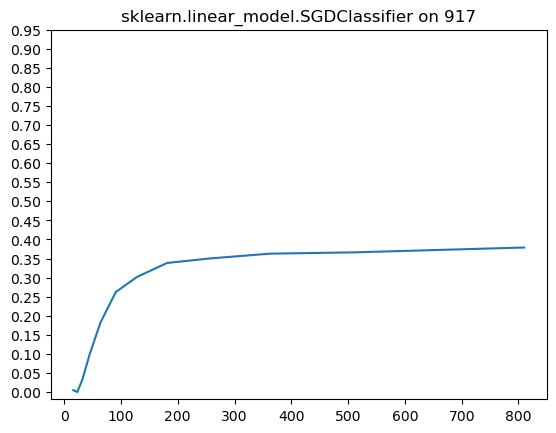

33it [00:59,  1.74s/it]

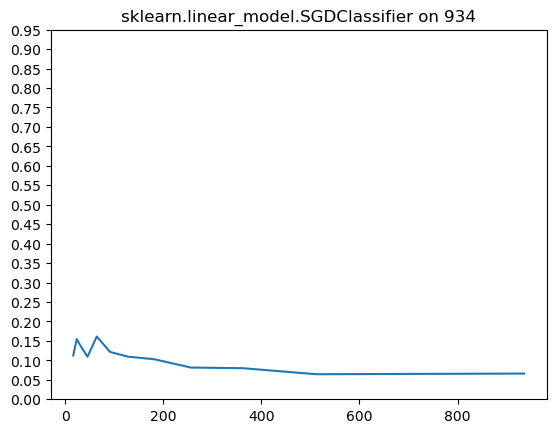

34it [01:01,  1.76s/it]

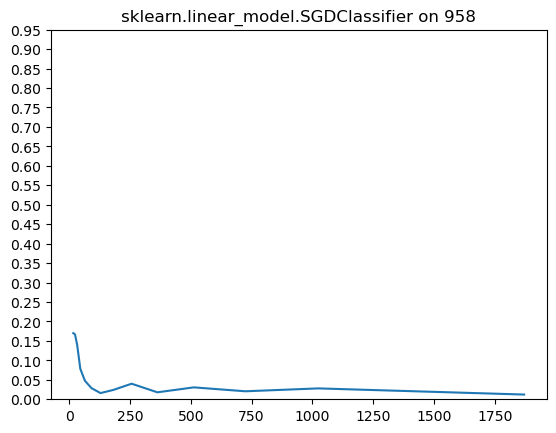

35it [01:03,  1.79s/it]

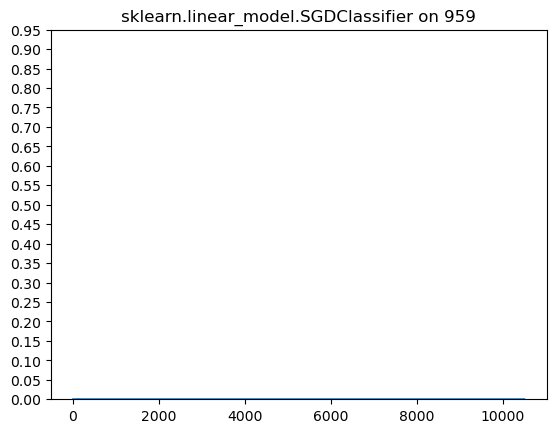

36it [01:05,  1.75s/it]

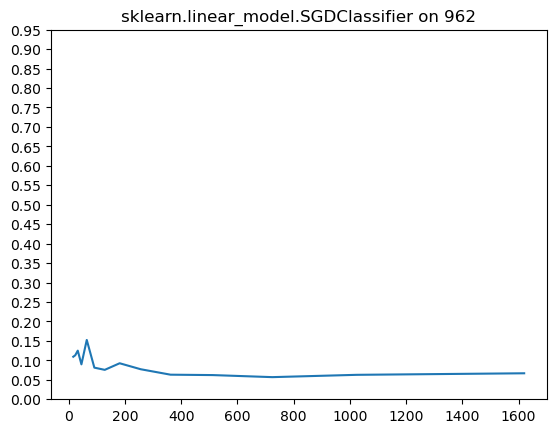

37it [01:06,  1.74s/it]

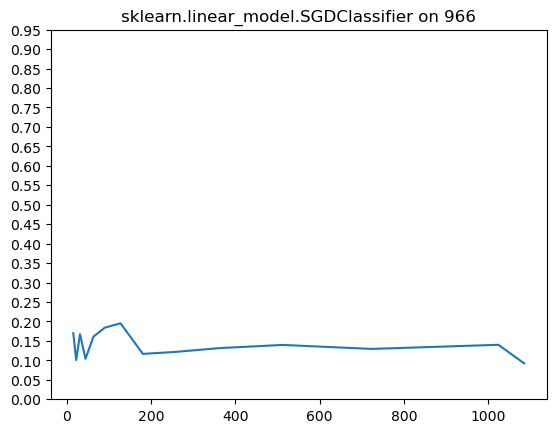

38it [01:08,  1.75s/it]

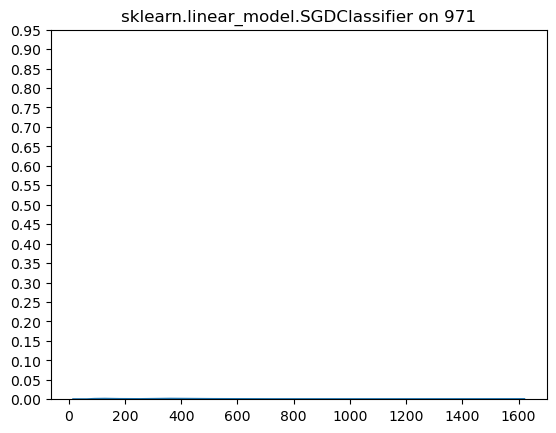

39it [01:10,  1.76s/it]

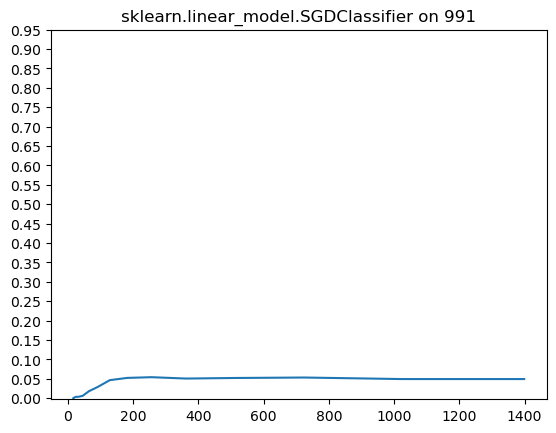

40it [01:12,  1.75s/it]

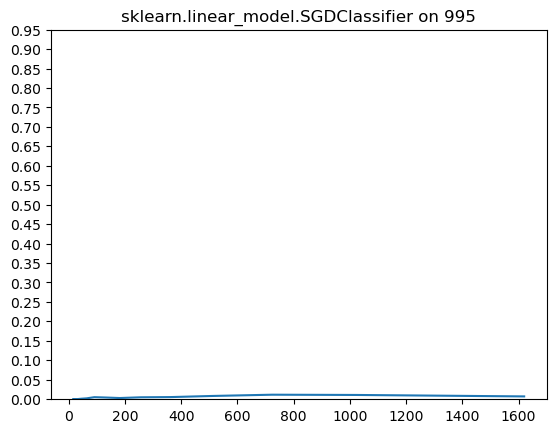

41it [01:13,  1.73s/it]

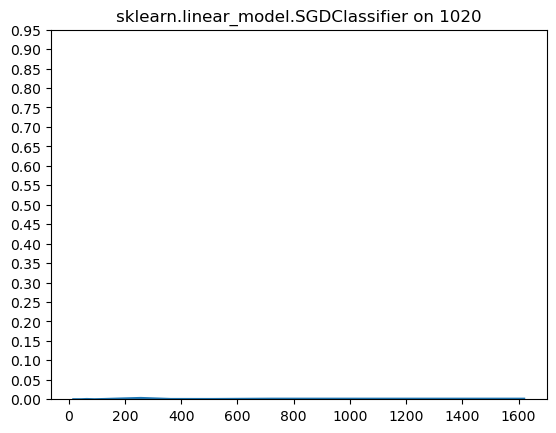

42it [01:15,  1.77s/it]

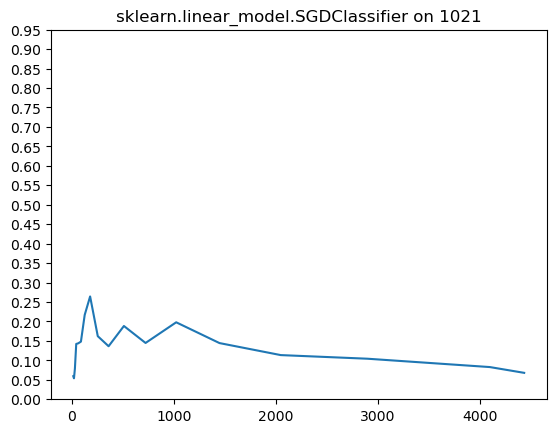

43it [01:17,  1.75s/it]

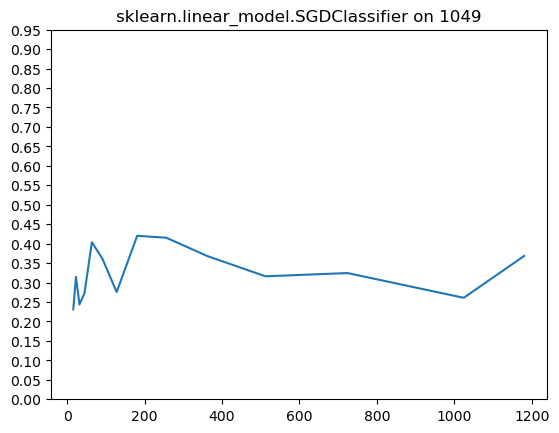

44it [01:18,  1.72s/it]

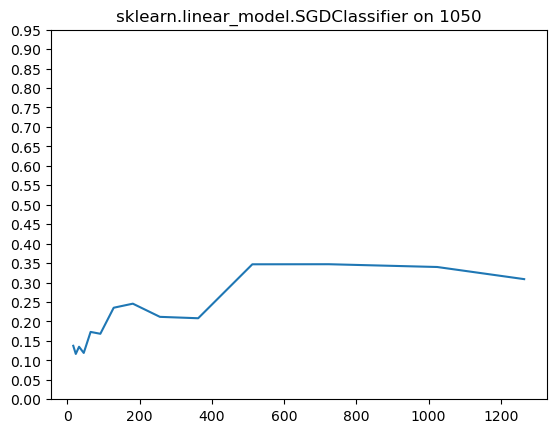

45it [01:20,  1.79s/it]

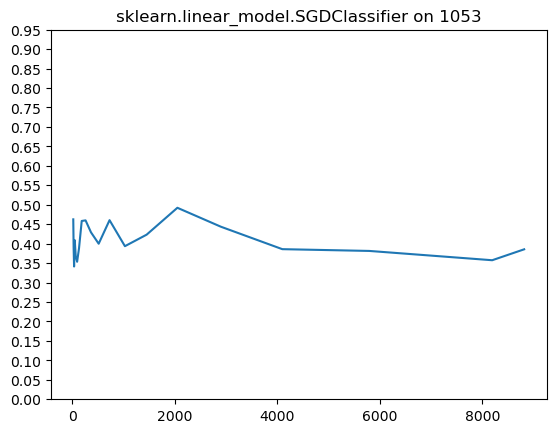

46it [01:22,  1.74s/it]

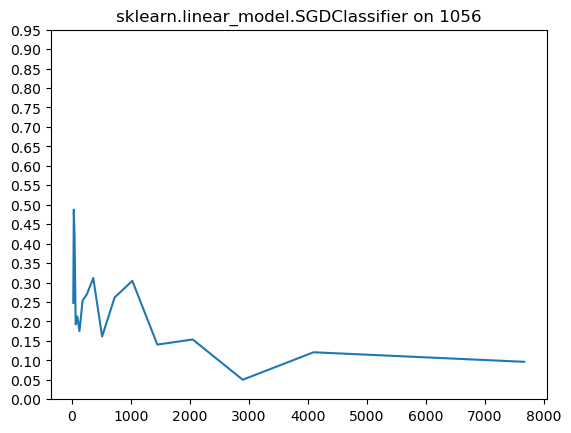

47it [01:24,  1.75s/it]

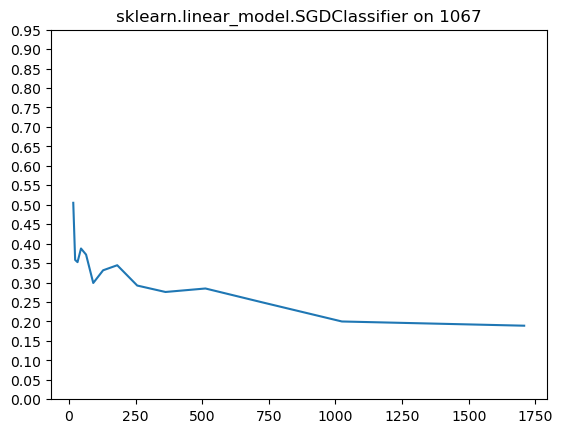

48it [01:25,  1.69s/it]

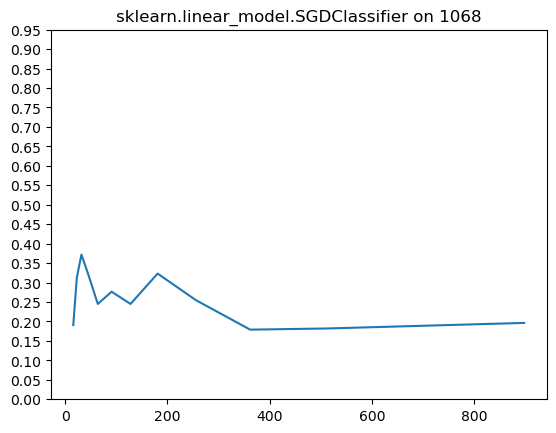

49it [01:27,  1.68s/it]

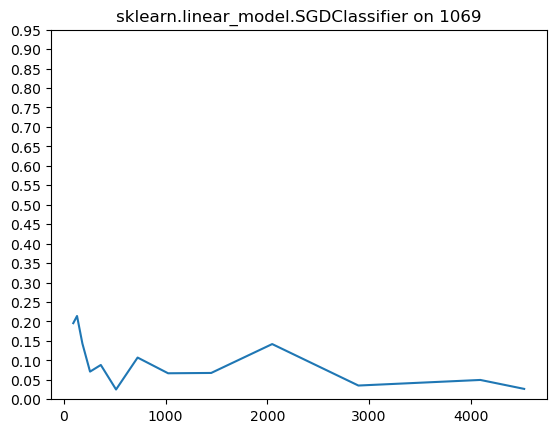

50it [01:29,  1.67s/it]

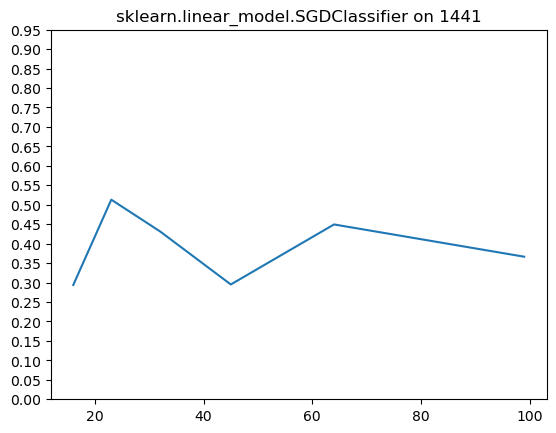

51it [01:30,  1.72s/it]

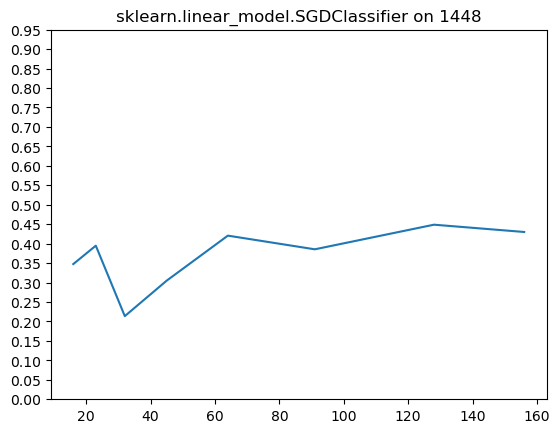

52it [01:32,  1.76s/it]

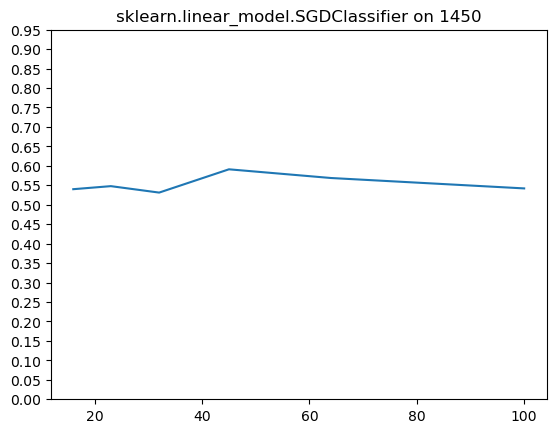

53it [01:34,  1.71s/it]

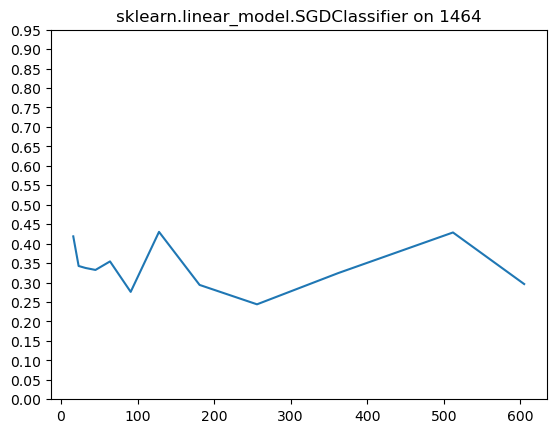

54it [01:36,  1.70s/it]

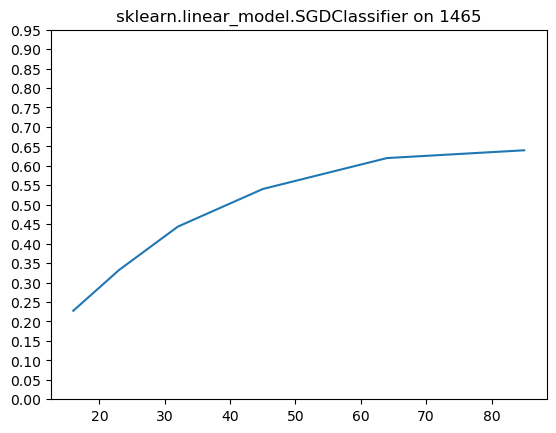

55it [01:37,  1.71s/it]

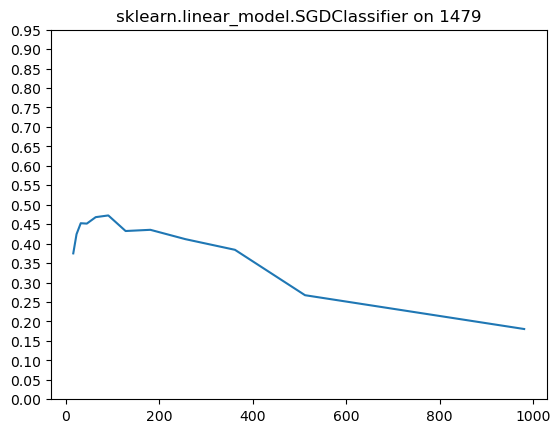

56it [01:39,  1.72s/it]

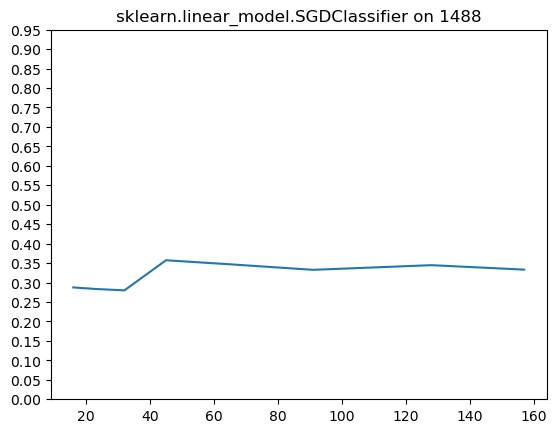

57it [01:41,  1.73s/it]

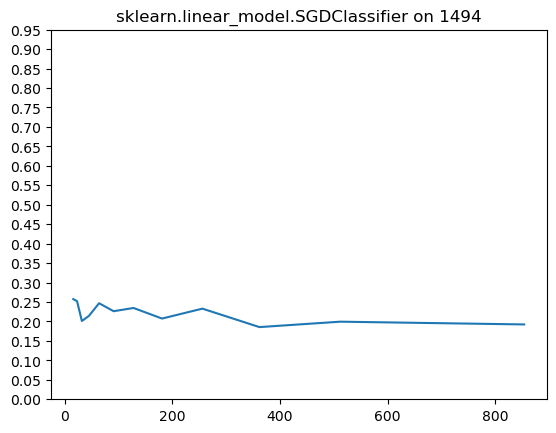

58it [01:43,  1.75s/it]

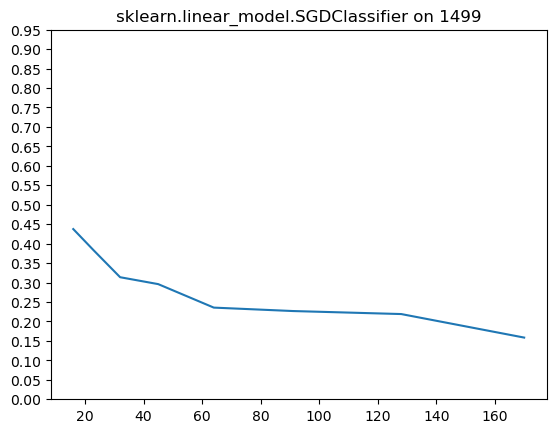

59it [01:44,  1.76s/it]

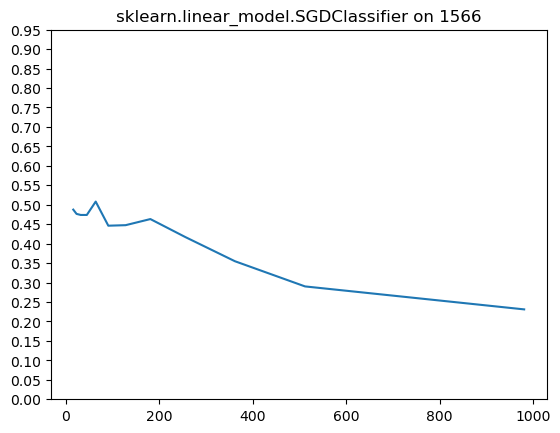

60it [01:46,  1.73s/it]

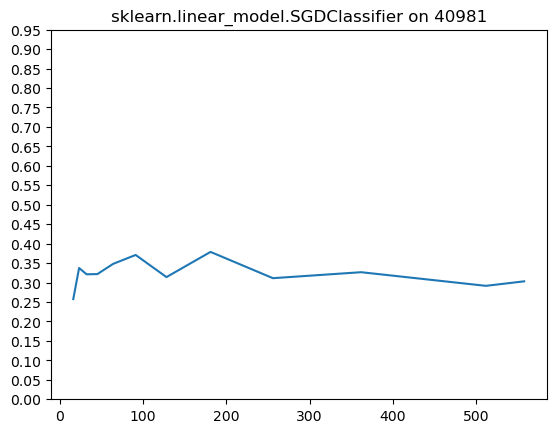

61it [01:48,  1.71s/it]

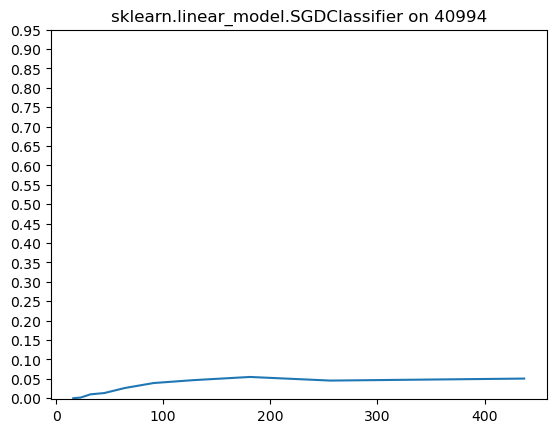

62it [01:50,  1.78s/it]
0it [00:00, ?it/s]

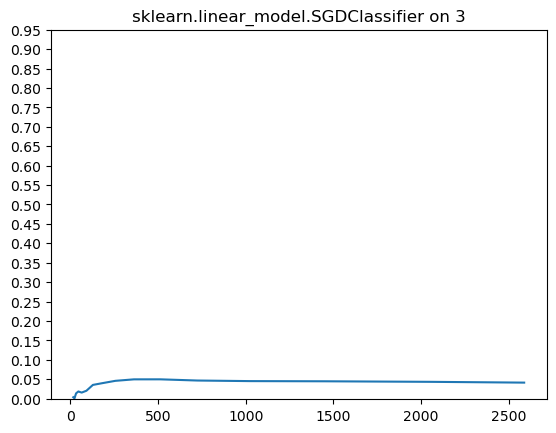

1it [00:01,  1.78s/it]

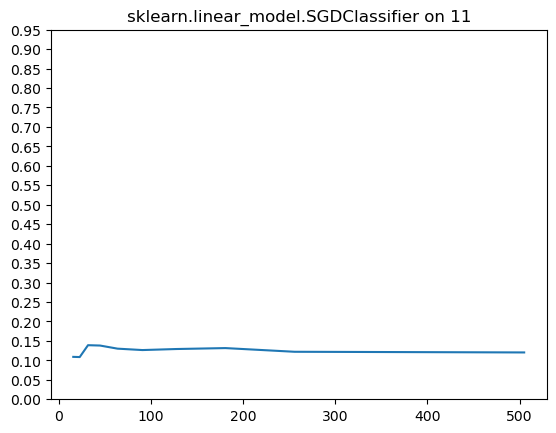

2it [00:03,  1.74s/it]

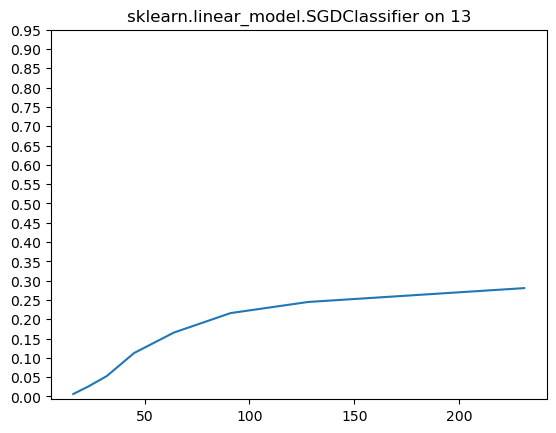

3it [00:05,  1.71s/it]

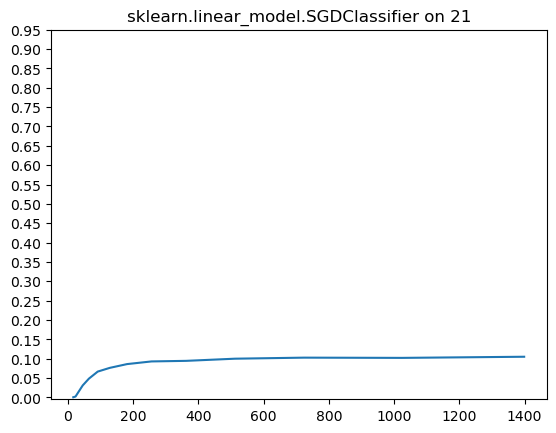

4it [00:06,  1.73s/it]

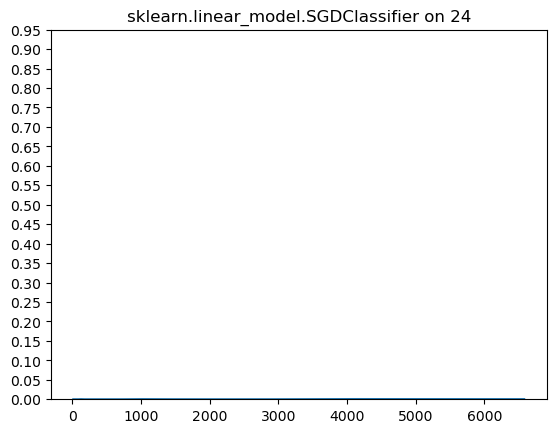

5it [00:08,  1.75s/it]

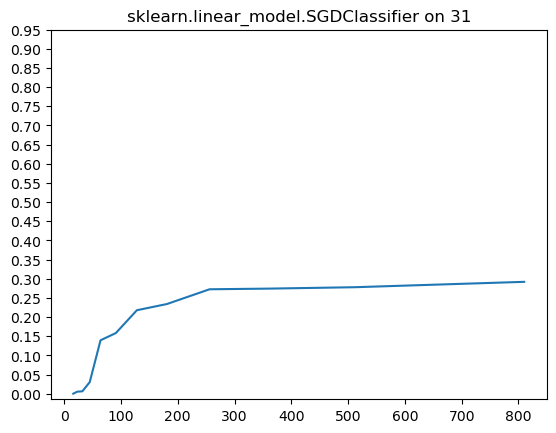

6it [00:10,  1.79s/it]

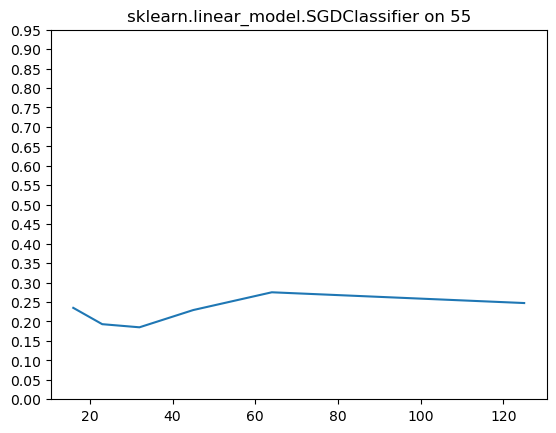

7it [00:12,  1.79s/it]

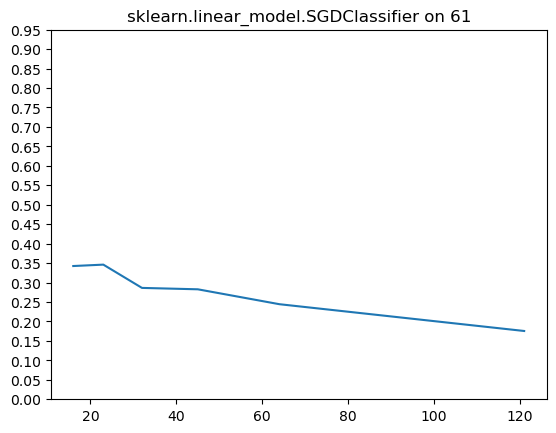

8it [00:14,  1.75s/it]

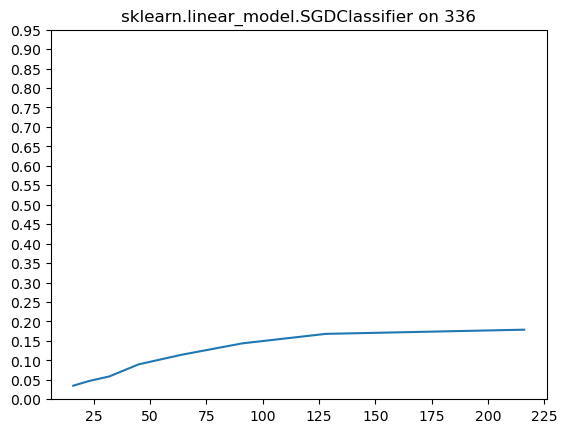

9it [00:15,  1.76s/it]

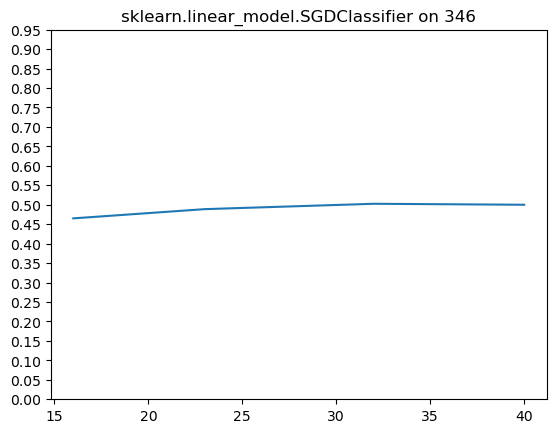

10it [00:17,  1.72s/it]

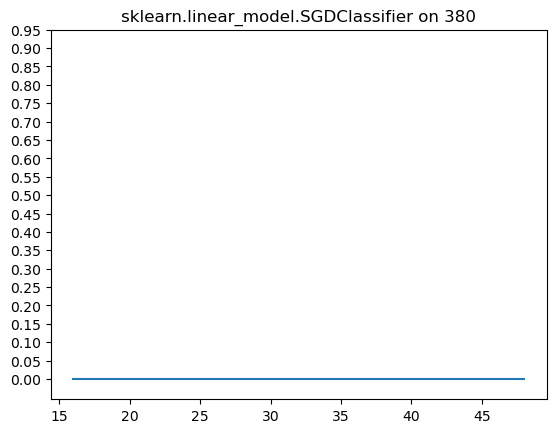

11it [00:19,  1.68s/it]

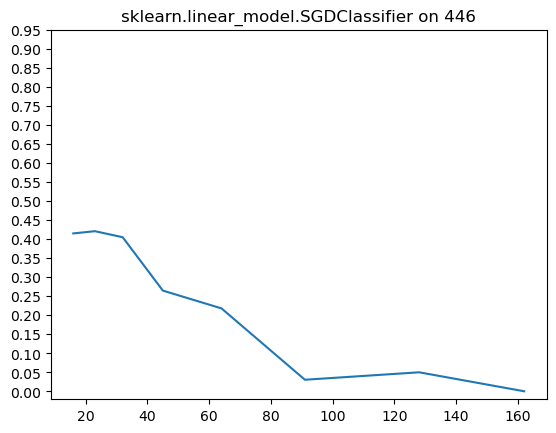

12it [00:20,  1.68s/it]

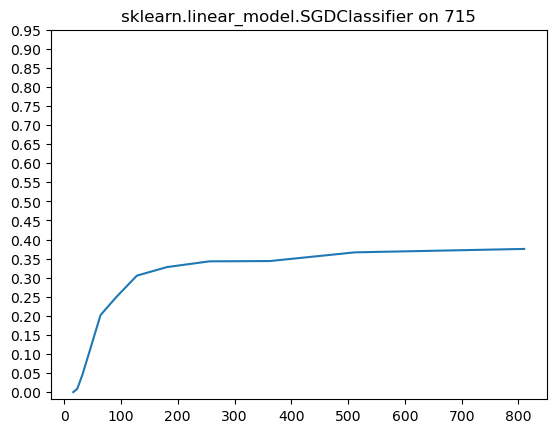

13it [00:22,  1.70s/it]

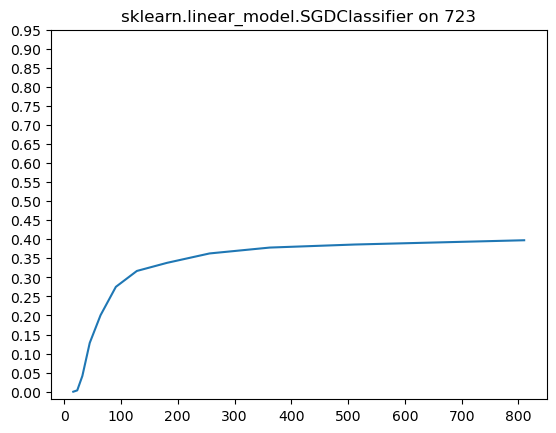

14it [00:24,  1.69s/it]

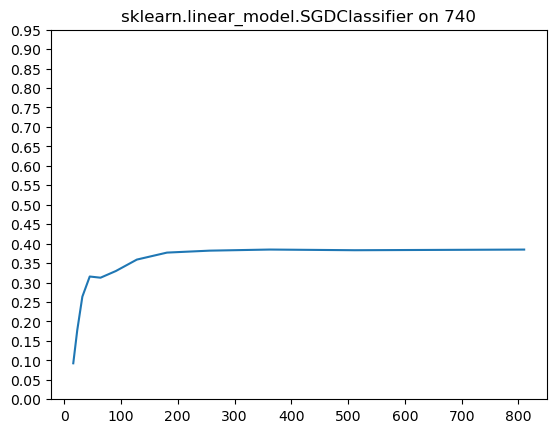

15it [00:25,  1.71s/it]

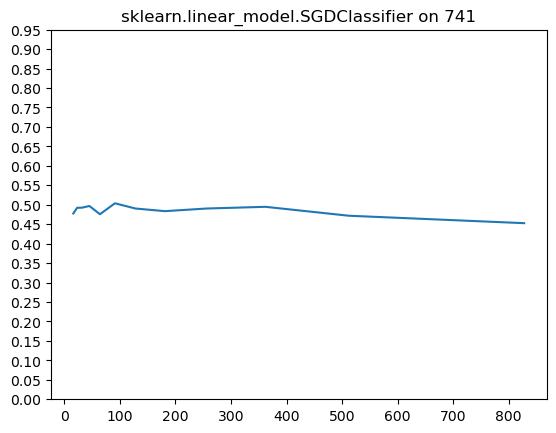

16it [00:27,  1.69s/it]

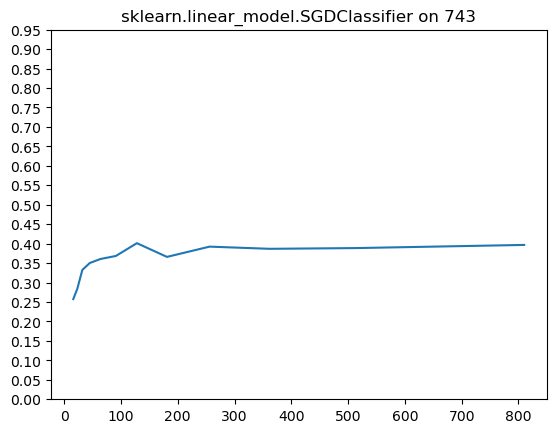

17it [00:29,  1.67s/it]

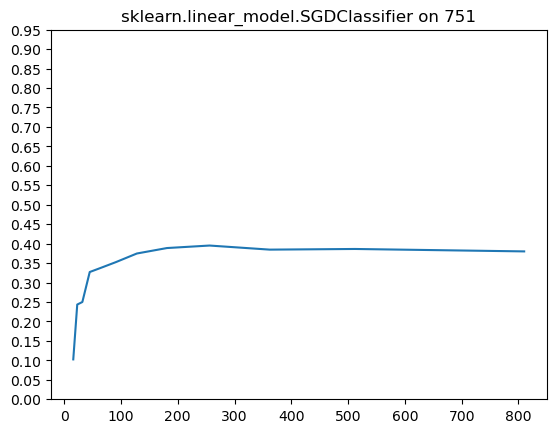

18it [00:30,  1.68s/it]

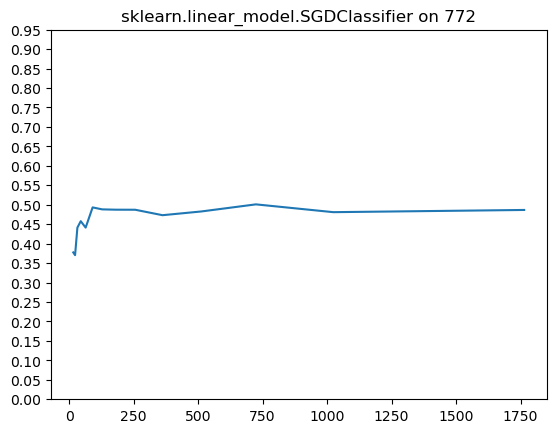

19it [00:32,  1.74s/it]

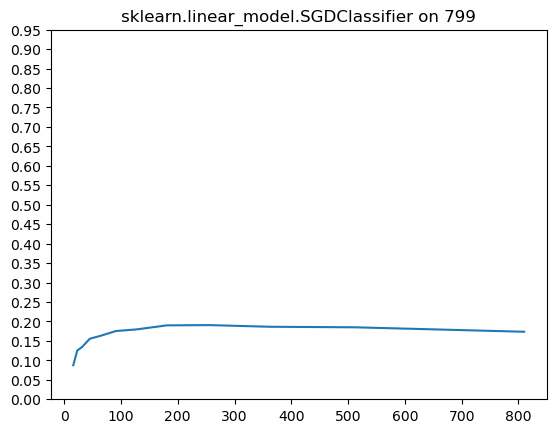

20it [00:34,  1.76s/it]

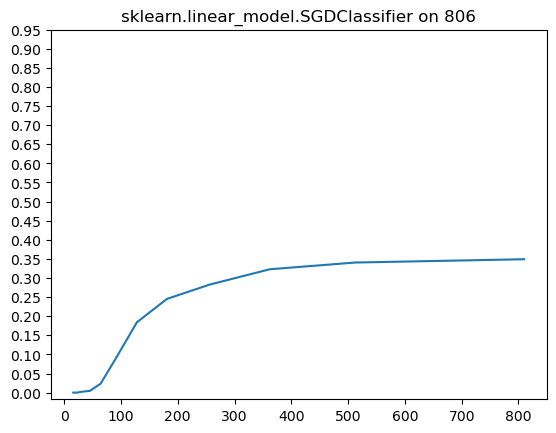

21it [00:36,  1.79s/it]

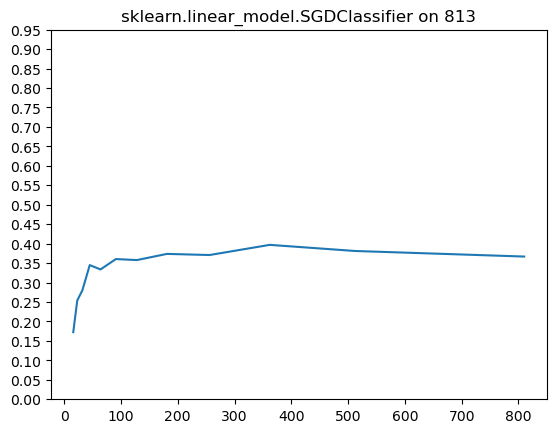

22it [00:38,  1.77s/it]

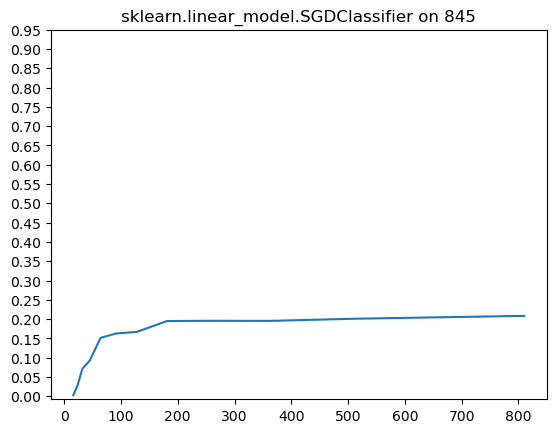

23it [00:39,  1.75s/it]

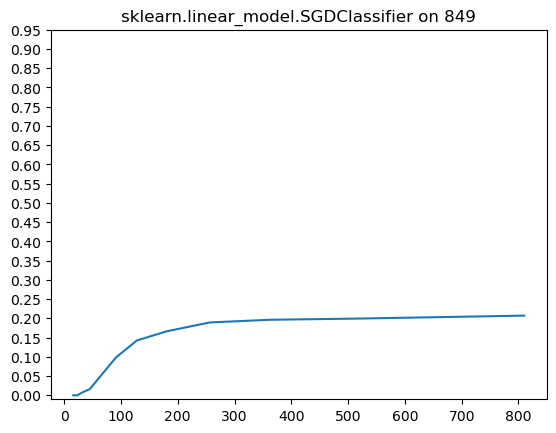

24it [00:41,  1.74s/it]

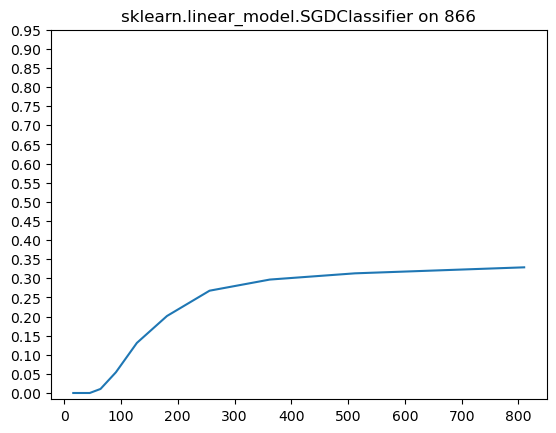

25it [00:43,  1.72s/it]

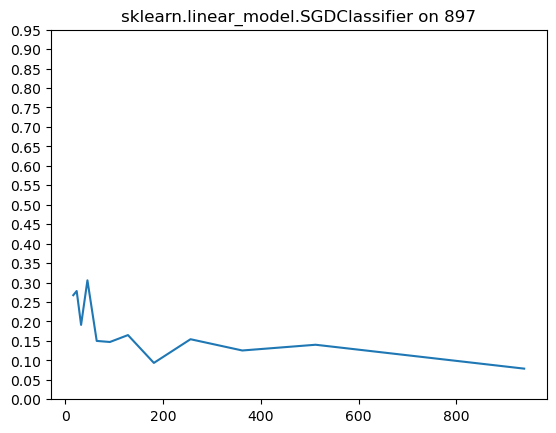

26it [00:44,  1.69s/it]

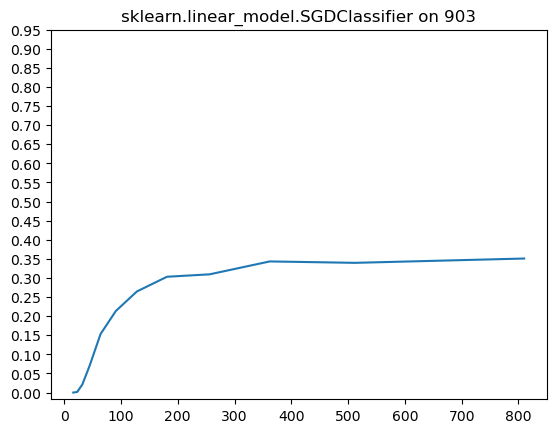

27it [00:46,  1.68s/it]

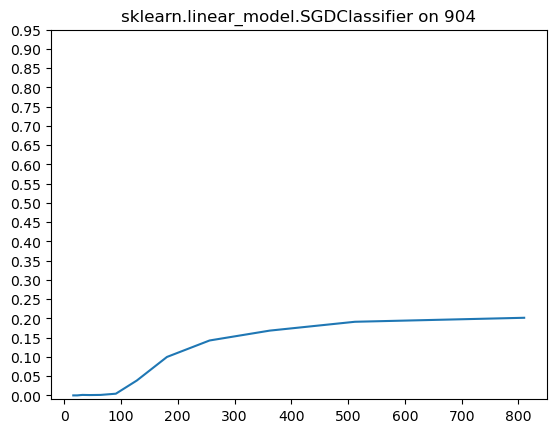

28it [00:48,  1.68s/it]

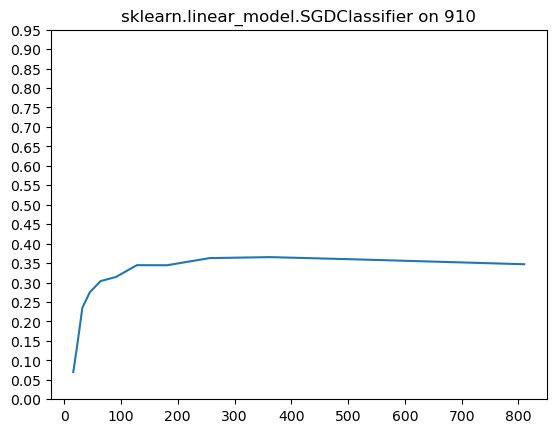

29it [00:49,  1.68s/it]

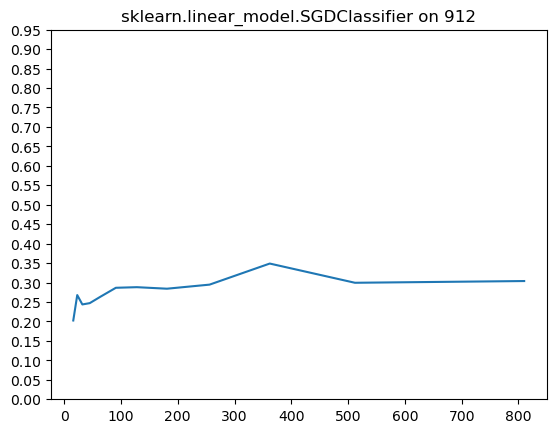

30it [00:51,  1.68s/it]

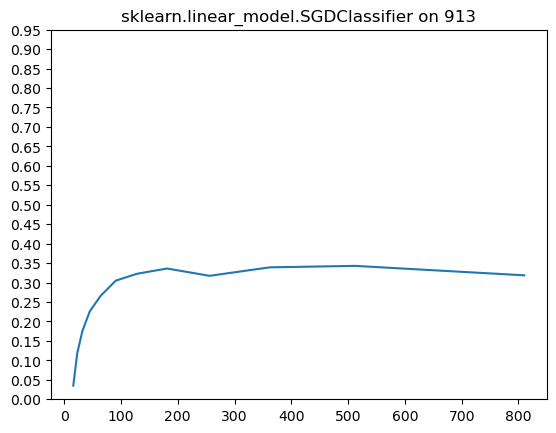

31it [00:53,  1.73s/it]

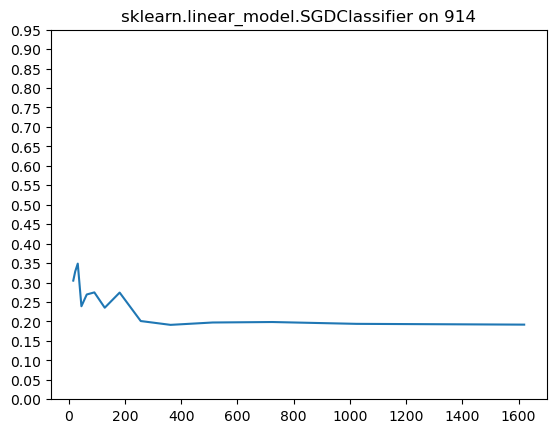

32it [00:54,  1.69s/it]

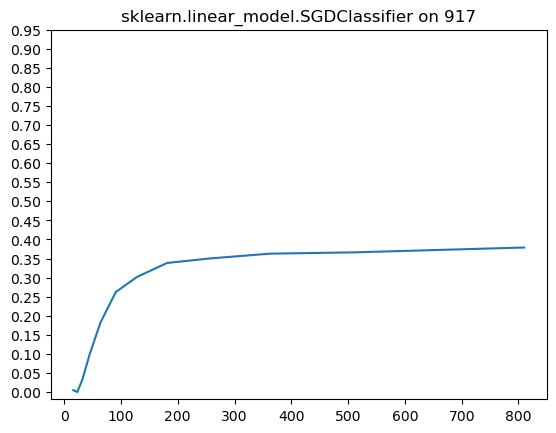

33it [00:56,  1.68s/it]

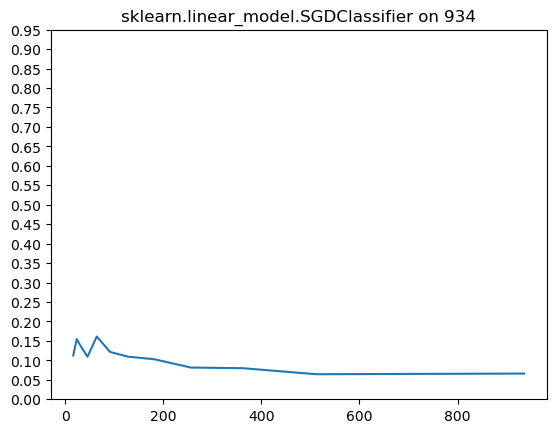

34it [00:58,  1.71s/it]

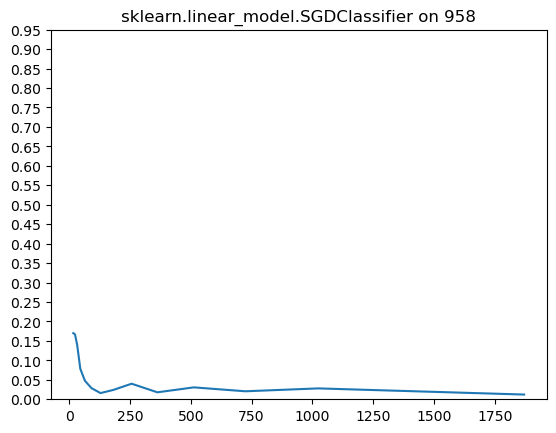

35it [01:00,  1.75s/it]

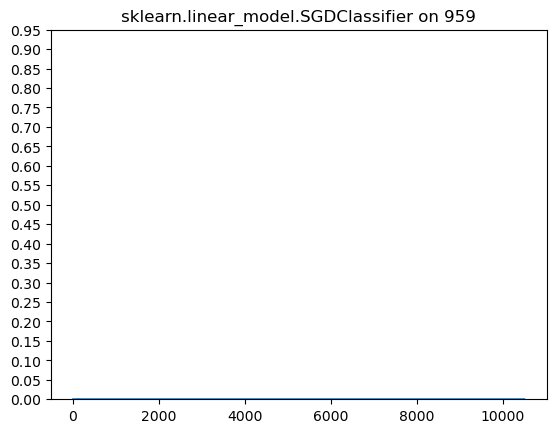

36it [01:01,  1.71s/it]

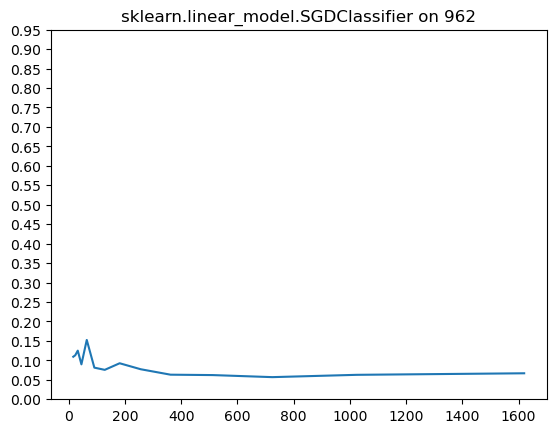

37it [01:03,  1.72s/it]

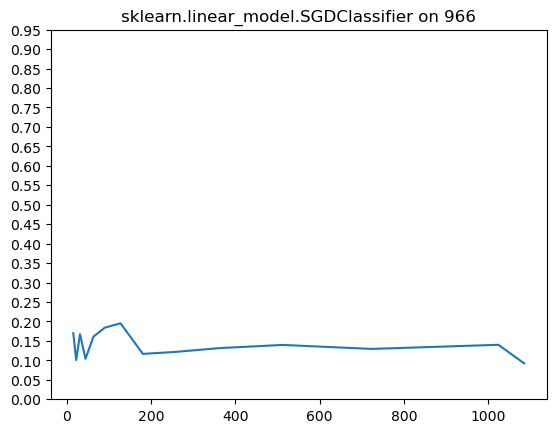

38it [01:05,  1.79s/it]

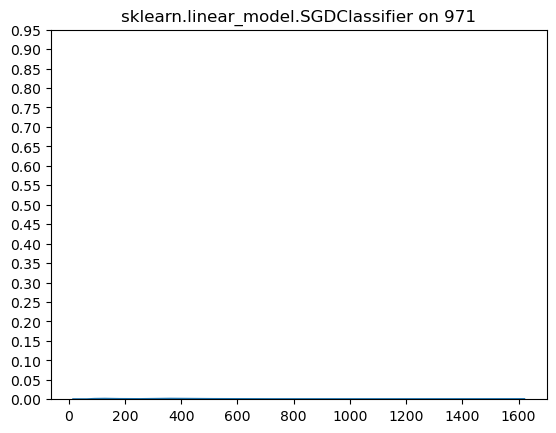

39it [01:07,  1.74s/it]

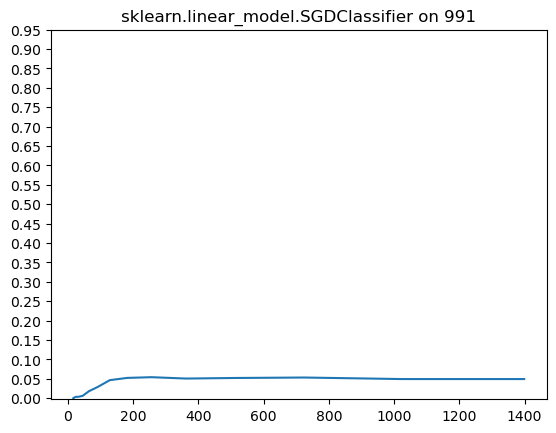

40it [01:09,  1.76s/it]

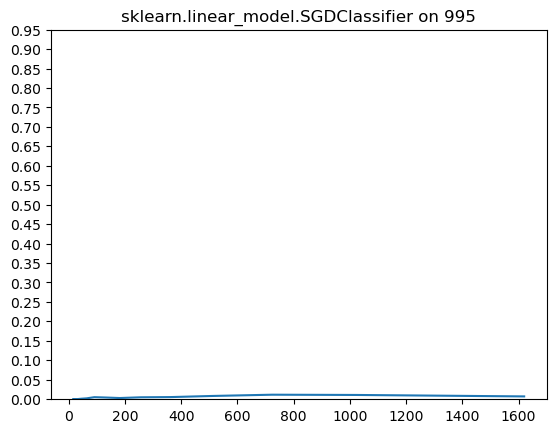

41it [01:10,  1.80s/it]

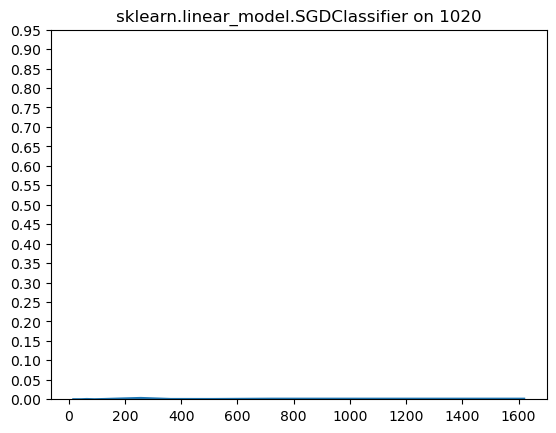

42it [01:12,  1.82s/it]

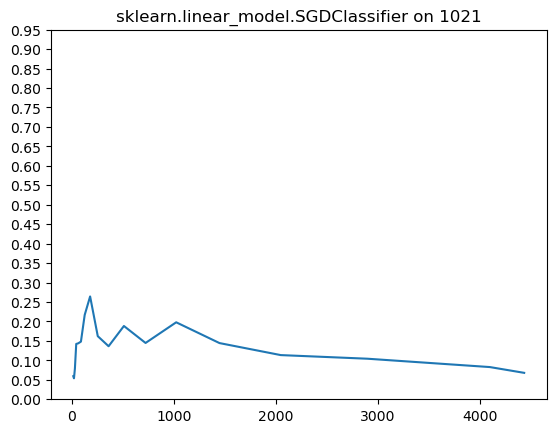

43it [01:14,  1.84s/it]

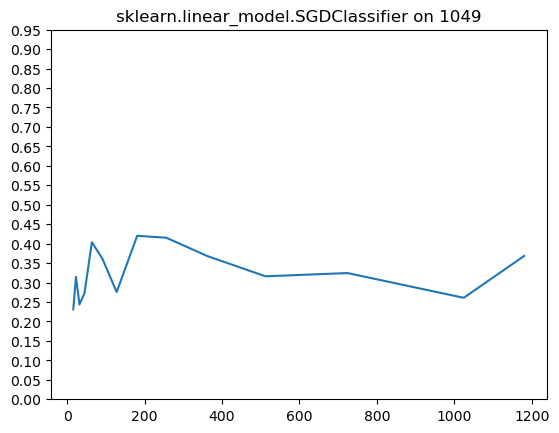

44it [01:16,  1.88s/it]

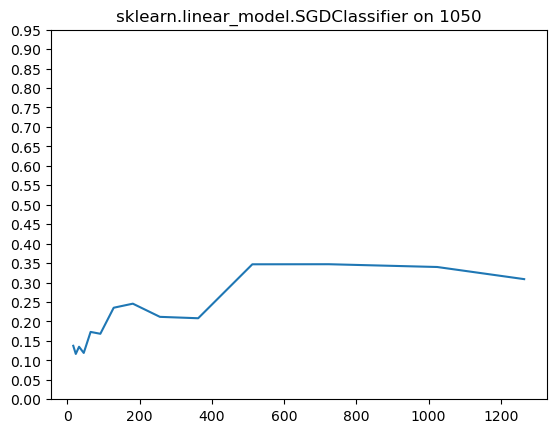

45it [01:18,  1.84s/it]

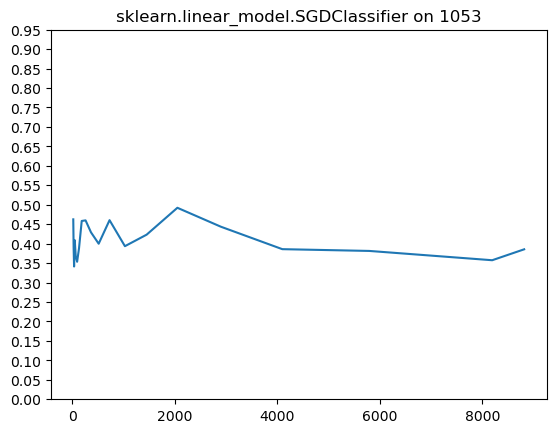

46it [01:20,  1.78s/it]

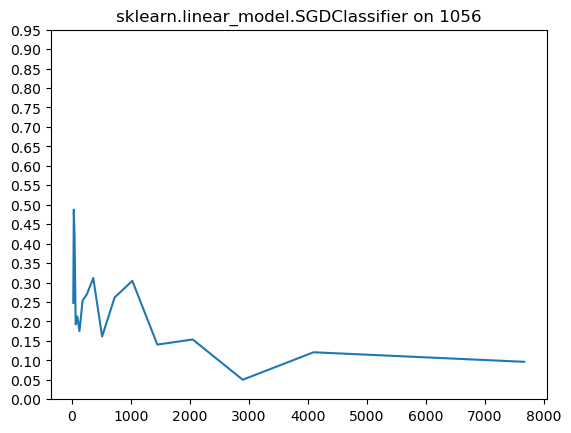

47it [01:21,  1.77s/it]

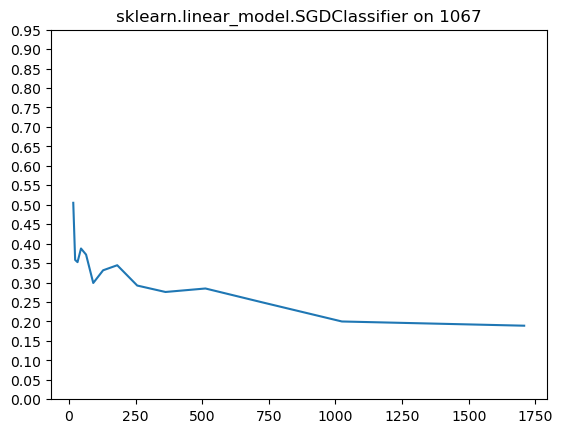

48it [01:23,  1.74s/it]

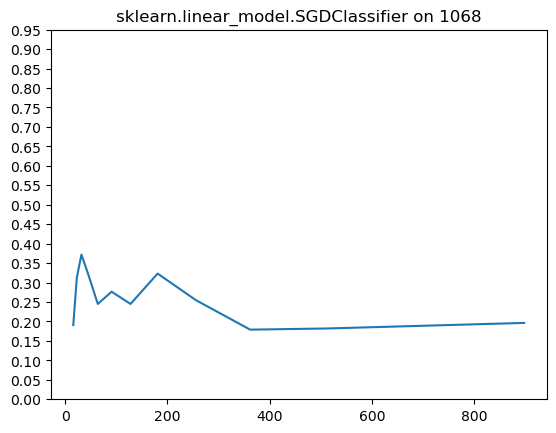

49it [01:25,  1.70s/it]

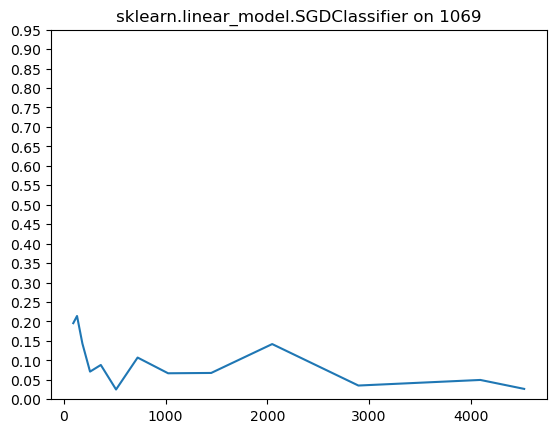

50it [01:26,  1.72s/it]

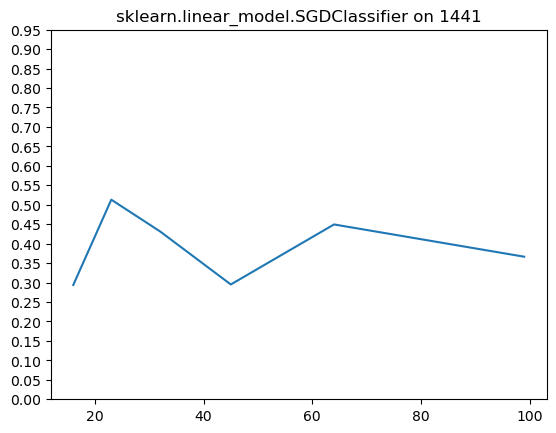

51it [01:28,  1.78s/it]

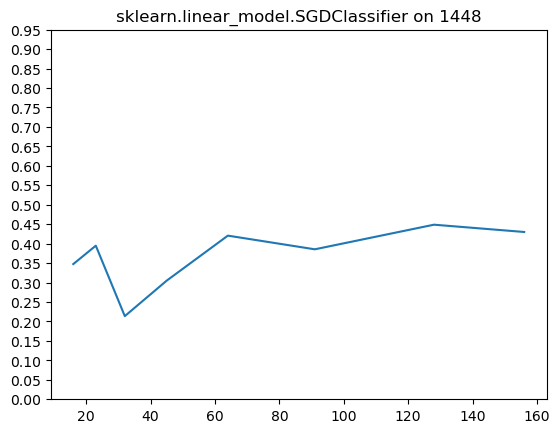

52it [01:30,  1.78s/it]

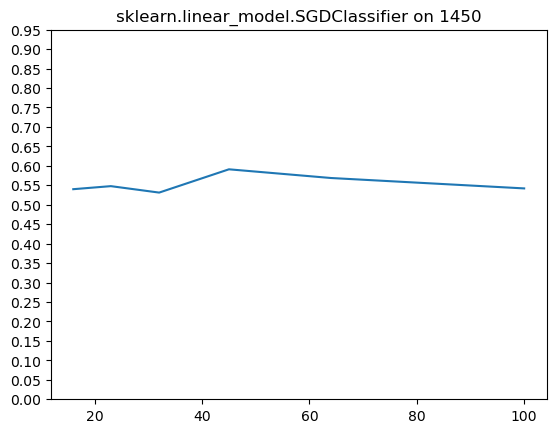

53it [01:32,  1.79s/it]

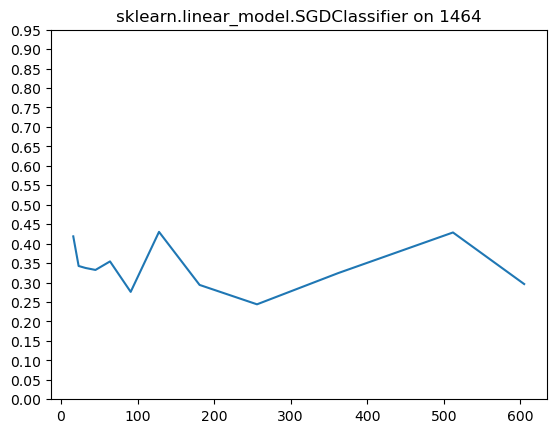

54it [01:34,  1.76s/it]

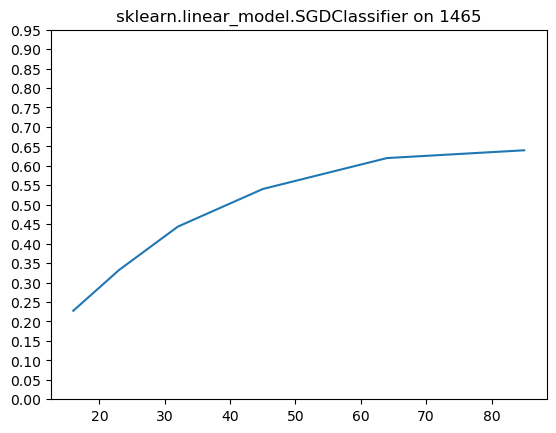

55it [01:35,  1.73s/it]

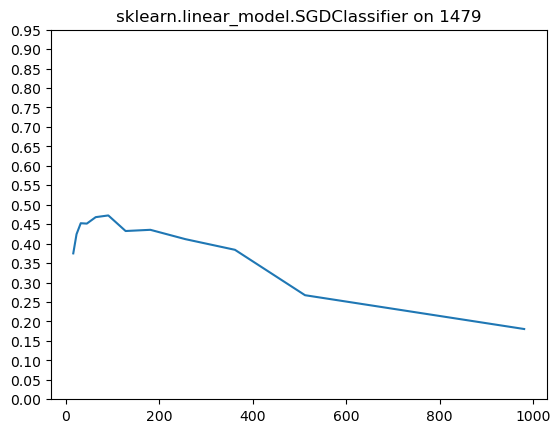

56it [01:37,  1.78s/it]

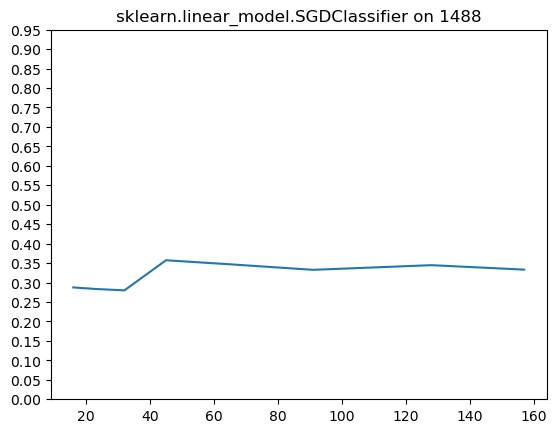

57it [01:39,  1.79s/it]

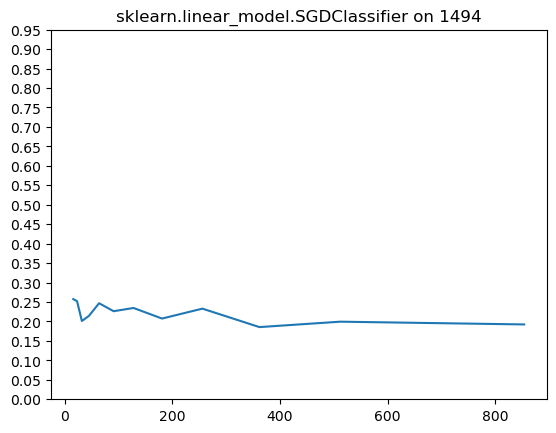

58it [01:41,  1.80s/it]

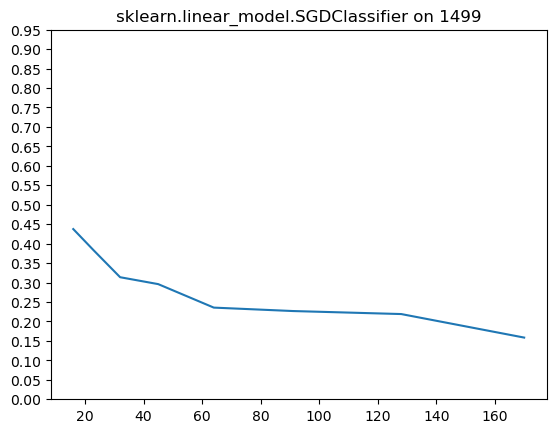

59it [01:42,  1.73s/it]

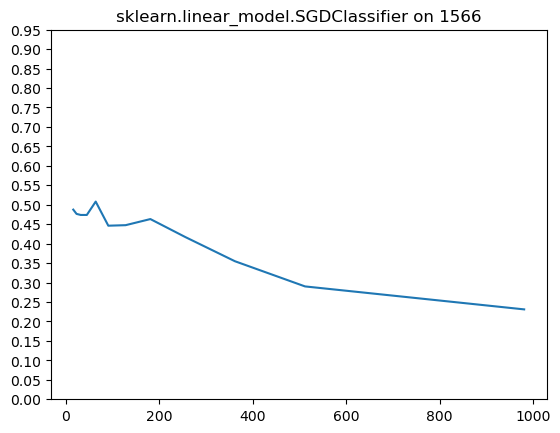

60it [01:44,  1.71s/it]

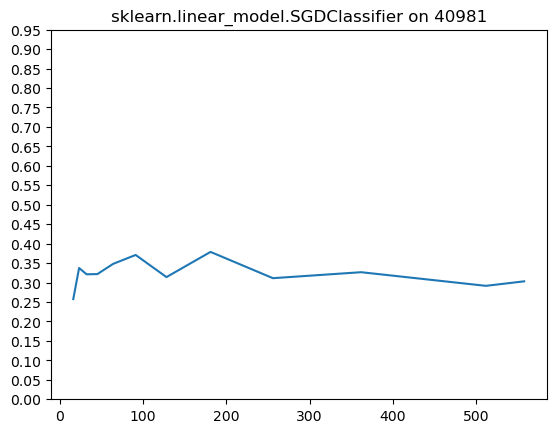

61it [01:46,  1.73s/it]

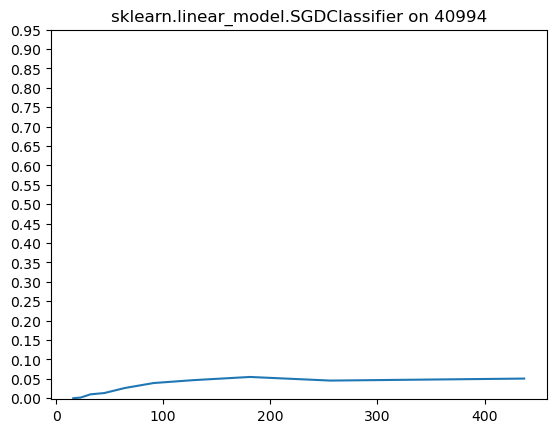

62it [01:47,  1.74s/it]
0it [00:00, ?it/s]

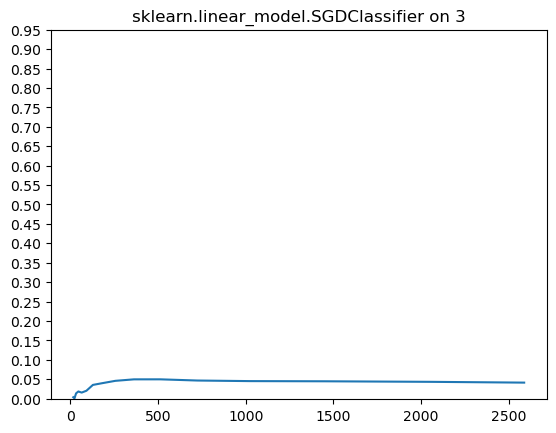

1it [00:01,  1.77s/it]

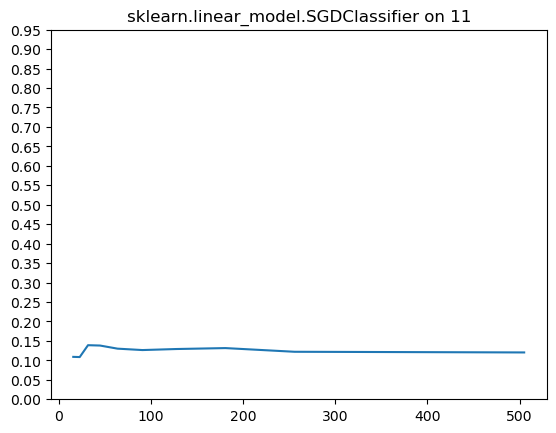

2it [00:03,  1.75s/it]

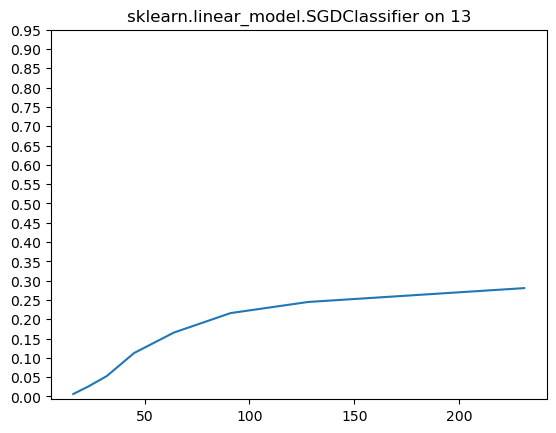

3it [00:05,  1.76s/it]

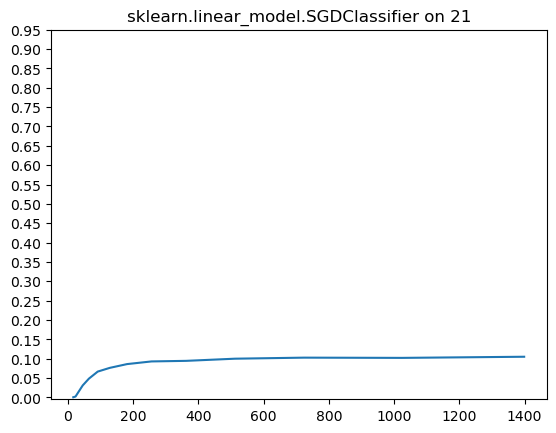

4it [00:07,  1.77s/it]

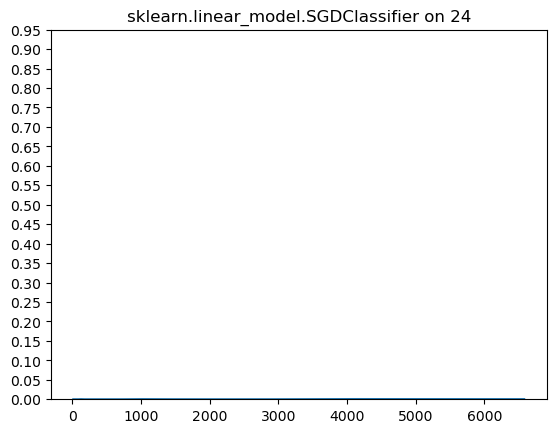

5it [00:08,  1.73s/it]

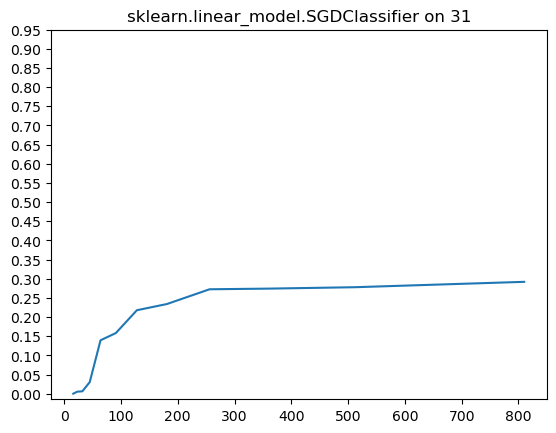

6it [00:10,  1.68s/it]

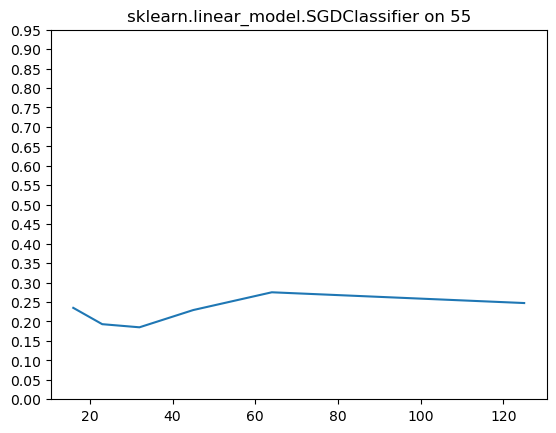

7it [00:12,  1.69s/it]

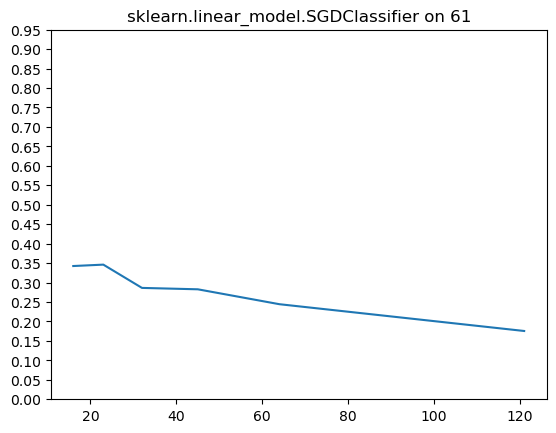

8it [00:13,  1.70s/it]

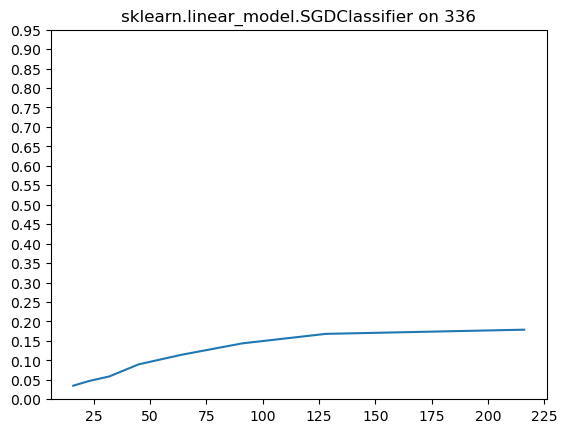

9it [00:15,  1.71s/it]

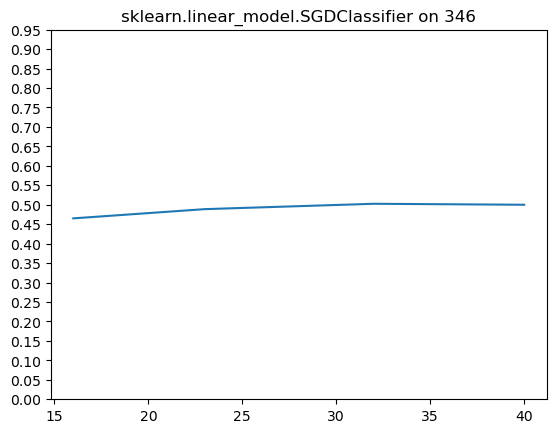

10it [00:17,  1.71s/it]

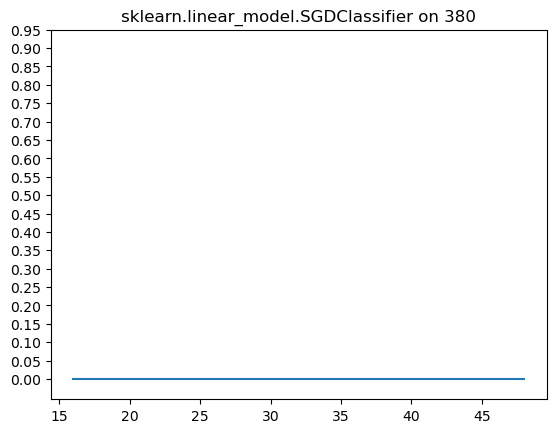

11it [00:18,  1.74s/it]

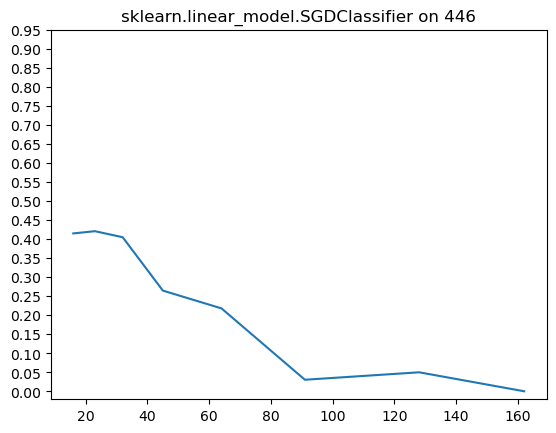

12it [00:20,  1.78s/it]

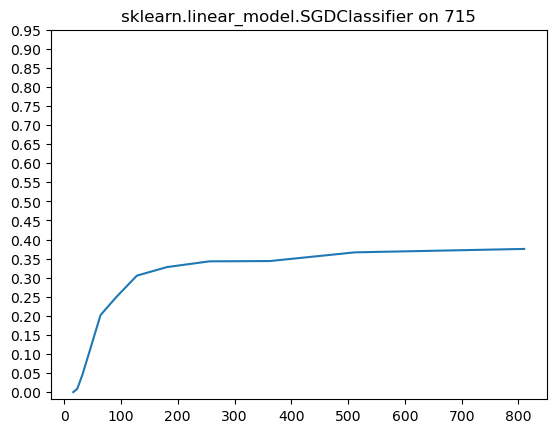

13it [00:22,  1.78s/it]

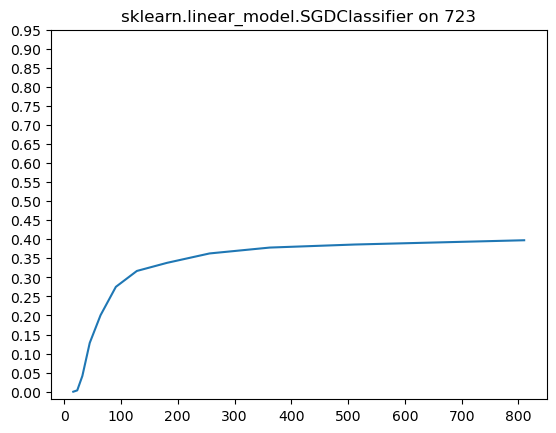

14it [00:24,  1.77s/it]

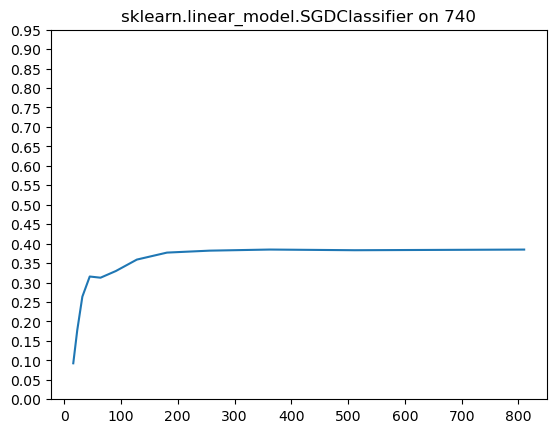

15it [00:26,  1.74s/it]

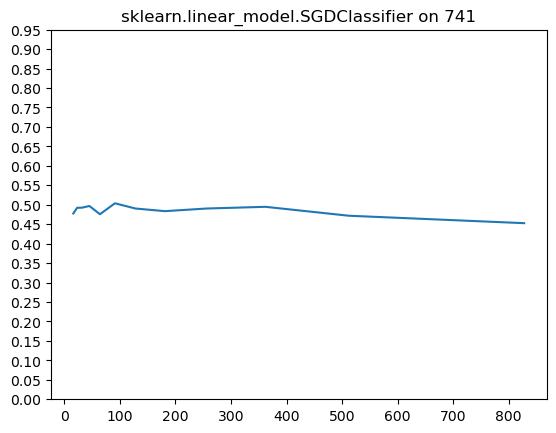

16it [00:27,  1.77s/it]

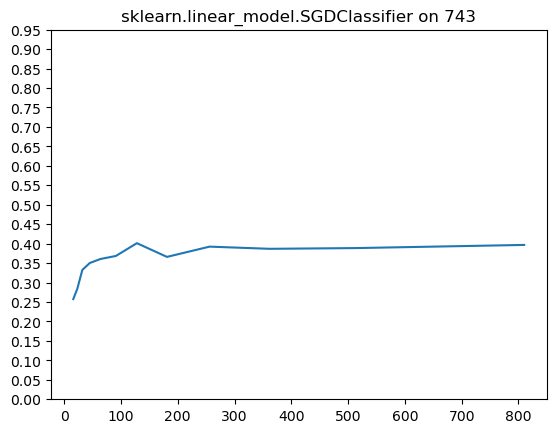

17it [00:29,  1.74s/it]

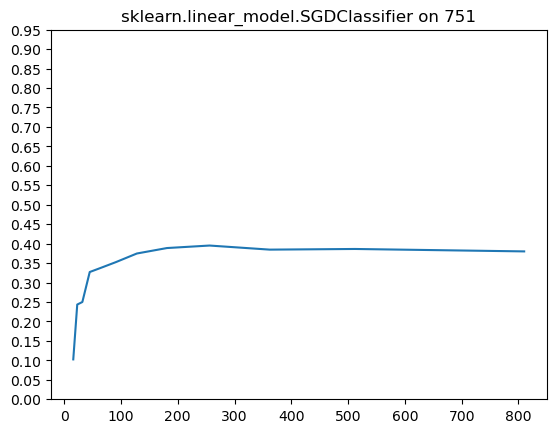

18it [00:31,  1.73s/it]

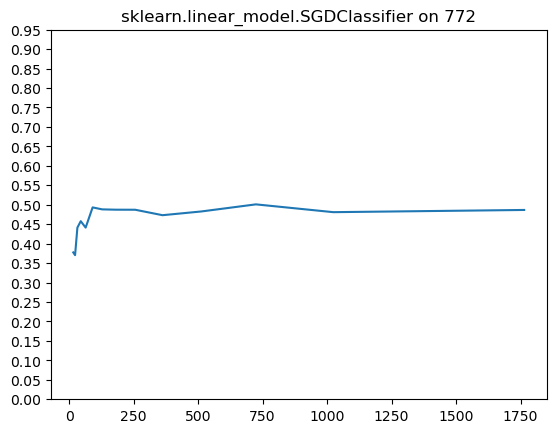

19it [00:32,  1.72s/it]

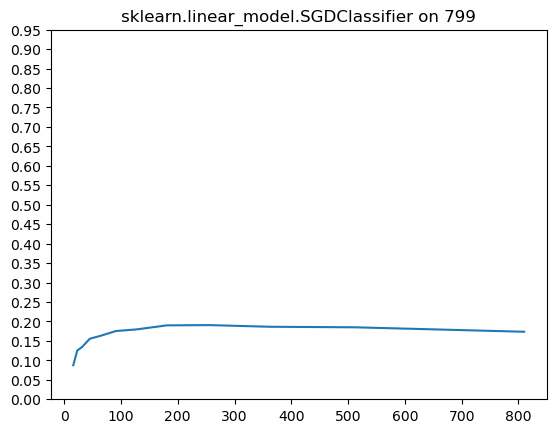

20it [00:34,  1.77s/it]

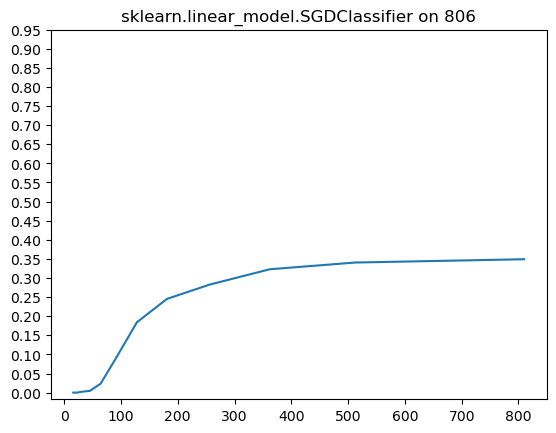

21it [00:36,  1.69s/it]

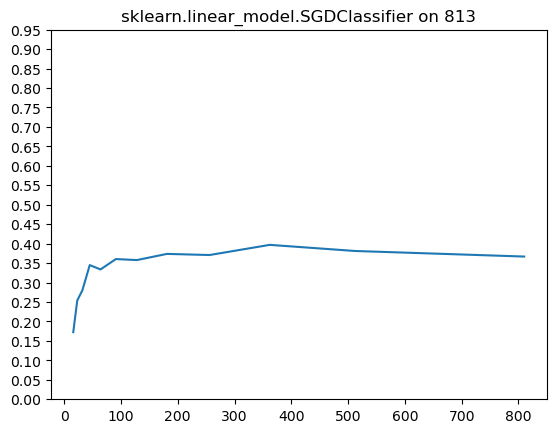

22it [00:37,  1.67s/it]

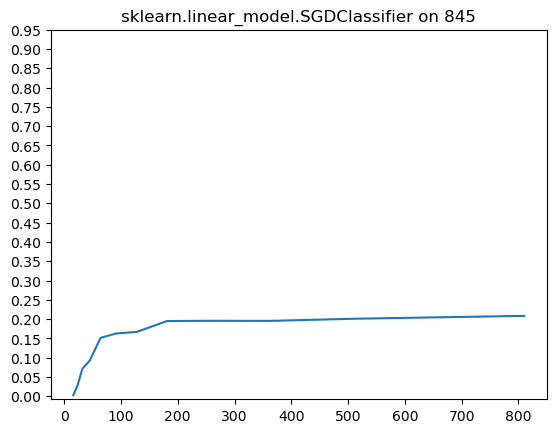

23it [00:39,  1.74s/it]

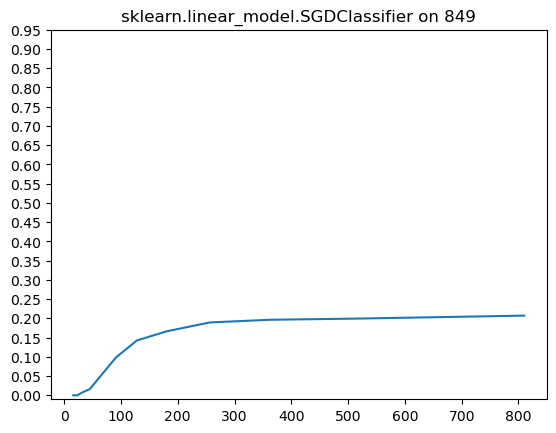

24it [00:41,  1.72s/it]

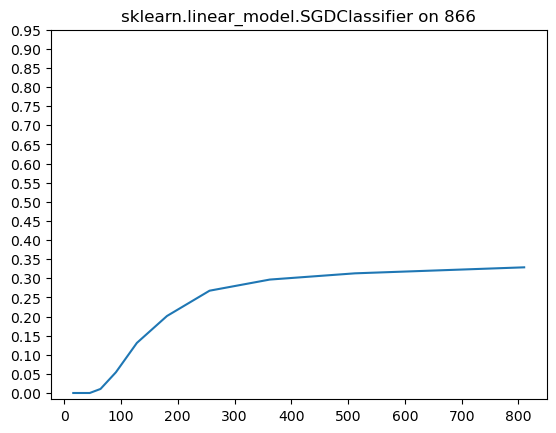

25it [00:43,  1.72s/it]

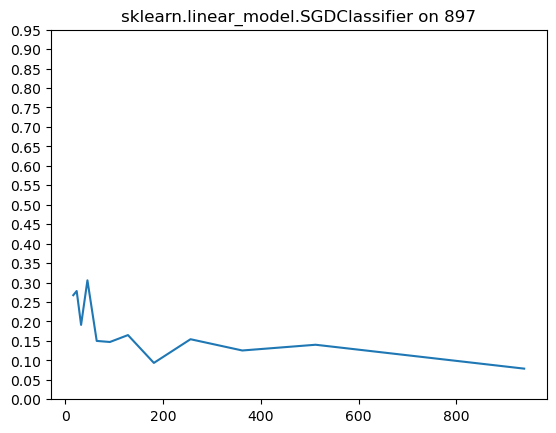

26it [00:45,  1.77s/it]

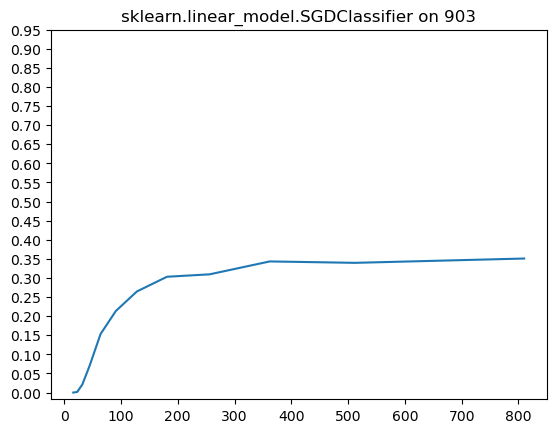

27it [00:47,  1.80s/it]

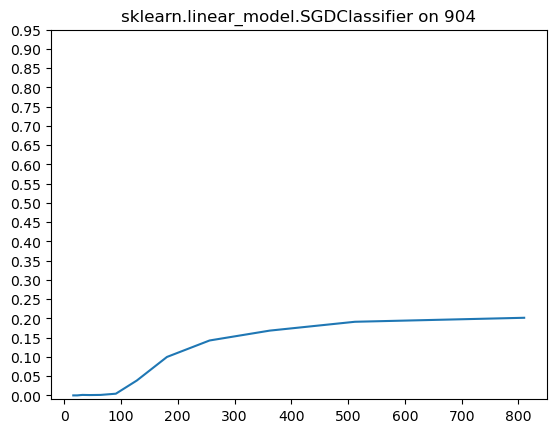

28it [00:48,  1.79s/it]

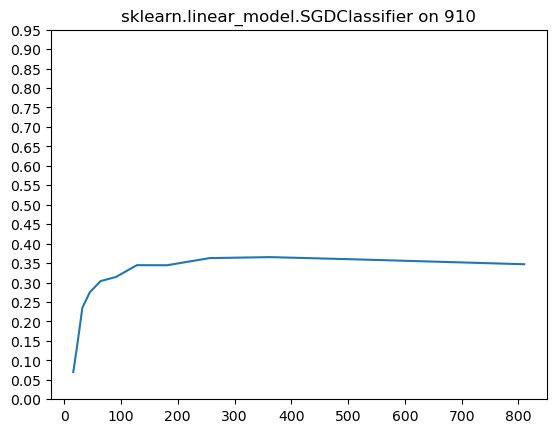

29it [00:50,  1.87s/it]

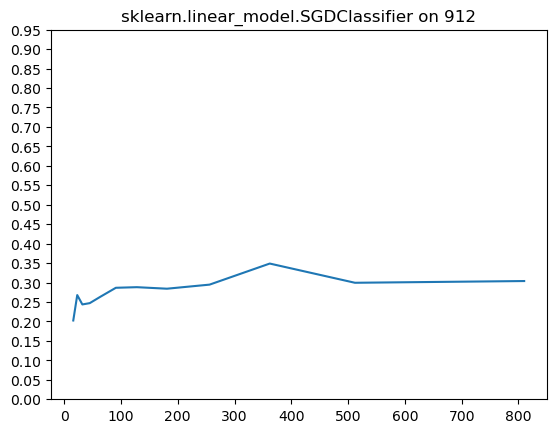

30it [00:52,  1.85s/it]

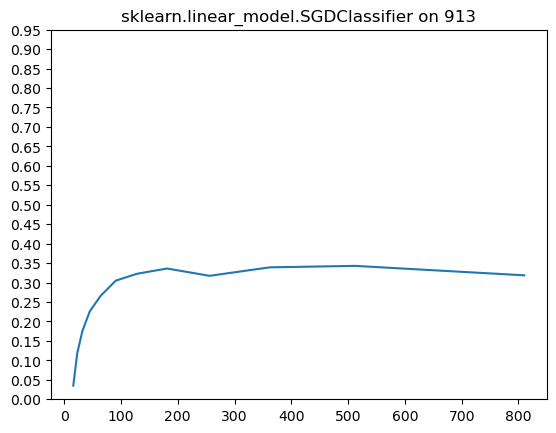

31it [00:54,  1.85s/it]

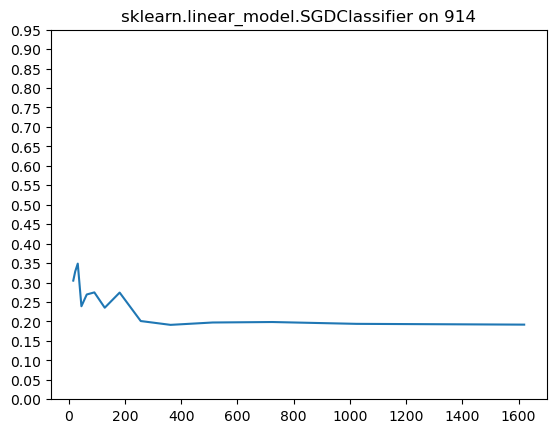

32it [00:56,  1.82s/it]

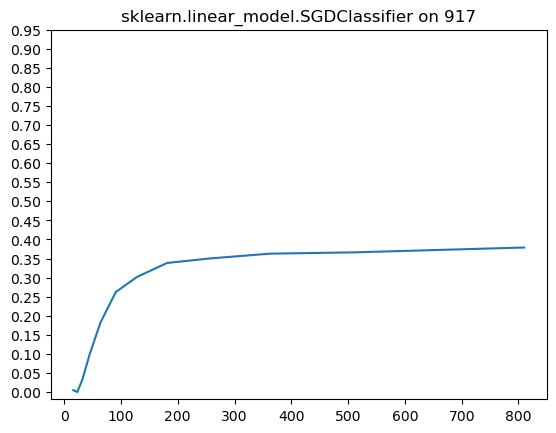

33it [00:57,  1.75s/it]

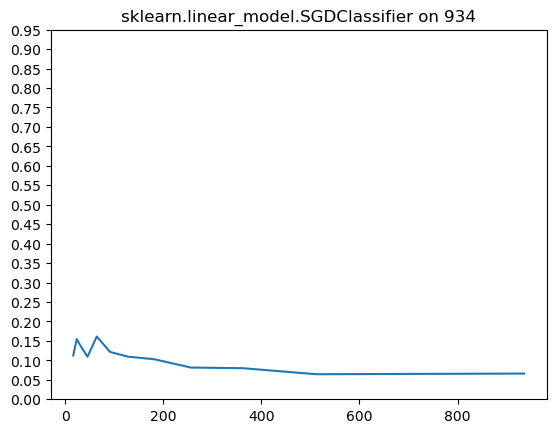

34it [00:59,  1.75s/it]

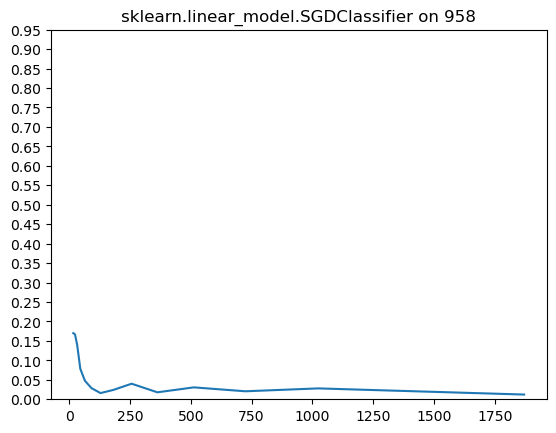

35it [01:01,  1.76s/it]

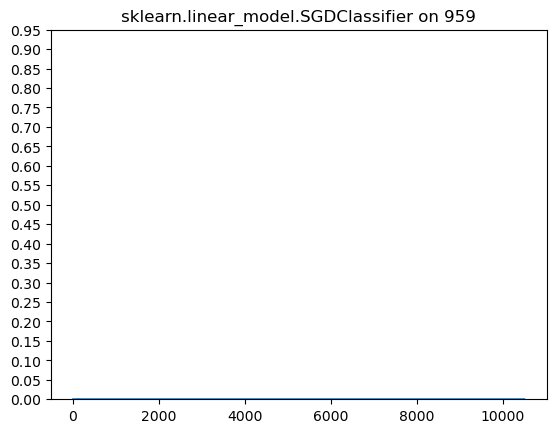

36it [01:03,  1.78s/it]

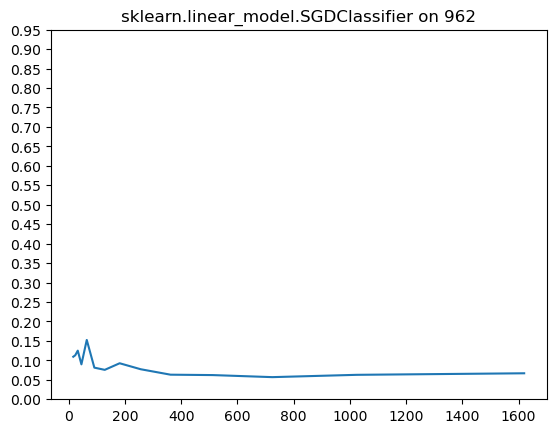

37it [01:05,  1.81s/it]

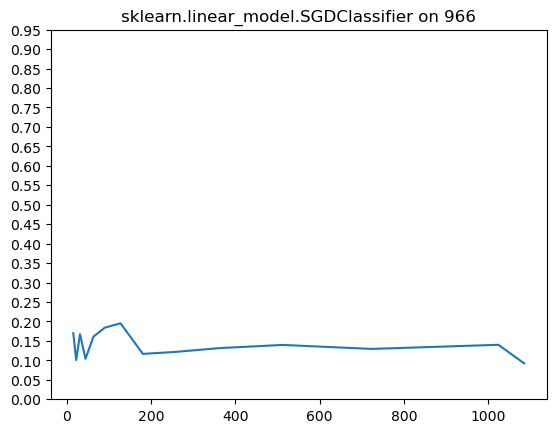

38it [01:06,  1.82s/it]

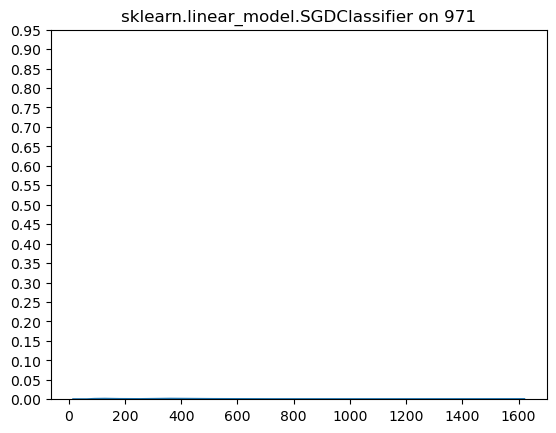

39it [01:08,  1.83s/it]

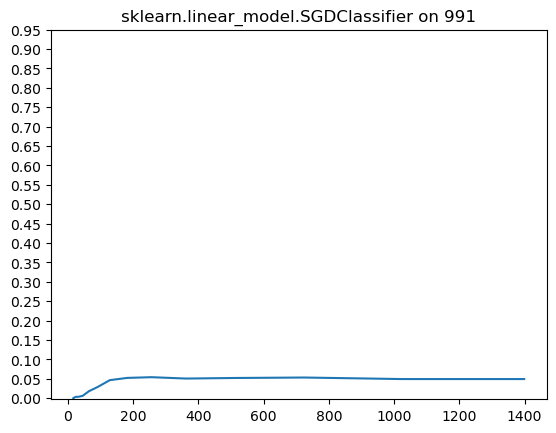

40it [01:10,  1.81s/it]

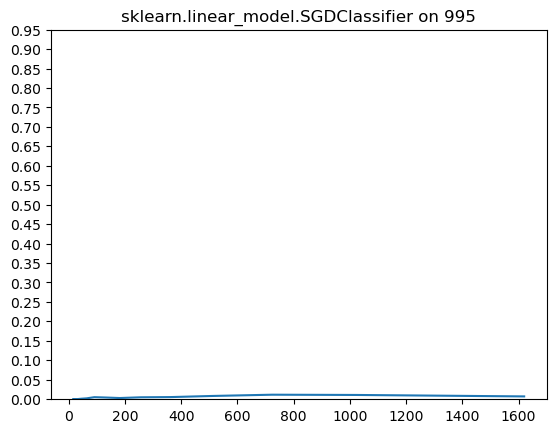

41it [01:12,  1.81s/it]

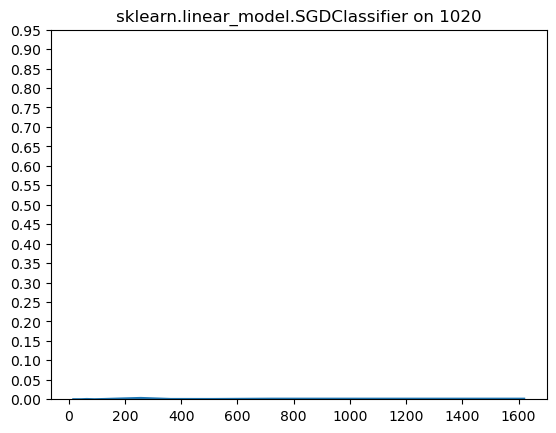

42it [01:14,  1.83s/it]

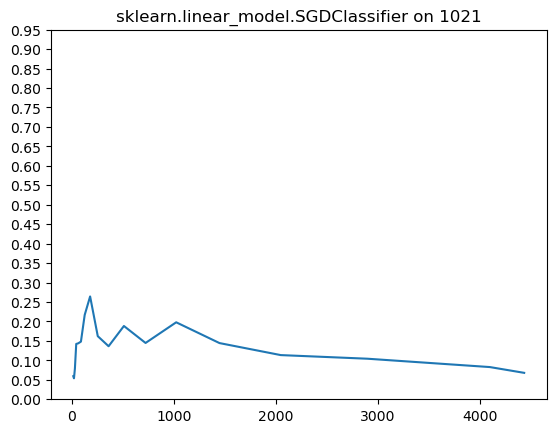

43it [01:15,  1.78s/it]

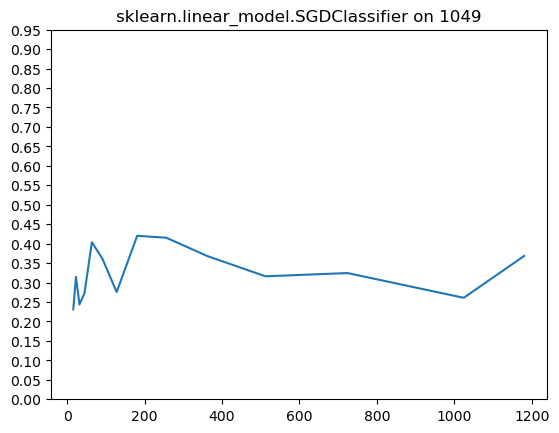

44it [01:17,  1.79s/it]

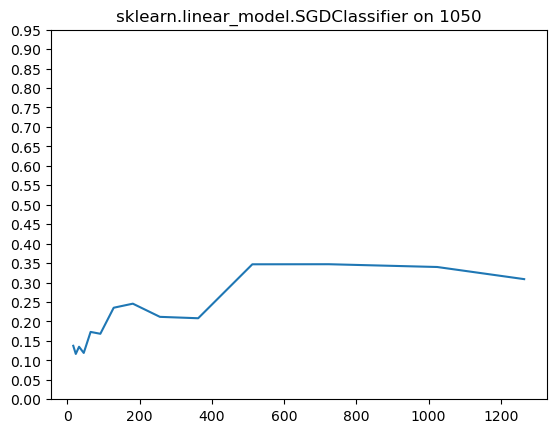

45it [01:19,  1.79s/it]

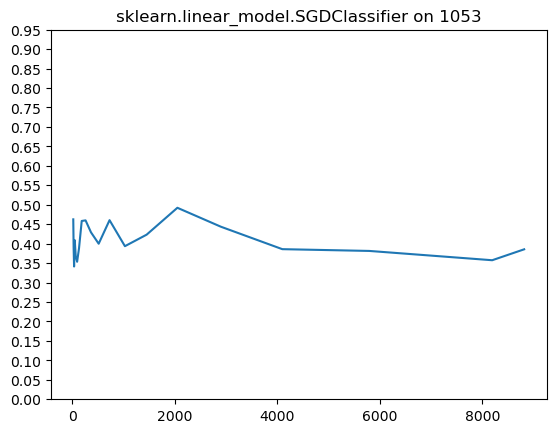

46it [01:21,  1.80s/it]

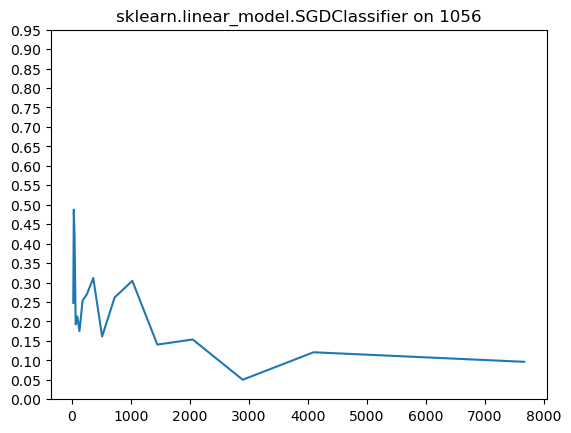

47it [01:23,  1.78s/it]

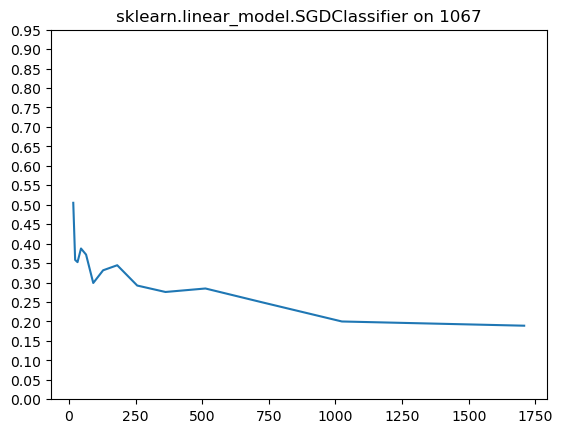

48it [01:25,  1.84s/it]

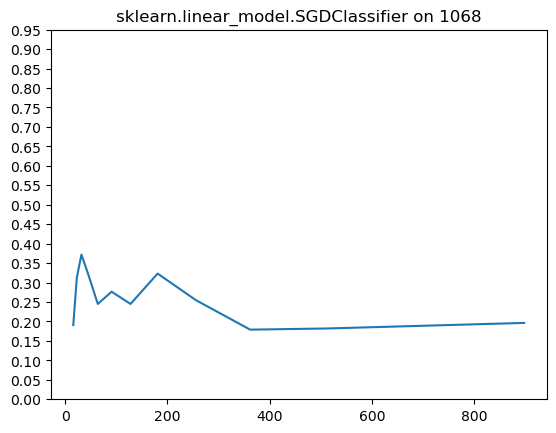

49it [01:26,  1.82s/it]

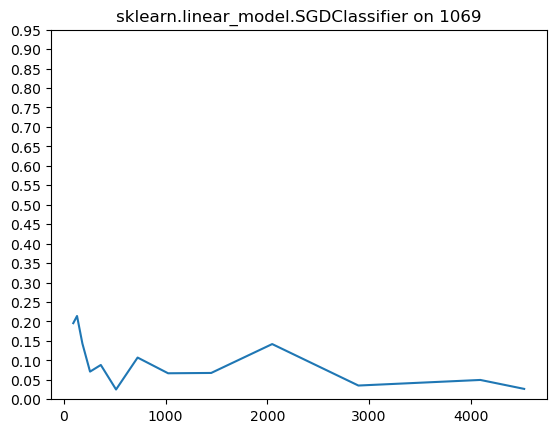

50it [01:28,  1.82s/it]

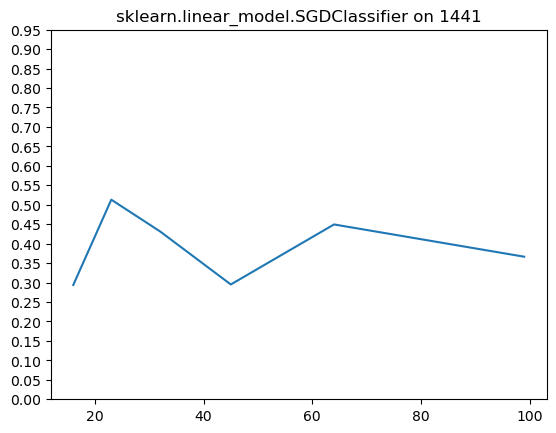

51it [01:30,  1.82s/it]

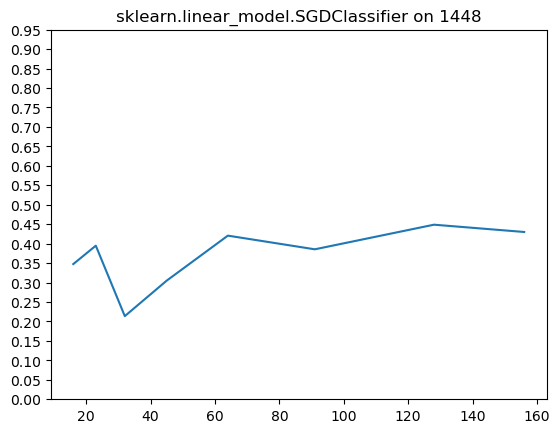

52it [01:32,  1.83s/it]

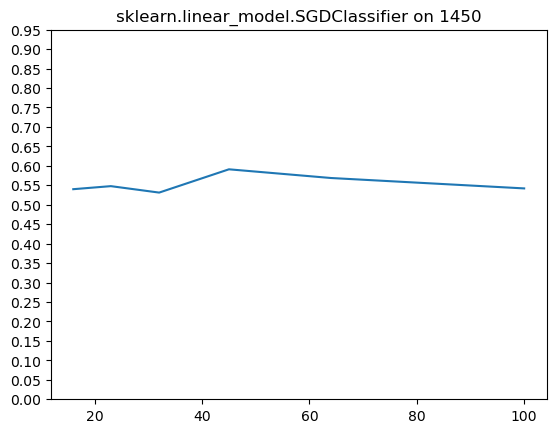

53it [01:34,  1.84s/it]

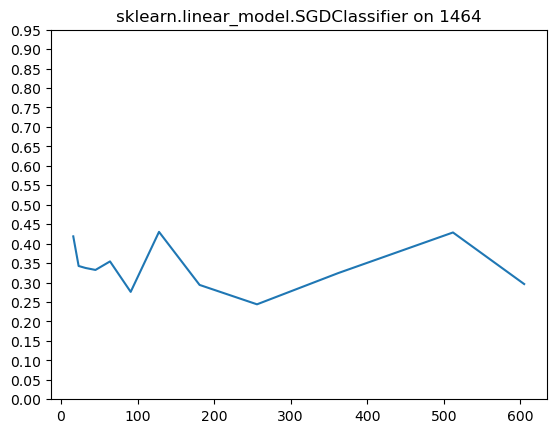

54it [01:35,  1.82s/it]

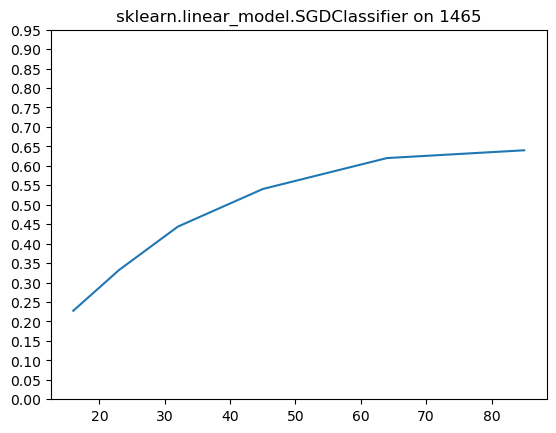

55it [01:37,  1.80s/it]

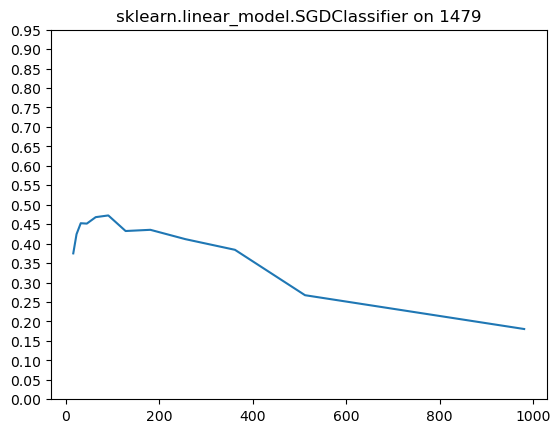

56it [01:39,  1.75s/it]

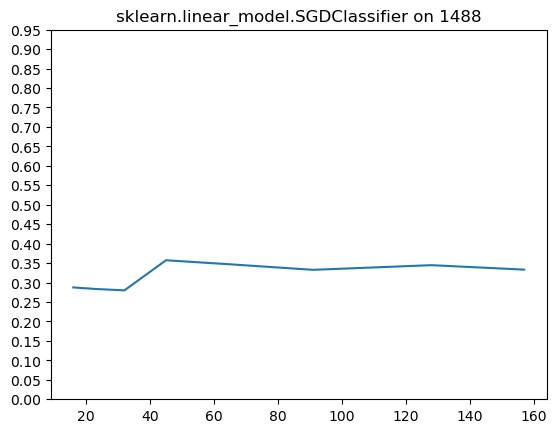

57it [01:41,  1.76s/it]

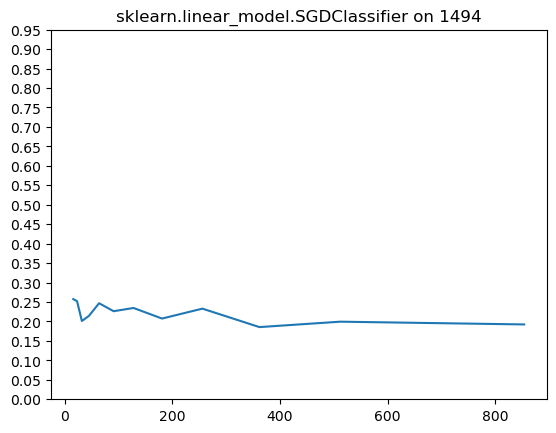

58it [01:42,  1.77s/it]

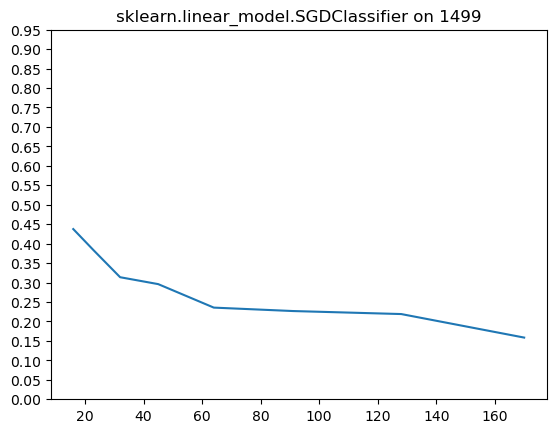

59it [01:44,  1.76s/it]

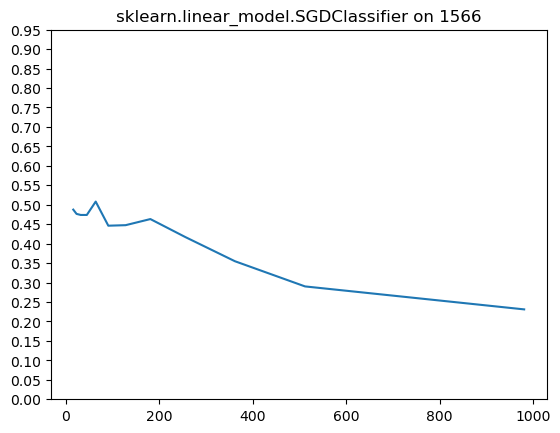

60it [01:46,  1.75s/it]

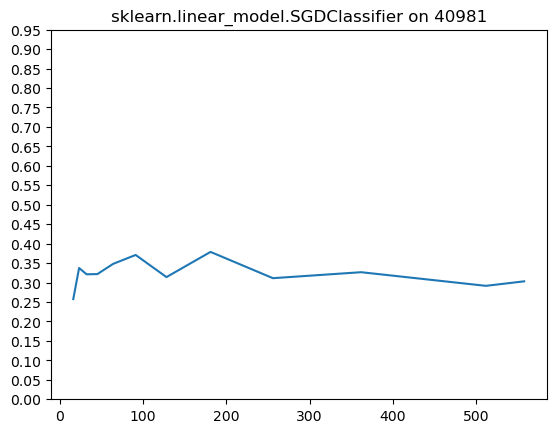

61it [01:48,  1.75s/it]

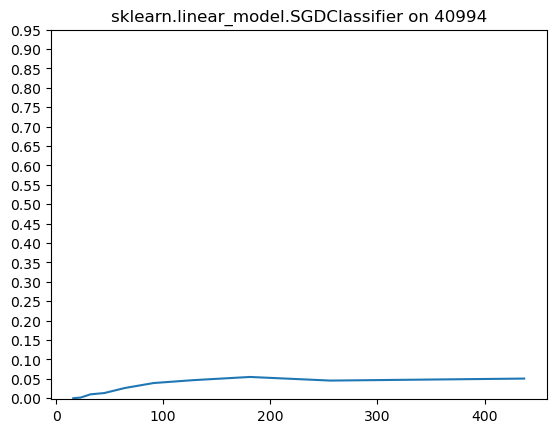

62it [01:49,  1.77s/it]


In [61]:
for e in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    q25 = lda['traintime'].quantile(0.25)
    lda = lda[lda['traintime'] < q25]
    for idx, row in tqdm(lda.iterrows()):
        fig, ax = plt.subplots()
        curve = lcdb.get_curve(row['openmlid'], row['learner'])
        plt.plot(curve[0], [1-np.mean(x) for x in curve[1]])
        ax.yaxis.set_ticks(np.arange(0, 1, 0.05))
        plt.title(f"{row['learner']} on {row['openmlid']}")
        plt.show()

In [62]:
intermediary_df = pd.DataFrame(rows, columns=['learner', 'openmlid', 'slopes', 'is_nonmonotonic'])

In [63]:
to_consider = ['sklearn.discriminant_analysis.LinearDiscriminantAnalysis', 'sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis', 'sklearn.linear_model.SGDClassifier']
exp_df = lcdb.get_all_curves('accuracy')
exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]

lda = exp_df[exp_df['learner'] == to_consider[0]]
# lda['traintime'].describe()

for el in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    q25 = lda['traintime'].quantile(0.25)
    q50 = lda['traintime'].quantile(0.50)
    lda = lda[(lda['traintime'] < q50) & (lda['traintime'] > q25)]
    for idx, row in tqdm(lda.iterrows()):
        try:
            slopes, flag = calc_monotonicity_one_lc(row['openmlid'], row['learner'])
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}")
            rows.append([row['learner'], row['openmlid'], slopes, flag])
        except Exception as e:
            print(e)

1it [01:25, 85.91s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 14 is non-monotonic: True


2it [02:43, 80.93s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 16 is non-monotonic: True


3it [03:48, 73.91s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 22 is non-monotonic: True


4it [04:34, 62.70s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 23 is non-monotonic: True


5it [05:42, 64.80s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 30 is non-monotonic: True


6it [05:45, 43.62s/it]

The number of samples must be more than the number of classes.


7it [06:26, 42.88s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 36 is non-monotonic: True


8it [09:13, 82.19s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 182 is non-monotonic: True


9it [09:15, 57.20s/it]

The number of samples must be more than the number of classes.


10it [10:06, 55.46s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 718 is non-monotonic: True


11it [10:56, 53.73s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 720 is non-monotonic: True


12it [12:26, 64.62s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 735 is non-monotonic: True


13it [14:32, 83.14s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 761 is non-monotonic: True


14it [15:10, 69.57s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 797 is non-monotonic: True


15it [16:38, 75.20s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 803 is non-monotonic: True


16it [17:17, 64.37s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 806 is non-monotonic: True


17it [18:48, 72.36s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 807 is non-monotonic: True


18it [20:24, 79.46s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 816 is non-monotonic: True


19it [22:07, 86.45s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 819 is non-monotonic: True


20it [26:17, 135.67s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 822 is non-monotonic: True


21it [30:24, 168.89s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 823 is non-monotonic: True


22it [31:04, 130.17s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 837 is non-monotonic: True


23it [35:45, 175.54s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 843 is non-monotonic: True


24it [36:59, 145.18s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 847 is non-monotonic: True


25it [37:39, 113.61s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 866 is non-monotonic: True


26it [38:23, 92.51s/it] 

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 897 is non-monotonic: True


27it [39:01, 76.41s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 904 is non-monotonic: True


28it [40:34, 81.31s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 923 is non-monotonic: True


29it [41:41, 76.91s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 930 is non-monotonic: True


30it [42:12, 63.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 934 is non-monotonic: True


31it [42:44, 54.02s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 958 is non-monotonic: True


32it [44:30, 69.42s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 976 is non-monotonic: True


33it [46:07, 77.73s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 979 is non-monotonic: True


34it [46:56, 68.99s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1067 is non-monotonic: True


35it [50:12, 107.13s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1120 is non-monotonic: True


36it [51:02, 90.19s/it] 

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1479 is non-monotonic: True


37it [51:36, 73.09s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1494 is non-monotonic: True


38it [52:27, 66.58s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 1566 is non-monotonic: True


39it [53:32, 66.15s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40498 is non-monotonic: True


40it [54:27, 62.83s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40982 is non-monotonic: True


41it [55:18, 59.33s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 40984 is non-monotonic: True


42it [56:42, 66.68s/it]

sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41146 is non-monotonic: True


43it [58:27, 81.56s/it]


sklearn.discriminant_analysis.LinearDiscriminantAnalysis on 41156 is non-monotonic: True


1it [00:02,  2.30s/it]

y has only 1 sample in class acc, covariance is ill defined.


2it [00:04,  1.96s/it]

The number of classes has to be greater than one; got 1 class


3it [00:05,  1.83s/it]

y has only 1 sample in class 0, covariance is ill defined.


4it [00:07,  1.77s/it]

y has only 1 sample in class window, covariance is ill defined.


5it [00:09,  1.89s/it]

y has only 1 sample in class 1, covariance is ill defined.


6it [00:10,  1.75s/it]

y has only 1 sample in class 4., covariance is ill defined.


7it [00:12,  1.74s/it]

y has only 1 sample in class 1, covariance is ill defined.


8it [00:14,  1.76s/it]

The number of classes has to be greater than one; got 1 class


9it [00:17,  2.10s/it]

y has only 1 sample in class P, covariance is ill defined.


10it [00:19,  2.07s/it]

The number of classes has to be greater than one; got 1 class


11it [01:12, 17.66s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 797 is non-monotonic: True


12it [02:07, 28.92s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 806 is non-monotonic: True


13it [02:08, 20.71s/it]

y has only 1 sample in class P, covariance is ill defined.


14it [02:10, 14.99s/it]

y has only 1 sample in class P, covariance is ill defined.


15it [04:13, 47.54s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 819 is non-monotonic: True


16it [04:18, 34.68s/it]

y has only 1 sample in class P, covariance is ill defined.


17it [04:21, 25.29s/it]

y has only 1 sample in class P, covariance is ill defined.


18it [04:25, 18.79s/it]

The number of classes has to be greater than one; got 1 class


19it [05:15, 28.31s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 837 is non-monotonic: True


20it [05:19, 20.83s/it]

y has only 1 sample in class N, covariance is ill defined.


21it [05:22, 15.53s/it]

y has only 1 sample in class N, covariance is ill defined.


22it [07:09, 43.10s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 847 is non-monotonic: True


23it [08:04, 46.47s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 866 is non-monotonic: True


24it [08:06, 33.11s/it]

y has only 1 sample in class N, covariance is ill defined.


25it [08:08, 23.72s/it]

y has only 1 sample in class N, covariance is ill defined.


26it [08:09, 17.15s/it]

y has only 1 sample in class P, covariance is ill defined.


27it [08:11, 12.52s/it]

y has only 1 sample in class N, covariance is ill defined.


28it [08:13,  9.34s/it]

The number of classes has to be greater than one; got 1 class


29it [08:15,  7.16s/it]

y has only 1 sample in class P, covariance is ill defined.


30it [08:18,  5.83s/it]

y has only 1 sample in class P, covariance is ill defined.


31it [08:20,  4.86s/it]

y has only 1 sample in class P, covariance is ill defined.


32it [08:22,  3.95s/it]

The number of classes has to be greater than one; got 1 class


33it [08:24,  3.44s/it]

y has only 1 sample in class P, covariance is ill defined.


34it [08:26,  2.90s/it]

The number of classes has to be greater than one; got 1 class


35it [08:28,  2.53s/it]

The number of classes has to be greater than one; got 1 class


36it [08:29,  2.28s/it]

y has only 1 sample in class True, covariance is ill defined.


37it [08:31,  2.11s/it]

y has only 1 sample in class True, covariance is ill defined.


38it [08:33,  2.01s/it]

The number of classes has to be greater than one; got 1 class


39it [08:35,  1.99s/it]

y has only 1 sample in class h, covariance is ill defined.


40it [08:37,  1.87s/it]

The number of classes has to be greater than one; got 1 class


41it [08:39,  2.09s/it]

y has only 1 sample in class P, covariance is ill defined.


42it [08:41,  1.95s/it]

y has only 1 sample in class 2, covariance is ill defined.


43it [08:43,  2.00s/it]

y has only 1 sample in class 1, covariance is ill defined.


44it [08:45,  2.02s/it]

The number of classes has to be greater than one; got 1 class


45it [08:47,  1.95s/it]

y has only 1 sample in class 212, covariance is ill defined.


46it [08:48,  1.89s/it]

y has only 1 sample in class acc, covariance is ill defined.


47it [08:50,  1.82s/it]

y has only 1 sample in class Stains, covariance is ill defined.


48it [08:52,  1.74s/it]

y has only 1 sample in class window, covariance is ill defined.


49it [08:55,  2.10s/it]

y has only 1 sample in class d, covariance is ill defined.


50it [10:35, 31.60s/it]

sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis on 41146 is non-monotonic: True


51it [10:37, 12.49s/it]


y has only 1 sample in class 1, covariance is ill defined.


1it [01:05, 65.98s/it]

'NoneType' object is not subscriptable


2it [02:07, 63.36s/it]

'NoneType' object is not subscriptable


3it [02:52, 54.86s/it]

'NoneType' object is not subscriptable


4it [05:01, 84.12s/it]

'NoneType' object is not subscriptable


5it [05:03, 54.43s/it]

The number of classes has to be greater than one; got 1 class


6it [06:02, 56.14s/it]

'NoneType' object is not subscriptable


7it [06:04, 38.61s/it]

The number of classes has to be greater than one; got 1 class


8it [06:07, 27.06s/it]

The number of classes has to be greater than one; got 1 class


9it [07:23, 42.50s/it]

'NoneType' object is not subscriptable


10it [08:06, 42.55s/it]

sklearn.linear_model.SGDClassifier on 54 is non-monotonic: True


11it [08:59, 45.64s/it]

'NoneType' object is not subscriptable


12it [09:00, 32.27s/it]

The number of classes has to be greater than one; got 1 class


13it [09:50, 37.69s/it]

sklearn.linear_model.SGDClassifier on 188 is non-monotonic: True


14it [10:42, 41.95s/it]

sklearn.linear_model.SGDClassifier on 299 is non-monotonic: True


15it [11:19, 40.37s/it]

sklearn.linear_model.SGDClassifier on 679 is non-monotonic: True


16it [11:50, 37.48s/it]

sklearn.linear_model.SGDClassifier on 718 is non-monotonic: True


17it [12:23, 36.16s/it]

'NoneType' object is not subscriptable


18it [12:25, 25.81s/it]

The number of classes has to be greater than one; got 1 class


19it [12:56, 27.61s/it]

'NoneType' object is not subscriptable


20it [13:24, 27.71s/it]

sklearn.linear_model.SGDClassifier on 797 is non-monotonic: True


21it [14:11, 33.36s/it]

'NoneType' object is not subscriptable


22it [15:00, 38.21s/it]

'NoneType' object is not subscriptable


23it [15:49, 41.31s/it]

'NoneType' object is not subscriptable


24it [16:42, 44.99s/it]

'NoneType' object is not subscriptable


25it [18:42, 67.43s/it]

'NoneType' object is not subscriptable


26it [19:08, 55.06s/it]

sklearn.linear_model.SGDClassifier on 837 is non-monotonic: True


27it [20:56, 70.88s/it]

'NoneType' object is not subscriptable


28it [21:41, 62.95s/it]

'NoneType' object is not subscriptable


29it [22:17, 55.10s/it]

'NoneType' object is not subscriptable


30it [25:22, 94.06s/it]

'NoneType' object is not subscriptable


31it [26:26, 85.07s/it]

'NoneType' object is not subscriptable


32it [27:04, 70.69s/it]

'NoneType' object is not subscriptable


33it [28:03, 67.42s/it]

'NoneType' object is not subscriptable


34it [28:06, 47.83s/it]

The number of classes has to be greater than one; got 1 class


35it [28:08, 34.21s/it]

The number of classes has to be greater than one; got 1 class


36it [28:10, 24.62s/it]

The number of classes has to be greater than one; got 1 class


37it [28:12, 17.91s/it]

The number of classes has to be greater than one; got 1 class


38it [28:15, 13.32s/it]

The number of classes has to be greater than one; got 1 class


39it [28:18, 10.07s/it]

The number of classes has to be greater than one; got 1 class


40it [28:20,  7.80s/it]

The number of classes has to be greater than one; got 1 class


41it [28:22,  6.05s/it]

The number of classes has to be greater than one; got 1 class


42it [28:24,  4.93s/it]

The number of classes has to be greater than one; got 1 class


43it [28:26,  4.07s/it]

The number of classes has to be greater than one; got 1 class


44it [53:55, 461.30s/it]

sklearn.linear_model.SGDClassifier on 1503 is non-monotonic: True


45it [1:06:55, 557.17s/it]

sklearn.linear_model.SGDClassifier on 1509 is non-monotonic: True


46it [2:40:20, 2071.28s/it]

sklearn.linear_model.SGDClassifier on 1567 is non-monotonic: True


47it [2:44:17, 1521.16s/it]

'NoneType' object is not subscriptable


48it [2:45:57, 1094.70s/it]

'NoneType' object is not subscriptable


49it [2:46:05, 768.65s/it] 

The number of classes has to be greater than one; got 1 class


50it [2:46:52, 552.37s/it]

sklearn.linear_model.SGDClassifier on 40687 is non-monotonic: True


51it [2:46:54, 387.13s/it]

The number of classes has to be greater than one; got 1 class


52it [2:47:01, 273.04s/it]

The number of classes has to be greater than one; got 1 class


53it [2:47:02, 191.59s/it]

The number of classes has to be greater than one; got 1 class


54it [2:47:09, 135.99s/it]

The number of classes has to be greater than one; got 1 class


55it [2:47:10, 95.71s/it] 

The number of classes has to be greater than one; got 1 class


56it [2:47:57, 81.14s/it]

'NoneType' object is not subscriptable


57it [2:47:59, 57.30s/it]

The number of classes has to be greater than one; got 1 class


58it [2:48:49, 55.03s/it]

'NoneType' object is not subscriptable


59it [2:48:58, 41.36s/it]

The number of classes has to be greater than one; got 1 class


60it [2:49:36, 40.31s/it]

'NoneType' object is not subscriptable


61it [2:49:38, 28.75s/it]

The number of classes has to be greater than one; got 1 class


62it [2:49:51, 164.38s/it]

The number of classes has to be greater than one; got 1 class


In [64]:
intermediary_df2 = pd.DataFrame(rows, columns=['learner', 'openmlid', 'slopes', 'is_nonmonotonic'])

In [65]:
to_consider = ['sklearn.ensemble.GradientBoostingClassifier', 'sklearn.linear_model.LogisticRegression', 'sklearn.linear_model.PassiveAggressiveClassifier']
exp_df = lcdb.get_all_curves('accuracy')
exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]

lda = exp_df[exp_df['learner'] == to_consider[0]]
# lda['traintime'].describe()

rows = []

for el in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    q25 = lda['traintime'].quantile(0.25)
    q50 = lda['traintime'].quantile(0.50)
    lda = lda[(lda['traintime'] < q50)]
    for idx, row in tqdm(lda.iterrows()):
        try:
            slopes, flag = calc_monotonicity_one_lc(row['openmlid'], row['learner'])
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}")
            rows.append([row['learner'], row['openmlid'], slopes, flag])
        except Exception as e:
            print(e)

1it [40:34, 2434.24s/it]

sklearn.ensemble.GradientBoostingClassifier on 3 is non-monotonic: True


2it [1:11:33, 2095.79s/it]

sklearn.ensemble.GradientBoostingClassifier on 11 is non-monotonic: True


3it [1:11:47, 1145.29s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


4it [3:41:55, 4249.57s/it]

sklearn.ensemble.GradientBoostingClassifier on 18 is non-monotonic: True


5it [3:42:02, 2719.47s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


6it [4:20:47, 2585.40s/it]

sklearn.ensemble.GradientBoostingClassifier on 23 is non-monotonic: True


7it [4:58:49, 2486.32s/it]

sklearn.ensemble.GradientBoostingClassifier on 24 is non-monotonic: False


8it [5:08:22, 1877.22s/it]

sklearn.ensemble.GradientBoostingClassifier on 31 is non-monotonic: True


9it [5:08:24, 1290.95s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


10it [5:08:26, 892.96s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


11it [8:05:32, 3871.83s/it]

sklearn.ensemble.GradientBoostingClassifier on 46 is non-monotonic: True


12it [8:50:51, 3521.13s/it]

sklearn.ensemble.GradientBoostingClassifier on 54 is non-monotonic: True


13it [8:50:54, 2455.46s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


14it [8:50:57, 1714.48s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


15it [8:57:43, 1320.16s/it]

sklearn.ensemble.GradientBoostingClassifier on 61 is non-monotonic: False


16it [8:57:50, 925.05s/it] 

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


17it [10:22:34, 2175.46s/it]

sklearn.ensemble.GradientBoostingClassifier on 181 is non-monotonic: True


18it [10:22:41, 1523.97s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


19it [11:07:32, 1874.35s/it]

sklearn.ensemble.GradientBoostingClassifier on 188 is non-monotonic: True


20it [11:07:33, 1312.09s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


21it [11:09:04, 945.39s/it] 

sklearn.ensemble.GradientBoostingClassifier on 346 is non-monotonic: False


22it [11:09:06, 662.16s/it]

y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


23it [11:12:48, 530.21s/it]

sklearn.ensemble.GradientBoostingClassifier on 446 is non-monotonic: False


24it [11:34:50, 767.91s/it]

sklearn.ensemble.GradientBoostingClassifier on 679 is non-monotonic: True


25it [12:01:22, 1014.95s/it]

sklearn.ensemble.GradientBoostingClassifier on 715 is non-monotonic: True


26it [13:31:30, 2333.16s/it]

sklearn.ensemble.GradientBoostingClassifier on 718 is non-monotonic: True


27it [13:53:49, 2034.87s/it]

sklearn.ensemble.GradientBoostingClassifier on 720 is non-monotonic: True


27it [14:22:49, 1917.38s/it]


KeyboardInterrupt: 

In [69]:
intermediary_df3 = pd.DataFrame(rows, columns=['learner', 'openmlid', 'slopes', 'is_nonmonotonic'])

In [72]:
intermediary_df.to_csv("df1.csv")
intermediary_df2.to_csv("df2.csv")
intermediary_df3.to_csv("df3.csv")

print(intermediary_df)
print(intermediary_df2)
intermediary_df3

                                              learner  openmlid  \
0   sklearn.discriminant_analysis.LinearDiscrimina...        11   
1   sklearn.discriminant_analysis.LinearDiscrimina...        18   
2   sklearn.discriminant_analysis.LinearDiscrimina...        21   
3   sklearn.discriminant_analysis.LinearDiscrimina...        54   
4   sklearn.discriminant_analysis.LinearDiscrimina...        55   
..                                                ...       ...   
79                 sklearn.linear_model.SGDClassifier      1450   
80                 sklearn.linear_model.SGDClassifier      1465   
81                 sklearn.linear_model.SGDClassifier      1499   
82                 sklearn.linear_model.SGDClassifier      1566   
83                 sklearn.linear_model.SGDClassifier     40981   

                                               slopes  is_nonmonotonic  
0   [0.0030240931706235984, 0.002549362189926149, ...             True  
1   [0.001818438837756814, 0.005666008646682077, 

learner  openmlid  \
0   sklearn.ensemble.GradientBoostingClassifier         3   
1   sklearn.ensemble.GradientBoostingClassifier        11   
2   sklearn.ensemble.GradientBoostingClassifier        18   
3   sklearn.ensemble.GradientBoostingClassifier        23   
4   sklearn.ensemble.GradientBoostingClassifier        24   
5   sklearn.ensemble.GradientBoostingClassifier        31   
6   sklearn.ensemble.GradientBoostingClassifier        46   
7   sklearn.ensemble.GradientBoostingClassifier        54   
8   sklearn.ensemble.GradientBoostingClassifier        61   
9   sklearn.ensemble.GradientBoostingClassifier       181   
10  sklearn.ensemble.GradientBoostingClassifier       188   
11  sklearn.ensemble.GradientBoostingClassifier       346   
12  sklearn.ensemble.GradientBoostingClassifier       446   
13  sklearn.ensemble.GradientBoostingClassifier       679   
14  sklearn.ensemble.GradientBoostingClassifier       715   
15  sklearn.ensemble.GradientBoostingClassifier       718   
16  sklearn.ensemble.GradientBoostingClassifier       720   

                                               slopes  is_nonmonotonic  
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4875110225547...             True  
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.88979873...             True  
2   [3.868131868131868e-05, 9.374955305563624e-05,...             True  
3   [7.736263736263735e-05, 0.00018749910611127248...             True  
4   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            False  
5   [0.0, 0.0, 0.0, 6.111535523300241e-06, 8.90848...             True  
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.674...             True  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             True  
8                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]            False  
9   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.894...             True  
10  [0.0011952451330347357, 0.001701638490559642, ...             True  
11                               [0.0, 0.0, 0.0, 0.0]            False  
12           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]            False  
13  [0.00017291219570696444, 0.000532980566723517,...             True  
14  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             True  
15  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             True  
16  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.1789882...             True

In [73]:
to_consider = ['sklearn.linear_model.LogisticRegression']
exp_df = lcdb.get_all_curves('accuracy')
exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]

lda = exp_df[exp_df['learner'] == to_consider[0]]
# lda['traintime'].describe()

rows = []

for el in to_consider:
    lda = exp_df[exp_df['learner'] == el]
    q25 = lda['traintime'].quantile(0.25)
    q50 = lda['traintime'].quantile(0.50)
    lda = lda[(lda['traintime'] < q25)]
    for idx, row in tqdm(lda.iterrows()):
        try:
            slopes, flag = calc_monotonicity_one_lc(row['openmlid'], row['learner'])
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}")
            rows.append([row['learner'], row['openmlid'], slopes, flag])
        except Exception as e:
            print(e)

1it [00:36, 36.81s/it]

sklearn.linear_model.LogisticRegression on 11 is non-monotonic: True


2it [00:38, 16.43s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'no-recurrence-events'


3it [02:01, 46.81s/it]

sklearn.linear_model.LogisticRegression on 31 is non-monotonic: True


4it [02:03, 29.08s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'LIVE'


5it [02:42, 32.66s/it]

sklearn.linear_model.LogisticRegression on 61 is non-monotonic: True


6it [02:44, 22.14s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: '1'


7it [02:57, 19.28s/it]

sklearn.linear_model.LogisticRegression on 346 is non-monotonic: True


8it [02:59, 13.66s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'cold'


9it [03:45, 23.84s/it]

sklearn.linear_model.LogisticRegression on 446 is non-monotonic: True


10it [04:39, 33.08s/it]

sklearn.linear_model.LogisticRegression on 679 is non-monotonic: True


11it [05:19, 35.13s/it]

sklearn.linear_model.LogisticRegression on 715 is non-monotonic: True


12it [06:20, 43.13s/it]

sklearn.linear_model.LogisticRegression on 718 is non-monotonic: True


13it [08:15, 64.86s/it]

sklearn.linear_model.LogisticRegression on 720 is non-monotonic: True


14it [08:52, 56.51s/it]

sklearn.linear_model.LogisticRegression on 723 is non-monotonic: True


15it [08:56, 40.48s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


16it [10:19, 53.40s/it]

sklearn.linear_model.LogisticRegression on 737 is non-monotonic: True


17it [10:54, 47.97s/it]

sklearn.linear_model.LogisticRegression on 740 is non-monotonic: True


18it [12:28, 61.81s/it]

sklearn.linear_model.LogisticRegression on 741 is non-monotonic: True


19it [13:06, 54.38s/it]

sklearn.linear_model.LogisticRegression on 743 is non-monotonic: True


20it [13:46, 50.25s/it]

sklearn.linear_model.LogisticRegression on 751 is non-monotonic: True


21it [14:58, 56.67s/it]

sklearn.linear_model.LogisticRegression on 772 is non-monotonic: True


22it [15:51, 55.49s/it]

sklearn.linear_model.LogisticRegression on 797 is non-monotonic: True


23it [16:24, 49.02s/it]

sklearn.linear_model.LogisticRegression on 799 is non-monotonic: True


24it [18:32, 72.70s/it]

sklearn.linear_model.LogisticRegression on 803 is non-monotonic: True


25it [19:21, 65.60s/it]

sklearn.linear_model.LogisticRegression on 806 is non-monotonic: True


26it [21:22, 82.12s/it]

sklearn.linear_model.LogisticRegression on 807 is non-monotonic: True


27it [21:53, 66.70s/it]

sklearn.linear_model.LogisticRegression on 813 is non-monotonic: True


28it [23:47, 81.00s/it]

sklearn.linear_model.LogisticRegression on 816 is non-monotonic: True


29it [30:34, 178.85s/it]

sklearn.linear_model.LogisticRegression on 821 is non-monotonic: True


30it [31:13, 136.81s/it]

sklearn.linear_model.LogisticRegression on 837 is non-monotonic: True


31it [31:41, 104.25s/it]

sklearn.linear_model.LogisticRegression on 845 is non-monotonic: True


32it [32:08, 80.95s/it] 

sklearn.linear_model.LogisticRegression on 849 is non-monotonic: True


33it [32:43, 67.26s/it]

sklearn.linear_model.LogisticRegression on 866 is non-monotonic: True


34it [34:00, 69.99s/it]

sklearn.linear_model.LogisticRegression on 871 is non-monotonic: True


35it [35:35, 77.75s/it]

sklearn.linear_model.LogisticRegression on 897 is non-monotonic: True


36it [36:04, 63.09s/it]

sklearn.linear_model.LogisticRegression on 903 is non-monotonic: True


37it [36:40, 54.90s/it]

sklearn.linear_model.LogisticRegression on 904 is non-monotonic: True


38it [37:14, 48.56s/it]

sklearn.linear_model.LogisticRegression on 910 is non-monotonic: True


39it [37:48, 44.32s/it]

sklearn.linear_model.LogisticRegression on 912 is non-monotonic: True


40it [38:27, 42.53s/it]

sklearn.linear_model.LogisticRegression on 913 is non-monotonic: True


41it [39:18, 45.26s/it]

sklearn.linear_model.LogisticRegression on 914 is non-monotonic: True


42it [39:54, 42.26s/it]

sklearn.linear_model.LogisticRegression on 917 is non-monotonic: True


43it [39:55, 30.07s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'P'


44it [44:25, 102.13s/it]

sklearn.linear_model.LogisticRegression on 959 is non-monotonic: False


45it [44:27, 71.94s/it] 

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


46it [44:29, 50.90s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'P'


47it [44:30, 36.13s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


48it [44:33, 25.95s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


49it [45:25, 33.85s/it]

sklearn.linear_model.LogisticRegression on 991 is non-monotonic: True


50it [45:26, 24.12s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


51it [45:28, 17.33s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: False


52it [45:30, 12.79s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


53it [45:32,  9.41s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'N'


54it [46:02, 15.65s/it]

sklearn.linear_model.LogisticRegression on 1450 is non-monotonic: True


55it [46:03, 11.44s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: '1'


56it [46:40, 19.04s/it]

sklearn.linear_model.LogisticRegression on 1465 is non-monotonic: True


57it [46:42, 13.82s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: '2'


58it [46:44, 10.24s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: '1'


59it [46:46,  7.74s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: '1'


60it [48:10, 30.72s/it]

sklearn.linear_model.LogisticRegression on 40981 is non-monotonic: True


61it [48:11, 47.41s/it]

This solver needs samples of at least 2 classes in the data, but the data contains only one class: '1'


In [74]:
intermediary_df4 = pd.DataFrame(rows, columns=['learner', 'openmlid', 'slopes', 'is_nonmonotonic'])
intermediary_df4.to_csv('df4.csv')

In [3]:
left = ['SVC_linear', 'SVC_poly', 'SVC_rbf', 'SVC_sigmoid',
       'sklearn.ensemble.ExtraTreesClassifier',
       'sklearn.ensemble.RandomForestClassifier',
       'sklearn.linear_model.PassiveAggressiveClassifier',
       'sklearn.linear_model.Perceptron',
       'sklearn.linear_model.RidgeClassifier',
       'sklearn.naive_bayes.BernoulliNB',
       'sklearn.naive_bayes.MultinomialNB',
       'sklearn.neighbors.KNeighborsClassifier',
       'sklearn.neural_network.MLPClassifier',
       'sklearn.tree.DecisionTreeClassifier',
       'sklearn.tree.ExtraTreeClassifier',]

In [6]:
rows = []
for el in left[3:]:
    lda = exp_df[exp_df['learner'] == el]
    q25 = lda['traintime'].quantile(0.25)
    lda = lda[(lda['traintime'] < q25)]
    for idx in tqdm(range(0, len(lda))):
        row = lda.iloc[idx]
        try:
            slopes, flag = calc_monotonicity_one_lc(row['openmlid'].item(), row['learner'])
            print(f"{row['learner']} on {row['openmlid']} is non-monotonic: {flag}")
            rows.append([row['learner'], row['openmlid'], slopes, flag])
        except Exception as e:
            print(e)
# intermediary_df5 = pd.DataFrame(rows, columns=['learner', 'openmlid', 'slopes', 'is_nonmonotonic'])
# intermediary_df5.to_csv('df5.csv')

  2%|█▎                                                                                 | 1/62 [00:22<22:25, 22.06s/it]

SVC_sigmoid on 11 is non-monotonic: True


  3%|██▋                                                                                | 2/62 [00:23<10:09, 10.15s/it]

The number of classes has to be greater than one; got 1 class


  5%|████                                                                               | 3/62 [01:47<42:55, 43.65s/it]

SVC_sigmoid on 54 is non-monotonic: True


  6%|█████▎                                                                             | 4/62 [01:48<26:04, 26.97s/it]

The number of classes has to be greater than one; got 1 class


  8%|██████▋                                                                            | 5/62 [01:57<19:15, 20.28s/it]

SVC_sigmoid on 61 is non-monotonic: True


 10%|████████                                                                           | 6/62 [01:58<12:56, 13.87s/it]

The number of classes has to be greater than one; got 1 class


 11%|█████████▎                                                                         | 7/62 [03:04<28:11, 30.75s/it]

SVC_sigmoid on 188 is non-monotonic: True


 13%|██████████▋                                                                        | 8/62 [03:36<28:03, 31.18s/it]

SVC_sigmoid on 299 is non-monotonic: True


 15%|████████████                                                                       | 9/62 [03:37<19:19, 21.88s/it]

The number of classes has to be greater than one; got 1 class


 16%|█████████████▏                                                                    | 10/62 [03:42<14:19, 16.53s/it]

SVC_sigmoid on 346 is non-monotonic: True


 18%|██████████████▌                                                                   | 11/62 [03:43<10:05, 11.87s/it]

The number of classes has to be greater than one; got 1 class


 19%|███████████████▊                                                                  | 12/62 [03:54<09:40, 11.60s/it]

SVC_sigmoid on 446 is non-monotonic: True


 21%|█████████████████▏                                                                | 13/62 [05:02<23:29, 28.76s/it]

SVC_sigmoid on 715 is non-monotonic: True


 23%|██████████████████▌                                                               | 14/62 [06:44<40:41, 50.87s/it]

SVC_sigmoid on 718 is non-monotonic: True


 24%|███████████████████▊                                                              | 15/62 [07:56<44:45, 57.13s/it]

SVC_sigmoid on 723 is non-monotonic: True


 26%|█████████████████████▏                                                            | 16/62 [08:52<43:38, 56.93s/it]

SVC_sigmoid on 740 is non-monotonic: True


 27%|██████████████████████▍                                                           | 17/62 [09:57<44:22, 59.17s/it]

SVC_sigmoid on 741 is non-monotonic: True


 29%|███████████████████████▊                                                          | 18/62 [10:45<40:55, 55.81s/it]

SVC_sigmoid on 743 is non-monotonic: True


 31%|█████████████████████████▏                                                        | 19/62 [11:43<40:32, 56.57s/it]

SVC_sigmoid on 751 is non-monotonic: True


 32%|██████████████████████████▍                                                       | 20/62 [12:59<43:45, 62.52s/it]

SVC_sigmoid on 797 is non-monotonic: True


 34%|███████████████████████████▊                                                      | 21/62 [13:39<38:03, 55.70s/it]

SVC_sigmoid on 799 is non-monotonic: True


 35%|█████████████████████████████                                                     | 22/62 [14:57<41:36, 62.42s/it]

SVC_sigmoid on 806 is non-monotonic: True


 37%|██████████████████████████████▍                                                   | 23/62 [15:42<37:03, 57.03s/it]

SVC_sigmoid on 813 is non-monotonic: True


 39%|███████████████████████████████▋                                                  | 24/62 [17:07<41:26, 65.44s/it]

SVC_sigmoid on 837 is non-monotonic: True


 40%|█████████████████████████████████                                                 | 25/62 [18:00<38:00, 61.63s/it]

SVC_sigmoid on 845 is non-monotonic: True


 42%|██████████████████████████████████▍                                               | 26/62 [19:00<36:43, 61.20s/it]

SVC_sigmoid on 849 is non-monotonic: True


 44%|███████████████████████████████████▋                                              | 27/62 [20:24<39:47, 68.20s/it]

SVC_sigmoid on 866 is non-monotonic: True


 45%|█████████████████████████████████████                                             | 28/62 [21:30<38:18, 67.59s/it]

SVC_sigmoid on 897 is non-monotonic: True


 47%|██████████████████████████████████████▎                                           | 29/62 [22:44<38:08, 69.35s/it]

SVC_sigmoid on 903 is non-monotonic: True


 48%|███████████████████████████████████████▋                                          | 30/62 [23:56<37:24, 70.13s/it]

SVC_sigmoid on 904 is non-monotonic: True


 50%|█████████████████████████████████████████                                         | 31/62 [24:55<34:30, 66.80s/it]

SVC_sigmoid on 910 is non-monotonic: True


 52%|██████████████████████████████████████████▎                                       | 32/62 [25:36<29:35, 59.18s/it]

SVC_sigmoid on 912 is non-monotonic: True


 53%|███████████████████████████████████████████▋                                      | 33/62 [26:42<29:35, 61.23s/it]

SVC_sigmoid on 913 is non-monotonic: True


 55%|████████████████████████████████████████████▉                                     | 34/62 [27:26<26:09, 56.05s/it]

'NoneType' object is not subscriptable


 56%|██████████████████████████████████████████████▎                                   | 35/62 [28:36<27:04, 60.17s/it]

SVC_sigmoid on 917 is non-monotonic: True


 58%|███████████████████████████████████████████████▌                                  | 36/62 [28:37<18:25, 42.51s/it]

The number of classes has to be greater than one; got 1 class


 60%|████████████████████████████████████████████████▉                                 | 37/62 [28:39<12:32, 30.12s/it]

The number of classes has to be greater than one; got 1 class


 61%|██████████████████████████████████████████████████▎                               | 38/62 [28:40<08:35, 21.46s/it]

The number of classes has to be greater than one; got 1 class


 63%|███████████████████████████████████████████████████▌                              | 39/62 [28:41<05:53, 15.38s/it]

The number of classes has to be greater than one; got 1 class


 65%|████████████████████████████████████████████████████▉                             | 40/62 [29:32<09:36, 26.20s/it]

'NoneType' object is not subscriptable


 66%|██████████████████████████████████████████████████████▏                           | 41/62 [29:34<06:32, 18.70s/it]

The number of classes has to be greater than one; got 1 class


 68%|███████████████████████████████████████████████████████▌                          | 42/62 [29:35<04:29, 13.46s/it]

The number of classes has to be greater than one; got 1 class


 69%|████████████████████████████████████████████████████████▊                         | 43/62 [29:36<03:06,  9.80s/it]

The number of classes has to be greater than one; got 1 class


 71%|██████████████████████████████████████████████████████████▏                       | 44/62 [29:37<02:10,  7.24s/it]

The number of classes has to be greater than one; got 1 class


 73%|███████████████████████████████████████████████████████████▌                      | 45/62 [29:39<01:33,  5.50s/it]

The number of classes has to be greater than one; got 1 class


 74%|████████████████████████████████████████████████████████████▊                     | 46/62 [29:40<01:07,  4.23s/it]

The number of classes has to be greater than one; got 1 class


 76%|██████████████████████████████████████████████████████████████▏                   | 47/62 [29:41<00:50,  3.36s/it]

The number of classes has to be greater than one; got 1 class


 77%|███████████████████████████████████████████████████████████████▍                  | 48/62 [29:43<00:38,  2.73s/it]

The number of classes has to be greater than one; got 1 class


 79%|████████████████████████████████████████████████████████████████▊                 | 49/62 [29:44<00:29,  2.28s/it]

The number of classes has to be greater than one; got 1 class


 81%|██████████████████████████████████████████████████████████████████▏               | 50/62 [29:51<00:43,  3.63s/it]

SVC_sigmoid on 1450 is non-monotonic: True


 82%|███████████████████████████████████████████████████████████████████▍              | 51/62 [29:52<00:32,  2.93s/it]

The number of classes has to be greater than one; got 1 class


 84%|████████████████████████████████████████████████████████████████████▊             | 52/62 [30:00<00:42,  4.30s/it]

SVC_sigmoid on 1465 is non-monotonic: True


 85%|██████████████████████████████████████████████████████████████████████            | 53/62 [30:01<00:30,  3.40s/it]

The number of classes has to be greater than one; got 1 class


 87%|███████████████████████████████████████████████████████████████████████▍          | 54/62 [30:02<00:22,  2.76s/it]

The number of classes has to be greater than one; got 1 class


 89%|████████████████████████████████████████████████████████████████████████▋         | 55/62 [30:12<00:34,  4.91s/it]

SVC_sigmoid on 1499 is non-monotonic: True


 90%|████████████████████████████████████████████████████████████████████▋       | 56/62 [2:30:59<3:37:44, 2177.46s/it]

SVC_sigmoid on 1567 is non-monotonic: True


 92%|█████████████████████████████████████████████████████████████████████▊      | 57/62 [2:32:28<2:09:15, 1551.05s/it]

SVC_sigmoid on 40687 is non-monotonic: True


 94%|███████████████████████████████████████████████████████████████████████     | 58/62 [2:32:30<1:12:24, 1086.24s/it]

The number of classes has to be greater than one; got 1 class


 95%|███████████████████████████████████████████████████████████████████████████▏   | 59/62 [2:32:32<38:02, 760.91s/it]

The number of classes has to be greater than one; got 1 class


 97%|████████████████████████████████████████████████████████████████████████████▍  | 60/62 [2:33:33<18:21, 550.95s/it]

SVC_sigmoid on 40981 is non-monotonic: True


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 61/62 [2:33:34<06:26, 386.14s/it]

The number of classes has to be greater than one; got 1 class


100%|███████████████████████████████████████████████████████████████████████████████| 62/62 [2:33:37<00:00, 148.67s/it]


The number of classes has to be greater than one; got 1 class


  2%|█▌                                                                              | 1/51 [10:29<8:44:31, 629.43s/it]

sklearn.ensemble.ExtraTreesClassifier on 11 is non-monotonic: False


  4%|███▏                                                                            | 2/51 [19:44<7:58:23, 585.78s/it]

sklearn.ensemble.ExtraTreesClassifier on 13 is non-monotonic: True


  6%|████▋                                                                          | 3/51 [38:51<11:13:29, 841.87s/it]

sklearn.ensemble.ExtraTreesClassifier on 18 is non-monotonic: True


  8%|██████▏                                                                        | 4/51 [56:55<12:14:22, 937.50s/it]

sklearn.ensemble.ExtraTreesClassifier on 21 is non-monotonic: False


 10%|███████▌                                                                     | 5/51 [1:15:23<12:45:52, 998.96s/it]

sklearn.ensemble.ExtraTreesClassifier on 36 is non-monotonic: False


 12%|█████████                                                                    | 6/51 [1:30:53<12:11:36, 975.47s/it]

sklearn.ensemble.ExtraTreesClassifier on 54 is non-monotonic: False


 14%|██████████▋                                                                   | 7/51 [1:36:30<9:22:21, 766.86s/it]

sklearn.ensemble.ExtraTreesClassifier on 55 is non-monotonic: False


 16%|████████████▏                                                                 | 8/51 [1:41:57<7:29:13, 626.82s/it]

sklearn.ensemble.ExtraTreesClassifier on 61 is non-monotonic: False


 18%|█████████████▊                                                                | 9/51 [1:58:07<8:33:50, 734.06s/it]

sklearn.ensemble.ExtraTreesClassifier on 185 is non-monotonic: False


 20%|███████████████                                                              | 10/51 [2:11:55<8:41:31, 763.20s/it]

sklearn.ensemble.ExtraTreesClassifier on 299 is non-monotonic: False


 22%|████████████████▌                                                            | 11/51 [2:22:29<8:02:17, 723.43s/it]

sklearn.ensemble.ExtraTreesClassifier on 336 is non-monotonic: True


 24%|██████████████████                                                           | 12/51 [2:26:06<6:10:15, 569.64s/it]

sklearn.ensemble.ExtraTreesClassifier on 346 is non-monotonic: False


 25%|███████████████████▋                                                         | 13/51 [2:29:54<4:55:06, 465.96s/it]

sklearn.ensemble.ExtraTreesClassifier on 380 is non-monotonic: False


 27%|█████████████████████▏                                                       | 14/51 [2:37:37<4:46:51, 465.18s/it]

sklearn.ensemble.ExtraTreesClassifier on 446 is non-monotonic: False


 29%|██████████████████████▋                                                      | 15/51 [2:51:40<5:47:20, 578.89s/it]

sklearn.ensemble.ExtraTreesClassifier on 679 is non-monotonic: True


 31%|████████████████████████▏                                                    | 16/51 [3:06:02<6:27:23, 664.11s/it]

sklearn.ensemble.ExtraTreesClassifier on 715 is non-monotonic: False


 33%|█████████████████████████▋                                                   | 17/51 [3:20:38<6:52:32, 728.01s/it]

sklearn.ensemble.ExtraTreesClassifier on 723 is non-monotonic: False


 35%|███████████████████████████▏                                                 | 18/51 [3:42:09<8:13:25, 897.13s/it]

sklearn.ensemble.ExtraTreesClassifier on 728 is non-monotonic: True


 37%|████████████████████████████▋                                                | 19/51 [3:56:06<7:48:44, 878.90s/it]

sklearn.ensemble.ExtraTreesClassifier on 740 is non-monotonic: False


 39%|██████████████████████████████▏                                              | 20/51 [4:09:19<7:20:50, 853.23s/it]

sklearn.ensemble.ExtraTreesClassifier on 741 is non-monotonic: True


 41%|███████████████████████████████▋                                             | 21/51 [4:22:40<6:58:50, 837.69s/it]

sklearn.ensemble.ExtraTreesClassifier on 743 is non-monotonic: False


 43%|█████████████████████████████████▏                                           | 22/51 [4:36:27<6:43:13, 834.26s/it]

sklearn.ensemble.ExtraTreesClassifier on 751 is non-monotonic: False


 45%|██████████████████████████████████▋                                          | 23/51 [4:51:19<6:37:27, 851.68s/it]

sklearn.ensemble.ExtraTreesClassifier on 797 is non-monotonic: False


 47%|████████████████████████████████████▏                                        | 24/51 [5:04:46<6:17:15, 838.35s/it]

sklearn.ensemble.ExtraTreesClassifier on 799 is non-monotonic: False


 49%|█████████████████████████████████████▋                                       | 25/51 [5:19:34<6:09:39, 853.05s/it]

sklearn.ensemble.ExtraTreesClassifier on 806 is non-monotonic: False


 51%|███████████████████████████████████████▎                                     | 26/51 [5:33:02<5:49:52, 839.70s/it]

sklearn.ensemble.ExtraTreesClassifier on 813 is non-monotonic: False


 53%|████████████████████████████████████████▊                                    | 27/51 [5:46:56<5:35:09, 837.90s/it]

sklearn.ensemble.ExtraTreesClassifier on 845 is non-monotonic: False


 55%|██████████████████████████████████████████▎                                  | 28/51 [6:01:01<5:22:02, 840.12s/it]

sklearn.ensemble.ExtraTreesClassifier on 849 is non-monotonic: False


 57%|███████████████████████████████████████████▊                                 | 29/51 [6:15:47<5:13:02, 853.74s/it]

sklearn.ensemble.ExtraTreesClassifier on 866 is non-monotonic: False


 59%|█████████████████████████████████████████████▎                               | 30/51 [6:29:00<4:52:31, 835.77s/it]

sklearn.ensemble.ExtraTreesClassifier on 897 is non-monotonic: False


 61%|██████████████████████████████████████████████▊                              | 31/51 [6:43:14<4:40:19, 840.96s/it]

sklearn.ensemble.ExtraTreesClassifier on 903 is non-monotonic: False


 63%|████████████████████████████████████████████████▎                            | 32/51 [6:56:44<4:23:21, 831.66s/it]

sklearn.ensemble.ExtraTreesClassifier on 910 is non-monotonic: False


 65%|█████████████████████████████████████████████████▊                           | 33/51 [7:09:48<4:05:14, 817.45s/it]

sklearn.ensemble.ExtraTreesClassifier on 912 is non-monotonic: False


 67%|███████████████████████████████████████████████████▎                         | 34/51 [7:23:28<3:51:52, 818.41s/it]

sklearn.ensemble.ExtraTreesClassifier on 913 is non-monotonic: False


 69%|████████████████████████████████████████████████████▊                        | 35/51 [7:38:43<3:45:57, 847.35s/it]

sklearn.ensemble.ExtraTreesClassifier on 914 is non-monotonic: True


 71%|██████████████████████████████████████████████████████▎                      | 36/51 [7:53:10<3:33:14, 853.00s/it]

sklearn.ensemble.ExtraTreesClassifier on 917 is non-monotonic: False


 73%|███████████████████████████████████████████████████████▊                     | 37/51 [8:06:34<3:15:39, 838.56s/it]

sklearn.ensemble.ExtraTreesClassifier on 934 is non-monotonic: False


 75%|█████████████████████████████████████████████████████████▎                   | 38/51 [8:22:31<3:09:22, 874.03s/it]

sklearn.ensemble.ExtraTreesClassifier on 958 is non-monotonic: False


 76%|██████████████████████████████████████████████████████████▉                  | 39/51 [8:38:38<3:00:21, 901.77s/it]

sklearn.ensemble.ExtraTreesClassifier on 966 is non-monotonic: False


 78%|████████████████████████████████████████████████████████████▍                | 40/51 [8:54:51<2:49:15, 923.19s/it]

sklearn.ensemble.ExtraTreesClassifier on 991 is non-monotonic: False


 80%|█████████████████████████████████████████████████████████████▉               | 41/51 [9:12:37<2:41:01, 966.14s/it]

sklearn.ensemble.ExtraTreesClassifier on 1067 is non-monotonic: True


 82%|███████████████████████████████████████████████████████████████▍             | 42/51 [9:20:34<2:02:54, 819.36s/it]

sklearn.ensemble.ExtraTreesClassifier on 1448 is non-monotonic: False


 84%|████████████████████████████████████████████████████████████████▉            | 43/51 [9:26:30<1:30:43, 680.39s/it]

sklearn.ensemble.ExtraTreesClassifier on 1450 is non-monotonic: False


 86%|██████████████████████████████████████████████████████████████████▍          | 44/51 [9:32:24<1:07:57, 582.52s/it]

sklearn.ensemble.ExtraTreesClassifier on 1465 is non-monotonic: False


 88%|█████████████████████████████████████████████████████████████████████▋         | 45/51 [9:40:07<54:38, 546.41s/it]

sklearn.ensemble.ExtraTreesClassifier on 1488 is non-monotonic: False


 90%|███████████████████████████████████████████████████████████████████████▎       | 46/51 [9:53:41<52:13, 626.73s/it]

sklearn.ensemble.ExtraTreesClassifier on 1494 is non-monotonic: False


 92%|███████████████████████████████████████████████████████████████████████▉      | 47/51 [10:01:26<38:32, 578.17s/it]

sklearn.ensemble.ExtraTreesClassifier on 1499 is non-monotonic: False


 94%|█████████████████████████████████████████████████████████████████████████▍    | 48/51 [10:18:03<35:12, 704.09s/it]

sklearn.ensemble.ExtraTreesClassifier on 40975 is non-monotonic: False


 96%|██████████████████████████████████████████████████████████████████████████▉   | 49/51 [10:31:14<24:19, 729.97s/it]

sklearn.ensemble.ExtraTreesClassifier on 40981 is non-monotonic: False


 98%|████████████████████████████████████████████████████████████████████████████▍ | 50/51 [10:49:30<13:59, 839.96s/it]

sklearn.ensemble.ExtraTreesClassifier on 40984 is non-monotonic: True


100%|██████████████████████████████████████████████████████████████████████████████| 51/51 [10:56:54<00:00, 772.84s/it]


sklearn.ensemble.ExtraTreesClassifier on 41157 is non-monotonic: False


  2%|█▌                                                                             | 1/51 [12:00<10:00:18, 720.37s/it]

sklearn.ensemble.RandomForestClassifier on 11 is non-monotonic: False


  4%|███▏                                                                            | 2/51 [22:32<9:05:51, 668.41s/it]

sklearn.ensemble.RandomForestClassifier on 13 is non-monotonic: True


  6%|████▋                                                                          | 3/51 [45:30<13:14:09, 992.69s/it]

sklearn.ensemble.RandomForestClassifier on 18 is non-monotonic: True


  8%|█████▉                                                                      | 4/51 [1:05:05<13:53:51, 1064.50s/it]

sklearn.ensemble.RandomForestClassifier on 21 is non-monotonic: False


 10%|███████▍                                                                    | 5/51 [1:27:03<14:46:17, 1156.03s/it]

sklearn.ensemble.RandomForestClassifier on 23 is non-monotonic: True


 12%|████████▉                                                                   | 6/51 [1:50:07<15:25:04, 1233.44s/it]

sklearn.ensemble.RandomForestClassifier on 31 is non-monotonic: True


 14%|██████████▍                                                                 | 7/51 [2:08:43<14:36:16, 1194.93s/it]

sklearn.ensemble.RandomForestClassifier on 54 is non-monotonic: False


 16%|████████████                                                                 | 8/51 [2:15:37<11:18:13, 946.37s/it]

sklearn.ensemble.RandomForestClassifier on 55 is non-monotonic: False


 18%|█████████████▊                                                                | 9/51 [2:23:38<9:20:36, 800.88s/it]

sklearn.ensemble.RandomForestClassifier on 61 is non-monotonic: True


 20%|██████████████▋                                                            | 10/51 [2:55:55<13:07:00, 1151.72s/it]

sklearn.ensemble.RandomForestClassifier on 181 is non-monotonic: False


 22%|████████████████▏                                                          | 11/51 [3:25:00<14:48:53, 1333.33s/it]

sklearn.ensemble.RandomForestClassifier on 185 is non-monotonic: True


 24%|█████████████████▋                                                         | 12/51 [3:56:40<16:18:39, 1505.63s/it]

sklearn.ensemble.RandomForestClassifier on 188 is non-monotonic: True


 25%|███████████████████                                                        | 13/51 [4:19:51<15:31:37, 1470.99s/it]

sklearn.ensemble.RandomForestClassifier on 299 is non-monotonic: False


 27%|████████████████████▌                                                      | 14/51 [4:32:20<12:52:32, 1252.78s/it]

sklearn.ensemble.RandomForestClassifier on 336 is non-monotonic: True


 29%|██████████████████████▋                                                      | 15/51 [4:36:51<9:34:10, 956.96s/it]

sklearn.ensemble.RandomForestClassifier on 346 is non-monotonic: False


 31%|████████████████████████▏                                                    | 16/51 [4:41:33<7:19:38, 753.68s/it]

sklearn.ensemble.RandomForestClassifier on 380 is non-monotonic: True


 33%|█████████████████████████▋                                                   | 17/51 [4:51:02<6:35:42, 698.31s/it]

sklearn.ensemble.RandomForestClassifier on 446 is non-monotonic: False


 35%|███████████████████████████▏                                                 | 18/51 [5:07:00<7:06:57, 776.29s/it]

sklearn.ensemble.RandomForestClassifier on 679 is non-monotonic: True


 37%|████████████████████████████▋                                                | 19/51 [5:27:27<8:06:10, 911.57s/it]

sklearn.ensemble.RandomForestClassifier on 715 is non-monotonic: False


 39%|█████████████████████████████▊                                              | 20/51 [5:49:19<8:53:05, 1031.79s/it]

sklearn.ensemble.RandomForestClassifier on 728 is non-monotonic: True


 41%|███████████████████████████████▎                                            | 21/51 [6:06:54<8:39:23, 1038.78s/it]

sklearn.ensemble.RandomForestClassifier on 740 is non-monotonic: True


 43%|████████████████████████████████▊                                           | 22/51 [6:22:08<8:04:02, 1001.47s/it]

sklearn.ensemble.RandomForestClassifier on 741 is non-monotonic: True


 45%|██████████████████████████████████▋                                          | 23/51 [6:38:28<7:44:12, 994.75s/it]

sklearn.ensemble.RandomForestClassifier on 743 is non-monotonic: False


 47%|███████████████████████████████████▊                                        | 24/51 [6:56:08<7:36:33, 1014.59s/it]

sklearn.ensemble.RandomForestClassifier on 751 is non-monotonic: False


 49%|█████████████████████████████████████▎                                      | 25/51 [7:12:46<7:17:22, 1009.34s/it]

sklearn.ensemble.RandomForestClassifier on 799 is non-monotonic: False


 51%|██████████████████████████████████████▋                                     | 26/51 [7:29:20<6:58:42, 1004.91s/it]

sklearn.ensemble.RandomForestClassifier on 813 is non-monotonic: True


 51%|██████████████████████████████████████▋                                     | 26/51 [7:39:46<7:22:05, 1061.02s/it]


KeyboardInterrupt: 

In [7]:
intermediary_df6 = pd.DataFrame(rows, columns=['learner', 'openmlid', 'slopes', 'is_nonmonotonic'])
intermediary_df6.to_csv('df6.csv')
# exp_df = lcdb.get_all_curves('accuracy')
# exp_df = exp_df.loc[exp_df.groupby(['openmlid', 'learner'])['size_train'].idxmax()]
# left[3:]

In [24]:
intermediary_df = pd.read_csv("df1.csv")
intermediary_df2 = pd.read_csv("df2.csv")
intermediary_df3 = pd.read_csv("df3.csv")
intermediary_df4 = pd.read_csv("df4.csv")
intermediary_df5 = pd.read_csv("df5.csv")
intermediary_df6 = pd.read_csv("df6.csv")


unified = pd.concat([intermediary_df, intermediary_df2, intermediary_df3, intermediary_df4, intermediary_df5, intermediary_df6])
anchors = []
ds = lcdb.get_all_curves("accuracy")


for idx, row in unified.iterrows():
    c = sorted(list(pd.unique(ds[(ds['openmlid'] == row['openmlid']) & (ds['learner'] == row['learner'])]["size_train"])))
    anchors.append(c)
unified.insert(2, "anchors", anchors, True)

In [25]:
unified.dtypes

Unnamed: 0          int64
learner            object
anchors            object
openmlid            int64
slopes             object
is_nonmonotonic      bool
dtype: object

In [33]:
def calc_from(first_anch, df):
    flags = []
    for midx, row in df.iterrows():
        try:
            idx64 = row['anchors'].index(first_anch)
            row_slopes = ast.literal_eval(row['slopes'])
            flag = False
            for idx in range (idx64, len(row_slopes)):
                if row_slopes[idx] > 0:
                    if idx < len(row_slopes) - 1 and row_slopes[idx+1] > 0 :
                        flag = True
                        break
                    elif idx == len(row['slopes']) - 1:
                        flag = True
                        break
            flags.append(flag)
        except ValueError:
            flags.append(None)
    return flags

unified.insert(5, "is_nonmonotonic64", calc_from(64, unified), True)
unified.insert(6, "is_nonmonotonic256", calc_from(256, unified), True)
unified.to_csv('experiment3.csv')

437


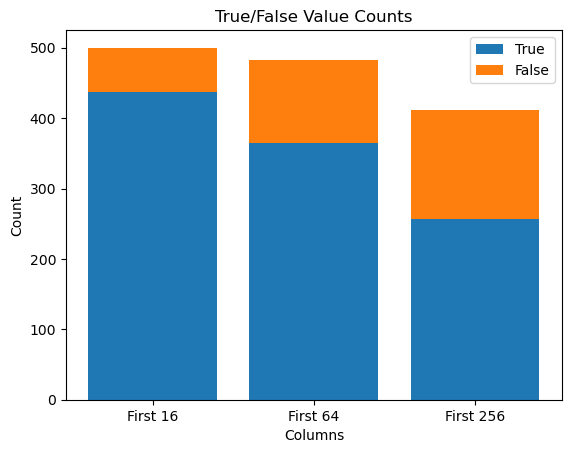

In [34]:
true = unified[unified['is_nonmonotonic'] == True]['is_nonmonotonic'].count()
false = unified[unified['is_nonmonotonic'] == False]['is_nonmonotonic'].count()

true2 = unified[unified['is_nonmonotonic64'] == True]['is_nonmonotonic64'].count()
false2 = unified[unified['is_nonmonotonic64'] == False]['is_nonmonotonic64'].count()

true3 = unified[unified['is_nonmonotonic256'] == True]['is_nonmonotonic256'].count()
false3 = unified[unified['is_nonmonotonic256'] == False]['is_nonmonotonic256'].count()

print(true)
columns = ['First 16', 'First 64', 'First 256']
plt.bar(columns, [true, true2, true3], label='True')
plt.bar(columns, [false, false2, false3], bottom=[true, true2, true3], label='False')

# Set labels and title
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('True/False Value Counts')

# Show the legend
plt.legend()

# Show the plot
plt.show()